In [1]:
import os, glob, json
import pickle, dill
import pandas as pd
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
import random, math
from tqdm import tqdm
import platform

# print machine name
machine_name = platform.node().split(".")[0]
print(machine_name)

# print available scratch directories
print(" ".join(os.listdir(f"/{machine_name}")))
scr_dir = os.listdir(f"/{machine_name}")[0]

DISK_IO_DIR = "/{}/{}/yiweil".format(machine_name,scr_dir) ## CHANGE CSID
print(DISK_IO_DIR)
if not os.path.exists(DISK_IO_DIR):
    os.mkdir(DISK_IO_DIR)
    
from utils import *
STANZA_DIR

john11
scr1
/john11/scr1/yiweil
Using Δ|&#8710;|∆|!delta as regex for comments awarding delta.
Found 422 conversations which are manually checked to be true climate convos.


'/nlp/u/yiweil/combined_stanza_output_with_ner_embed_removed'

In [2]:
with open('URL_DOMAINS_TO_EXCLUDE.txt','r') as f:
    domains_to_exclude = set(f.read().splitlines())
print(f"Excluding URLs from {len(domains_to_exclude)} domains:")
print(domains_to_exclude)

Excluding URLs from 43 domains:
{'', 'gfycat.com', 'youtube', 'voat.co', 'i.redd.it', 'knowyourmeme.com', 'duckduckgo.com', 'redditenhacementsuite', 's-media-cache-ak0.pinimg', 'twitter', 'lh3.googleusercontent.com', 'media.giphy.com', 'i0.kym-cdn.com', 'qph.ec.quoracdn.net', 'i.ytimg.com', 'img1.wikia.nocookie.net', 'open.spotify.com', 'scribd.com', 'google', 'i2.wp.com', 'reddit', 'chrome.google', 'facebook.com', 'i.pinimg.com', 'www\\.fanfiction\\.net', 'youtu', 'lmgtfy.com', 'images.app.goo.gl', 'greasyfork', 'pastebin', 'ff2ebook.com', 'instagram.com', 'vimeo.com', 'i216.photobucket.com', 's3.amazonaws.com', 'encrypted-tbn0.gstatic.com', 'soundcloud.com', 'mashable.com', 'imgur', '25.media.tumblr.com', '4.bp.blogspot', 'ri.search.yahoo.com', 'addons.mozilla'}


In [29]:
# LOAD CORPUS

from convokit import Corpus#, Speaker, download
AVAILABLE_CORP = ['full_cmv','matched_cmv_subsample','gen_reddit']
corp_name_to_filepath = {
                         'full_cmv': '/u/scr/yiweil/convokit_corpora/my-cmv-corpus_1-1-2010_to_09-24-2021',
                         'matched_cmv_subsample': '/u/scr/yiweil/subsampled_cmv_corpus',
                         'gen_reddit':'/u/scr/yiweil/datasets/convokit/reddit-corpus-small',
                         'switchboard':'/sailhome/yiweil/.convokit/downloads/switchboard-corpus'
                        }

corp_to_analyze = {'full_cmv': None}

for corp_name in corp_to_analyze:
    if corp_to_analyze[corp_name] is None:
        print("Loading corpus: {}...".format(corp_name))
        corp_to_analyze[corp_name] = Corpus(filename=corp_name_to_filepath[corp_name])
        corp_to_analyze[corp_name].print_summary_stats()
        print('\n')
        
        # Update full meta for conversations if corpus is not `matched_cc_cmv_subsample` (contains comments only, by design)
        if corp_name in {'full_cmv','matched_cmv_subsample','gen_reddit','switchboard'}:
            for utt in corp_to_analyze[corp_name].iter_utterances():
                if utt.id == utt.conversation_id: # not a comment but a post
                    convo = corp_to_analyze[corp_name].get_conversation(utt.id)
                    meta_dict = utt.meta
                    for key in meta_dict:
                        convo.add_meta(key, meta_dict[key])
                    convo.speaker = utt.speaker
                        
        print("Annotating {}...".format(corp_name))
        corp_to_analyze[corp_name] = filter_bots_mods(corp_to_analyze[corp_name])
        print('\n')
        
        if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample','full_cmv'}:
            print("Annotating generic utterances from {}...".format(corp_name))
            corp_to_analyze[corp_name] = filter_generic_comments(
                corp_to_analyze[corp_name], 
                GENERIC_REGEX_PATS,
                fname=f'generic_dict_{corp_name}.pkl')
            corp_to_analyze[corp_name].print_summary_stats()
            print('\n')
        print("Distribution of generic comments:")
        print(Counter([utt.meta['is_generic'] for utt in corp_to_analyze[corp_name].iter_utterances()
              if utt.id[:2]=='t1']))
            
        print("Removing footnotes and in-line embedded text from {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.text = cleanup(utt.text)
            
        print("Annotating removed/deleted comments in {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['is_removed'] = (utt.text == '[removed]') or (utt.text == '[deleted]')
            
        print("Annotating path information w/ version ignoring OP...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if (utt.id[:2] == 't1') and (utt.meta['outcome'] != -1):
                utt.meta['path_to_outcome_OP_removed'] = get_path_to_outcome_utt(corp_to_analyze[corp_name],
                                                                                 utt, 
                                                                                 ignore_OP=True,
                                                                                 ignore_removed=False)
        
        print("Distribution of valid utterances:")
        print(Counter([is_valid_utt(utt) for utt in corp_to_analyze['full_cmv'].iter_utterances()
                       if utt.id[:2]=='t1']))
        
        print("Distribution of delta outcomes:")
        print(Counter([utt.meta['outcome'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
              if utt.id[:2]=='t1']))
        
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['text_urls'] = get_urls(utt.text)
            utt.meta['url_domains'] = [get_url_domain(u_) for u_ in utt.meta['text_urls']]
            utt.meta['num_urls'] = len([x for x in utt.meta['url_domains'] 
                                        if (x[0] not in domains_to_exclude)
                                        and (x[1] not in domains_to_exclude)])
            utt.meta['has_url'] = utt.meta['num_urls'] > 0

Annotating path information w/ version ignoring OP...


3243830it [00:47, 68407.66it/s]


Distribution of valid utterances:
Counter({True: 2824502, False: 335070})
Distribution of delta outcomes:
Counter({-1: 1919491, '-delta': 1204715, '+delta': 35366})


3243830it [02:03, 26204.64it/s]


In [4]:
# INITIALIZE SUBTREES

subtree_outcome_utts = [utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
                        if (is_outcome_leaf(utt)) and (not is_removed_subtree(utt))]
subtree_ids = [utt.id for utt in subtree_outcome_utts]

In [7]:
def get_utt(utt_id,corp=corp_to_analyze['full_cmv']):
    return corp.get_utterance(utt_id)

def is_OP_utt(corp,utt):
    if utt.speaker.id == None:
        return False
    return (utt.speaker.id == corp.get_utterance(utt.conversation_id).speaker.id)

# (Copied from utils.py)
def is_valid_utt(utt):
    """
    Returns whether an utterance meets the following criteria: 
    1) is not removed/deleted; 
    2) is not empty; 
    3) is not generic; 
    4) is not written by a bot/moderator.
    """
    return (not utt.meta['is_removed']) and (not is_empty_utt(utt)) and (not utt.meta['is_generic']) \
       and (not utt.meta['written_by_bot']) 

def meets_datapoint_criteria(utt, corp=corp_to_analyze['full_cmv'], exclude_OP=True):
    """
    Returns whether an utterance should be counted when analyzing a subtree datapoint by checking whether:
    1) it is valid (see `is_valid_utt()`);
    2) it is not written by OP;
    3) it is at least 6 tokens OR has a URL.
    """
    if exclude_OP:
        return is_valid_utt(utt) and (not is_OP_utt(corp, utt)) and \
           ((len(utt.text.split())>=6) or \
            (utt.meta['has_url']))
    else:
        return is_valid_utt(utt) and \
           ((len(utt.text.split())>=6) or \
            (utt.meta['has_url']))


# Extract topic-controlled affect-related measures

Ryan's idea: 
* create custom set of CMV stopwords/stop n-grams to systematically discount when applying affect lexicons
    * discount top N most frequent n-grams (which would hopefully include "gun control", "abortion", "racism")
        * process:
            * Use SKLearn countvectorizer; unigrams + bigrams https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 
            * feed it all utterances in `full_CMV` corpus (`corp.get_utterances()`)
                * if `is_valid_utt(utt)`
            * get counts via `vectorizer.vocabulary_`
    * OR get some list of prominent (partisan) debates from Wikipedia/Pew/public opinion website (https://www.pewresearch.org/topics/)
        * store topics in a txt file, with each topic separated by a \n

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
   'This is the first document.',
    'This document is the second document.',
   'And this is the third one.',
    'Is this the first document?',
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

In [75]:
vectorizer.vocabulary_

{'this': 8,
 'is': 3,
 'the': 6,
 'first': 2,
 'document': 1,
 'second': 5,
 'and': 0,
 'third': 7,
 'one': 4}

Intuition: for all sister subtrees (subtrees attached to the same parent post), only count the words that are "distinctive", meaning words that are not related to the parent post's topic.
* measuring "distinctive-ness":
    * discount all lemmas occurring >= N times in parent post ("less_parent")
    * discount all lemmas occuring in >= M% of subtrees and parent post ("less_subtrees")

Algorithm:
* for every conversation/parent post:
    * get its lemma counts, `parent_lemma_counts`
    * initialize doc-frequency dict, `subtree_freq_per_lemma`
    * for every subtree attached to the parent post:
        * get its complete lemma count, update `subtree_freq_per_lemma`
    * for every subtree attached to the parent post:
        * get its subsetted lemmas that exclude all lemmas *l* such that `parent_lemma_counts[l]` >= N
            * compute affect-related predictor, f`{pred}_less_parent`
        * get its subsetted lemmas that exclude all lemmas *l* such that `subtree_freq_per_lemma` >= M% x N_subtrees
            * compute affect-related predictor, f`{pred}_less_subtrees`

In [8]:
# Many parent posts are [deleted] or [removed]
convo_ids = corp_to_analyze['full_cmv'].get_conversation_ids()
valid_convo_ids = [convo_id for convo_id in convo_ids
                   if meets_datapoint_criteria(get_utt(convo_id), exclude_OP=False)]
print(f"Found {len(valid_convo_ids)} valid conversation IDs out of {len(convo_ids)} conversations total.")

Found 26094 valid conversation IDs out of 84258 conversations total.


In [22]:
convo_id2subtree_outcome_ids = defaultdict(list)
for subtree_id in tqdm(subtree_ids):
    convo_id2subtree_outcome_ids[get_utt(subtree_id).conversation_id].append(subtree_id)

100%|██████████| 1203509/1203509 [00:03<00:00, 321345.67it/s]


In [59]:
len(subtree_ids),len(set(subtree_ids))

(1203509, 1203509)

In [70]:
N = 1
M = 0.25

In [71]:
for convo_id in tqdm(valid_convo_ids[1:2]):
    print('*'*15+'Original parent post'+'*'*15)
    #print(get_utt(convo_id).text)
    parent_lemmas = get_stanza_lemmas(get_utt(convo_id))
    parent_lemma_counts = Counter(parent_lemmas)
#     print('\n'+'*'*15+'Parent post lemma counts'+'*'*15)
#     print(parent_lemma_counts)
    print(' '.join(parent_lemmas))
    
    # Get "doc" frequencies over subtrees
    subtree_freq_per_lemma = Counter()
    lemmas_per_subtree = defaultdict(dict) # cache for greater efficiency
    num_subtrees = len(convo_id2subtree_outcome_ids[convo_id])
    for subtree in convo_id2subtree_outcome_ids[convo_id]:
        lemmas_per_subtree[subtree] = {u_id: get_stanza_lemmas(get_utt(u_id)) 
                                       for u_id in get_utt(subtree).meta['path_to_outcome']
                                       if is_valid_utt(get_utt(u_id))}
        if len(lemmas_per_subtree[subtree]) > 0:
            subtree_vocab = set().union(*[set(lemmas_per_subtree[subtree][u_id])
                                          for u_id in lemmas_per_subtree[subtree]]) # include OP comments
            subtree_freq_per_lemma += Counter(subtree_vocab)
#     print('\n'+'*'*15+'Doc frequencies'+'*'*15)
#     print(subtree_freq_per_lemma)
        
    print('\n'+'*'*5+f'Lemmas occurring in {M*100}% or more of subtrees'+'*'*5)
    print(" ".join([colored(lemma, 'blue') if subtree_freq_per_lemma[lemma] >= M*num_subtrees
                    else colored(lemma, 'grey') 
                    for lemma in [x[0] for x in 
                                  sorted(subtree_freq_per_lemma.items(), key=lambda x: x[1], reverse=True)]]))
        
    for subtree in convo_id2subtree_outcome_ids[convo_id]:
        subtree_lemmas = flatten([lemmas_per_subtree[subtree][u_id]
                                  for u_id in get_utt(subtree).meta['path_to_outcome_OP_removed']
                                  if is_valid_utt(get_utt(u_id))]) # exclude OP comments when computing features
        if len(subtree_lemmas) > 0:
            subtree_lemma_counts = Counter(subtree_lemmas)
#             print('\n'+'*'*15+'Subtree lemma counts'+'*'*15)
#             print(subtree_lemma_counts)
            #if subtree_lemma_counts
            lemmas_less_parent = [l for l in subtree_lemmas if parent_lemma_counts[l] < N]
            lemmas_less_subtrees = [l for l in subtree_lemmas if subtree_freq_per_lemma[l] < M*num_subtrees]
            print('\n'+'*'*5+f'Subree lemmas excluding lemmas occurring {N} or more times in parent post'+'*'*5)
            #print(lemmas_less_parent)
            print(" ".join([colored(lemma, 'red') if parent_lemma_counts[lemma] < N 
                            else colored(lemma, 'grey') for lemma in subtree_lemmas[-100:]]))
            print('\n'+'*'*5+f'Subree lemmas excluding lemmas occurring in {M*100}% of subtrees'+'*'*5)
            print(" ".join([colored(lemma, 'red') if subtree_freq_per_lemma[lemma] < M*num_subtrees
                            else colored(lemma, 'grey') for lemma in subtree_lemmas[-100:]]))
            #print(lemmas_less_subtrees)
        else:
            print("\n0 valid utterances within subtree, excluding OP's.")
            

  0%|          | 0/1 [00:00<?, ?it/s]

***************Original parent post***************
cmv 51 new gender option be over the top and useless awhile ago facebook release several new gender many of they seem to come out of nowhere and almost all be incredibly confusing over the top and redundant to preface this I be not against anyone in the lgbt community and welcome the idea of gay marriage and thing similar however i've never really be on board with all this new gender anyway some of the term that come to mind be agender and androgynous the mean the same thing to not identify as any gender so why be they two separate word genderfluid and bigender seem completely redundant too so why even have they i'm also not entirely sure why people can not just dress the way they want to while remain whatever sex they be give at birth do it really matter if a man dress as a woman do he really have to be classify as gender-fluid because it really just seem like a word that would be less blunt than cross -dress again I have nothing agai

100%|██████████| 1/1 [00:05<00:00,  5.23s/it]


*****Lemmas occurring in 25.0% or more of subtrees*****
it be a for not they have but you and I the do this because that of to want would who if there gender can on woman someone all in so as see at which term person when what trans probably need give like between say come mean my some cis its about female get still matter than from make people now we show with man or why comment word male up think option put refer then more use annoyed really other how try least know out time way no easy differentiate feel just one also any identify two % either regardless definitely meaning call group assume birth delta safe where will thing ∆ sense right new may precise difference very likely such mtf vs. .~~ half hehe overload context reassign depend example similar anyway ambiguity over lot understand rather themselves should while opposite choice Facebook list possible polite ice eat transgendered 30 cream yet awkward cis-woman Study cis- non-transgendered sexual both maybe define thank reason a

In [69]:
M = 0.25

print('\n'+'*'*5+f'Lemmas occurring in {M*100}% or more of subtrees'+'*'*5)
print(" ".join([colored(lemma, 'blue') if subtree_freq_per_lemma[lemma] >= M*num_subtrees
                else colored(lemma, 'grey') 
                for lemma in [x[0] for x in 
                              sorted(subtree_freq_per_lemma.items(), key=lambda x: x[1], reverse=True)]]))


*****Lemmas occurring in 25.0% or more of subtrees*****
it be a for not they have but you and I the do this because that of to want would who if there gender can on woman someone all in so as see at which term person when what trans probably need give like between say come mean my some cis its about female get still matter than from make people now we show with man or why comment word male up think option put refer then more use annoyed really other how try least know out time way no easy differentiate feel just one also any identify two % either regardless definitely meaning call group assume birth delta safe where will thing ∆ sense right new may precise difference very likely such mtf vs. .~~ half hehe overload context reassign depend example similar anyway ambiguity over lot understand rather themselves should while opposite choice Facebook list possible polite ice eat transgendered 30 cream yet awkward cis-woman Study cis- non-transgendered sexual both maybe define thank reason a

# Populate `utt.meta` w/ all regression predictors

All features:
* Emotionality
    * SentiStrength (+/-) arousal (`senti_<pos/neg>_arousal_<all/adxs_only>`)
    * NRC valence, arousal (`nrc_<val/arousal>_<all/adxs_only>`)
    * EmoLex emotion intensity scores (`emo_<emotion>_<all/adxs_only>`)
    * MFD (`mfd_<foundation>_<vice/virtue>_<all/adxs_only>`)
    * ***later: hybrid classifier approach***
* Evidentiality
    * `has_evidence`
    * `num_evidence_chunks`
* Structural
    * `depth`
    * `total_num_words`
    * `mean_num_words`
    * `order`
    * `rel_timestamp`
    * `abs_timestamp`

In [5]:
# First examine distribution of utterances meeting all criteria for inclusion 
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    utt.meta['meets_datapoint_crit_excl_OP'] = meets_datapoint_criteria(utt)
    utt.meta['meets_datapoint_crit_with_OP'] = meets_datapoint_criteria(utt, exclude_OP=False)
print("Distribution of comments meeting all datapoint criteria:")
print(Counter([utt.meta['meets_datapoint_crit_excl_OP'] for utt in corp_to_analyze['full_cmv'].iter_utterances()]))
print("Distribution of comments meeting all datapoint criteria, incl. OP's:")
print(Counter([utt.meta['meets_datapoint_crit_with_OP'] for utt in corp_to_analyze['full_cmv'].iter_utterances()]))

# Initialize `utt.meta` with empty dicts for storing regression predictors
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if utt.meta['meets_datapoint_crit_with_OP'] == True:
        utt.meta['reg_feats'] = {}

3243830it [02:25, 22250.00it/s]


Distribution of comments meeting all datapoint criteria:
Counter({True: 2225370, False: 1018460})
Distribution of comments meeting all datapoint criteria, incl. OP's:
Counter({True: 2765330, False: 478500})


3243830it [00:21, 149170.13it/s]


In [6]:
# Load all cached features

print("Loading cached features...")
corp_name = 'full_cmv'
all_senti_scores = pickle.load(open('{}_senti_scores.pkl'.format(corp_name),'rb'))
senti_scores_dict = {model: {item[0]: item[1] for item in all_senti_scores[model]}
                         for model in all_senti_scores}
del all_senti_scores
nrc_cache = pickle.load(open(f'VAD_scores_{corp_name}.pkl','rb'))
emolex_cache = pickle.load(open(f'emolex_scores_{corp_name}.pkl','rb'))
mfd_cache = dill.load(open(f'MFD_scores_{corp_name}.pkl','rb'))
print("Done loading!")

MFD_FOUNDS = ['authority','purity','fairness','harm','loyalty']
MFD_FOUNDS = [f'{found}_{valence}' for found in MFD_FOUNDS for valence in ['virtue','vice']]
print(MFD_FOUNDS)

EMOLEX_EMOS = ['fear','anger','sadness','disgust','anticipation','joy','trust','surprise']
    
for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
    if utt.meta['meets_datapoint_crit_with_OP'] == True:
        for model in ['all','adxs_only']:
            # SentiStrength
            for i,val in enumerate(['pos','neg']):
                utt.meta['reg_feats'][f'senti_{val}_arousal_{model}'] = senti_scores_dict[model][utt.id][i]
            # NRC
            for feat in ['val', 'arousal']:
                utt.meta['reg_feats'][f'nrc_{feat}_{model}'] = nrc_cache[utt.id][model][feat]
            # MFD
            mfd_scores = mfd_cache[utt.id]['norms']
            if model not in mfd_scores:
                for found in MFD_FOUNDS:
                    utt.meta['reg_feats'][f'mfd_{found}_{model}'] = 0
            else:
                for foundation in ['authority','harm','purity','fairness','loyalty']:
                    for val in ['virtue','vice']:
                        utt.meta['reg_feats'][f'mfd_{foundation}_{val}_{model}'] = \
                            mfd_scores[model][foundation][val]
        # EmoLex
        emolex_scores = emolex_cache[utt.id]['norms']
        for model in emolex_scores:
            for emo in emolex_scores[model]:
                utt.meta['reg_feats'][f'emo_{emo}_{model}'] = emolex_scores[model][emo]
del senti_scores_dict
del nrc_cache
del emolex_cache
del mfd_cache

Loading cached features...
Done loading!
['authority_virtue', 'authority_vice', 'purity_virtue', 'purity_vice', 'fairness_virtue', 'fairness_vice', 'harm_virtue', 'harm_vice', 'loyalty_virtue', 'loyalty_vice']


3243830it [05:15, 10293.26it/s]


In [9]:
# Do subtrees separately for SS
all_senti_scores = pickle.load(open('{}_subtrees_senti_scores.pkl'.format(corp_name),'rb'))
senti_scores_dict = {model: {item[0]: item[1] for item in all_senti_scores[model]}
                          for model in all_senti_scores}
del all_senti_scores
for subtree_id in tqdm(subtree_ids):
    for model in ['all','adxs_only']:
        outcome_utt = get_utt(subtree_id)
        if 'reg_feats' not in outcome_utt.meta:
            outcome_utt.meta['reg_feats'] = {}
        outcome_utt.meta['reg_feats'][f'senti_{model}_subtree'] = senti_scores_dict[model][subtree_id]
            
del senti_scores_dict

100%|██████████| 1203509/1203509 [00:18<00:00, 64591.61it/s]


In [10]:
# Add evidentiality features
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    utt.meta['evidence_in_chunks?'] = {}

model_preds_dict = pickle.load(open('model_preds_kw_chunks_full_cmv.pkl','rb'))
for key in model_preds_dict:
    utt_id, chunk_no = key.split('|')
    utt = get_utt(utt_id)
    utt.meta['evidence_in_chunks?'][chunk_no] = model_preds_dict[key]
del model_preds_dict

for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if meets_datapoint_criteria(utt): # exclude OP by default
        utt.meta['reg_feats']['num_evidence_chunks'] = sum([int(b) 
                                                            for b in utt.meta['evidence_in_chunks?'].values()])
        utt.meta['reg_feats']['has_evidence'] = utt.meta['reg_feats']['num_evidence_chunks'] > 0
        utt.meta['reg_feats']['num_evidence_kws'] = count_kws(utt.text)

3243830it [00:25, 127338.04it/s]
3243830it [27:21, 1976.71it/s]


In [61]:
# Add structural features

def get_depth(corp, outcome_utt, ignore_OP=True, ignore_removed=False):
    """Returns the length measured as the depth of a sub-tree."""
    assert is_outcome_leaf(outcome_utt)
    path_to_outcome_utt = get_path_to_outcome_utt(corp, outcome_utt, ignore_OP=ignore_OP, 
                                                  ignore_removed=ignore_removed)
    return len(path_to_outcome_utt)

def get_total_num_words(corp, outcome_utt, ignore_OP=True, ignore_removed=True):
    """Returns the length measured as the total number of words in a sub-tree."""
    assert is_outcome_leaf(outcome_utt)
    path_to_outcome_utt = get_path_to_outcome_utt(corp, outcome_utt, ignore_OP=ignore_OP)
    #if i
    num_words = sum([len(corp.get_utterance(utt_id).text.split()) 
                     for utt_id in path_to_outcome_utt])
    return num_words

def get_mean_num_words(corp, outcome_utt, ignore_OP=True, ignore_removed=True):
    """Returns the length measured as the mean number of words per comment in a sub-tree."""
    assert is_outcome_leaf(outcome_utt)
    path_to_outcome_utt = get_path_to_outcome_utt(corp, outcome_utt, ignore_OP=ignore_OP)
    mean_num_words = np.average([len(corp.get_utterance(utt_id).text.split()) 
                                 for utt_id in path_to_outcome_utt])
    return mean_num_words
    
def get_order(corp,outcome_utt):
    """Returns the order of the top-level comment of a sub-tree."""
    assert is_outcome_leaf(outcome_utt)
    first_utt_in_subtree = outcome_utt.meta['path_to_outcome'][0]

    top_level_timestamps = []
    for top_level_utt_id in corp_to_analyze['full_cmv'].get_conversation(
        outcome_utt.conversation_id).meta['top_level_comments']:
        top_level_timestamps.append((top_level_utt_id,
                                     corp_to_analyze['full_cmv'].get_utterance(top_level_utt_id).timestamp))
    sorted_timestamps = sorted(top_level_timestamps, key=lambda x:x[1], reverse=False)
    sorted_top_level_utt_ids = [x[0] for x in sorted_timestamps]
    return sorted_top_level_utt_ids.index(first_utt_in_subtree)+1
    
    first_utt_in_subtree = corp.get_utterance(outcome_utt.meta['path_to_outcome'][0])
    convo = corp.get_conversation(outcome_utt.conversation_id)
    for path in convo.get_root_to_leaf_paths():
        for depth,u in enumerate(path):
            if u.id == first_utt_in_subtree.id:
                return depth+1
            
def get_rel_timestamp_subtree(corp,outcome_utt):
    """
    Returns the time elapsed in seconds between the first comment of a sub-tree and the OG post.
    """
    first_utt_in_subtree = corp.get_utterance(outcome_utt.meta['path_to_outcome'][0])
    return first_utt_in_subtree.timestamp - corp.get_utterance(outcome_utt.conversation_id).timestamp

def get_abs_timestamp_subtree(corp,outcome_utt):
    """
    Returns the absolute timestamp of the first comment of a sub-tree.
    """
    first_utt_in_subtree = corp.get_utterance(outcome_utt.meta['path_to_outcome'][0])
    return first_utt_in_subtree.timestamp

for subtree_id in tqdm(subtree_ids):
    outcome_utt = get_utt(subtree_id)
    outcome_utt.meta['reg_feats'][f'depth'] = get_depth(corp_to_analyze['full_cmv'],
                                                        outcome_utt)
    outcome_utt.meta['reg_feats'][f'total_num_words'] = get_total_num_words(corp_to_analyze['full_cmv'],
                                                        outcome_utt)
    outcome_utt.meta['reg_feats'][f'mean_num_words'] = get_mean_num_words(corp_to_analyze['full_cmv'],
                                                        outcome_utt)
    outcome_utt.meta['reg_feats'][f'order'] = get_order(corp_to_analyze['full_cmv'],
                                                        outcome_utt)
    outcome_utt.meta['reg_feats'][f'rel_timestamp'] = get_rel_timestamp_subtree(corp_to_analyze['full_cmv'],
                                                        outcome_utt)
    outcome_utt.meta['reg_feats'][f'abs_timestamp'] = get_abs_timestamp_subtree(corp_to_analyze['full_cmv'],
                                                        outcome_utt)

100%|██████████| 1203509/1203509 [06:19<00:00, 3170.30it/s]


# Examine distributions for each predictor

In [11]:
model2title = {'all': 'all features', 
               'adxs_only': 'adjs/advs only', 
               'exp': 'experiencers', 
               'stim':'stimuli'}
EMOLEX_EMOS = ['fear','anger','sadness','disgust','anticipation','joy','trust','surprise']
emo_markers = ["o", "v", "^", "s", "*", "D", "+", "X"]
mfd_markers = ["o", "v", "^", "s", "*", "D", "+", "X", ".", "P"]

## Temporal distributions

In [16]:
years = list(range(2013,2022))

### Utterance level (including OP comments; ignoring OG post texts, removed/deleted, empty comments)

In [44]:
# Create dfs for plotting

plot_dfs = {}

for corp_name in corp_to_analyze:
    for model in ['all','adxs_only','exp','stim']:
        # Create dataframe for plotting, one for each model
        df_id, df_year, df_pos_arousal, df_neg_arousal, df_nrc_val, df_nrc_arousal = [], [], [], [], [], []
        df_emos = {emo: [] for emo in EMOLEX_EMOS}
        df_founds = {found: [] for found in MFD_FOUNDS}
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if utt.meta['meets_datapoint_crit_with_OP'] == True:
                year = datetime.utcfromtimestamp(utt.timestamp).year
                df_year.append(year)
                df_id.append(utt.id)
                for emo in EMOLEX_EMOS:
                    df_emos[emo].append(utt.meta['reg_feats'][f'emo_{emo}_{model}'])
                if (model == 'all') or (model == 'adxs_only'):
                    df_pos_arousal.append(utt.meta['reg_feats'][f'senti_pos_arousal_{model}'])
                    df_neg_arousal.append(abs(utt.meta['reg_feats'][f'senti_neg_arousal_{model}']))
                    df_nrc_val.append(utt.meta['reg_feats'][f'nrc_val_{model}'])
                    df_nrc_arousal.append(utt.meta['reg_feats'][f'nrc_arousal_{model}'])
                    for found in MFD_FOUNDS:
                        df_founds[found].append(utt.meta['reg_feats'][f'mfd_{found}_{model}'])
        to_plot_df = {
            'year':df_year,
            'id':df_id,}
        to_plot_df.update({emo: df_emos[emo] for emo in EMOLEX_EMOS})
        if (model == 'all') or (model == 'adxs_only'):
            to_plot_df.update({
                'pos_arousal':df_pos_arousal,
                'neg_arousal':df_neg_arousal,
                'nrc_val': df_nrc_val,
                'nrc_arousal': df_nrc_arousal,
            })
            to_plot_df.update({found: df_founds[found] for found in MFD_FOUNDS})
            to_plot_df = pd.DataFrame(to_plot_df)
        
            # Wrangle SS categories
            for i,val in enumerate(['pos','neg']):
                categories=[1,2,3,4,5]
                to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                          to_plot_df['{}_arousal'.format(val)],
                                                          categories=categories,
                                                          ordered=True)
        if type(to_plot_df) == dict:
            to_plot_df = pd.DataFrame(to_plot_df)
        plot_dfs[model] = to_plot_df

3243830it [02:09, 24992.83it/s]
3243830it [02:04, 26095.33it/s]
3243830it [01:06, 48528.94it/s]
3243830it [01:03, 50844.57it/s]


In [48]:
plot_dfs['all'][MFD_FOUNDS].describe()

authority_virtue  authority_vice  purity_virtue   purity_vice  \
count      2.765330e+06    2.765330e+06   2.765330e+06  2.765330e+06   
mean       3.578542e-01    5.708071e-02   2.470302e-01  1.743058e-01   
std        9.928376e-01    3.358883e-01   1.034242e+00  7.061434e-01   
min        0.000000e+00    0.000000e+00   0.000000e+00  0.000000e+00   
25%        0.000000e+00    0.000000e+00   0.000000e+00  0.000000e+00   
50%        0.000000e+00    0.000000e+00   0.000000e+00  0.000000e+00   
75%        0.000000e+00    0.000000e+00   0.000000e+00  0.000000e+00   
max        4.600000e+01    2.700000e+01   2.610000e+02  5.300000e+01   

       fairness_virtue  fairness_vice   harm_virtue     harm_vice  \
count     2.765330e+06   2.765330e+06  2.765330e+06  2.765330e+06   
mean      2.388113e-01   1.900909e-01  4.365342e-01  4.337001e-01   
std       8.077559e-01   8.023975e-01  1.218002e+00  1.315744e+00   
min       0.000000e+00   0.000000e+00  0.000000e+00  0.000000e+00   
25%       0.000000e+00   0.000000e+00  0.000000e+00  0.000000e+00   
50%       0.000000e+00   0.000000e+00  0.000000e+00  0.000000e+00   
75%       0.000000e+00   0.000000e+00  0.000000e+00  0.000000e+00   
max       6.000000e+01   6.400000e+01  6.800000e+01  9.700000e+01   

       loyalty_virtue  loyalty_vice  
count    2.765330e+06  2.765330e+06  
mean     3.653408e-01  1.161959e-02  
std      1.073270e+00  1.463326e-01  
min      0.000000e+00  0.000000e+00  
25%      0.000000e+00  0.000000e+00  
50%      0.000000e+00  0.000000e+00  
75%      0.000000e+00  0.000000e+00  
max      5.600000e+01  2.900000e+01

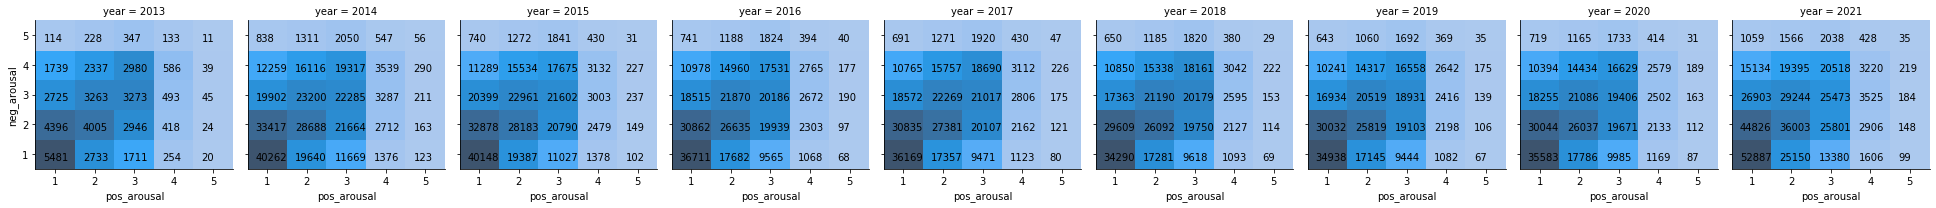

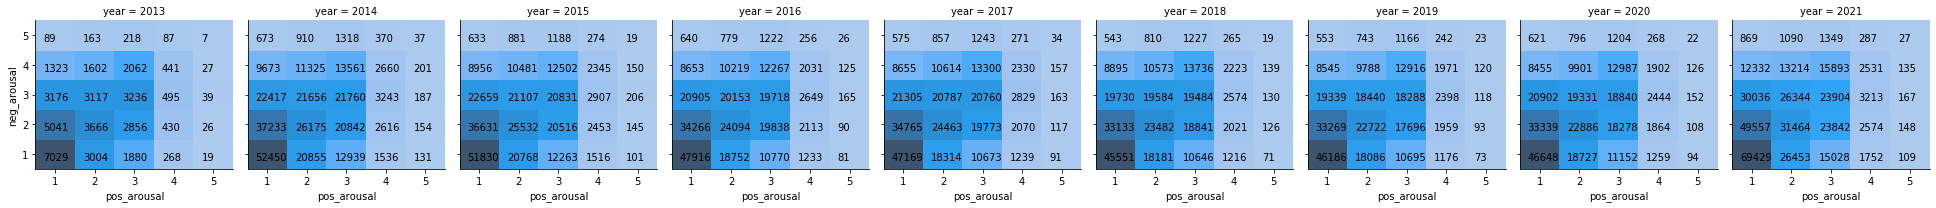

In [40]:
# SentiStrength

for model in ['all','adxs_only']:
    plot_df = plot_dfs[model]

    g = sns.FacetGrid(plot_df, col='year', aspect=1)
    g.map(sns.histplot, 'pos_arousal', 'neg_arousal')#, ci='sd')
    g.fig.axes[0].invert_yaxis()
    sns.despine()
    for i,col in enumerate(g.col_names):
        ax = g.axes.flat[i]
        x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
        for p_i,pos_level in enumerate(categories):
            for n_i,neg_level in enumerate(categories):
                ax.annotate(str(len(to_plot_df.loc[(plot_df['year']==col) &
                                                   (plot_df['pos_arousal']==pos_level) &
                                                   (plot_df['neg_arousal']==neg_level)])),
                            xy=(x_locs[p_i]+0.7,y_locs[n_i]+0.8))

    #
    plt.savefig(f'figs/senti_dist_over_time_{corp_name}_{model}.png',
                dpi=150,bbox_inches="tight")

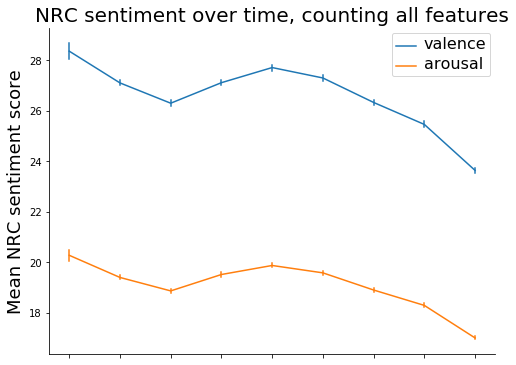

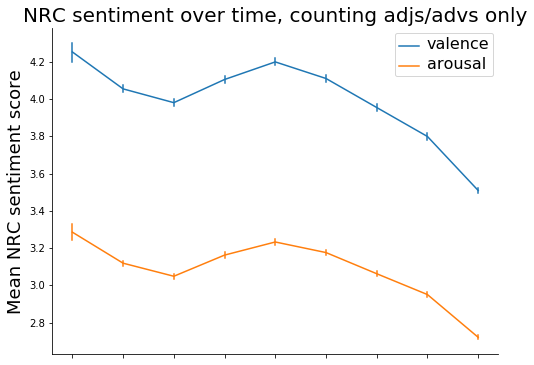

In [19]:
# NRC

for model in ['all','adxs_only']:
    plot_df = plot_dfs[model]

    fig, ax = plt.subplots(figsize=(8,6))
    sns.lineplot(data=plot_df, x='year', y='nrc_val', ax=ax, label='valence', 
                 estimator='mean', err_style='bars')
    sns.lineplot(data=plot_df, x='year', y='nrc_arousal', ax=ax, label='arousal', 
                 estimator='mean', err_style='bars')
    sns.despine()
    plt.setp(ax.get_legend().get_texts(), fontsize='16') 
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=16)
    ax.set_ylabel('Mean NRC sentiment score',fontsize=18)
    ax.set_title(f'NRC sentiment over time, counting {model2title[model]}', fontsize=20)
    #plt.setp(gfg.get_legend().get_title(), fontsize='20')
    plt.savefig(f'figs/nrc_dist_over_time_{corp_name}_{model}.png',dpi=150,bbox_inches="tight")

In [30]:
# EmoLex
model2hue_order = {
    'all': ['trust', 'fear', 'joy', 'anticipation', 'anger', 'sadness', 'disgust', 'surprise'],
    'adxs_only': ['trust','joy','anticipation','fear','sadness','anger','disgust','surprise'],
    'exp': ['anger','trust','fear','anticipation','disgust','surprise','sadness','joy'],
    'stim': ['trust','joy','sadness','anticipation','fear','disgust','surprise','anger']}

for model in ['all','adxs_only','exp','stim']:
    plot_df = plot_dfs[model]
    fig, ax = plt.subplots(figsize=(10,8))
    for i,emo in enumerate(EMOLEX_EMOS):
        sns.lineplot(data=plot_df, x='year', y=emo, ax=ax, label=emo, 
                     estimator='mean', err_style='bars', marker=emo_markers[i])
    sns.despine()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    handles,labels = ax.get_legend_handles_labels()
    label2handle = dict(zip(labels,handles))
    in_order_labels = model2hue_order[model]
    print("In order labels:", in_order_labels)
    in_order_handles = [label2handle[l] for l in in_order_labels]
    ax.legend(handles=in_order_handles, labels=in_order_labels)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    
    ax.set_ylabel("Mean emotion intensity", fontsize=20)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    ax.set_title(f"EmoLex scores over time, counting {model2title[model]}", fontsize=22)
    plt.savefig(f'figs/emolex_dist_over_time_{corp_name}_{model}.png',dpi=150,bbox_inches="tight")

NameError: name 'plot_dfs' is not defined

In order labels: ['harm_virtue', 'harm_vice', 'loyalty_virtue', 'loyalty_vice', 'purity_virtue', 'fairness_virtue', 'fairness_vice', 'purity_vice', 'authority_vice', 'loyalty_vice']
In order labels: ['fairness_vice', 'fairness_virtue', 'purity_vice', 'harm_virtue', 'purity_virtue', 'authority_virtue', 'harm_vice', 'loyalty_virtue', 'authority_vice', 'loyalty_vice']


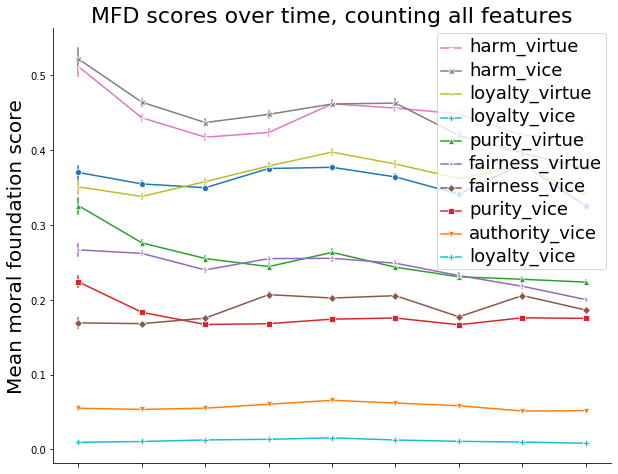

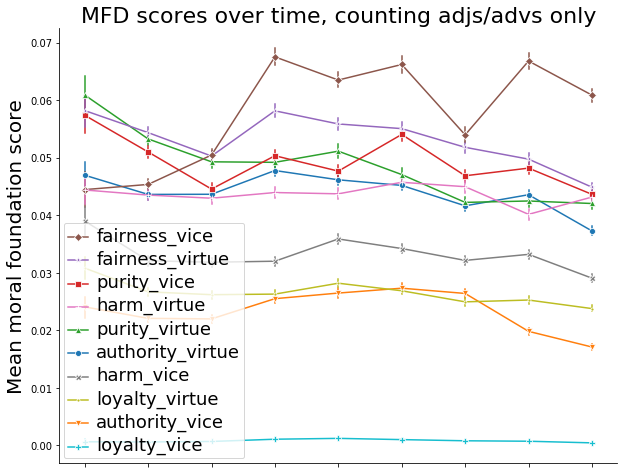

In [52]:
model2hue_order = {'all': ['harm_virtue','harm_vice','loyalty_virtue','loyalty_vice',
                           'purity_virtue','fairness_virtue','fairness_vice','purity_vice',
                           'authority_vice','loyalty_vice'],
                   'adxs_only': ['fairness_vice','fairness_virtue','purity_vice','harm_virtue',
                                 'purity_virtue','authority_virtue','harm_vice','loyalty_virtue',
                                 'authority_vice','loyalty_vice']}

for model in ['all','adxs_only']:
    plot_df = plot_dfs[model]
    fig, ax = plt.subplots(figsize=(10,8))
    for i,found in enumerate(MFD_FOUNDS):
        sns.lineplot(data=plot_df, x='year', y=found, ax=ax, label=found, 
                     estimator='mean', err_style='bars', marker=mfd_markers[i])
    sns.despine()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    handles,labels = ax.get_legend_handles_labels()
    label2handle = dict(zip(labels,handles))
    in_order_labels = model2hue_order[model]
    print("In order labels:", in_order_labels)
    in_order_handles = [label2handle[l] for l in in_order_labels]
    ax.legend(handles=in_order_handles, labels=in_order_labels)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    
    ax.set_ylabel("Mean moral foundation score", fontsize=20)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    ax.set_title(f"MFD scores over time, counting {model2title[model]}", fontsize=22)
    plt.savefig(f'figs/mfd_dist_over_time_{corp_name}_{model}.png',dpi=150,bbox_inches="tight")

### Subtree level (*excluding* OP comments; ignoring OP post texts, removed/deleted, and empty comments; excluding completely removed subtrees)

In [53]:
def get_subtree_score(feat, model_type, subtree_outcome_utt, excl_OP=True, get_text=False):
    """
    Returns the subtree-level score for a given feature `feat`, model type `model_type`, and subtree
    as indexed by its outcome utt `subtree_outcome_utt` by taking the sum of the component comments' values
    (excl.) OP's.
    """
    if feat == 'senti_pos_arousal':
        return subtree_outcome_utt.meta['reg_feats'][f'senti_{model_type}_subtree'][0]
    elif feat == 'senti_neg_arousal':
        return subtree_outcome_utt.meta['reg_feats'][f'senti_{model_type}_subtree'][1]
    elif feat in {'depth','total_num_words','mean_num_words','order','rel_timestamp','abs_timestamp'}:
        return subtree_outcome_utt.meta['reg_feats'][feat]
    else:
        if excl_OP:
            path_to_outcome_OP_removed = subtree_outcome_utt.meta['path_to_outcome_OP_removed']
            path_to_outcome_valid_utts = [u_id for u_id in path_to_outcome_OP_removed
                                          if get_utt(u_id).meta['meets_datapoint_crit_excl_OP']]
        else:
            path_to_outcome = subtree_outcome_utt.meta['path_to_outcome']
            path_to_outcome_valid_utts = [u_id for u_id in path_to_outcome
                                          if get_utt(u_id).meta['meets_datapoint_crit_with_OP']]
            
        if get_text:
            subtree_text = [get_utt(u_id).text for u_id in path_to_outcome_valid_utts]
            return subtree_text
        
        if model_type == None:
            return sum([get_utt(u_id).meta['reg_feats'][feat] for u_id in path_to_outcome_valid_utts])
        else:
            return sum([get_utt(u_id).meta['reg_feats'][f'{feat}_{model_type}'] 
                        for u_id in path_to_outcome_valid_utts])
    
# # TO DO: make sure script works

# outcome_utt = subtree_outcome_utts[10990]
# path_to_outcome_utt = outcome_utt.meta['path_to_outcome_OP_removed']
# print("Complete challenger path to outcome comment:", path_to_outcome_utt)
# path_to_outcome_valid = [u_id for u_id in path_to_outcome_utt if get_utt(u_id).meta['meets_datapoint_crit']]
# print("Valid challenger path to outcome comment:", path_to_outcome_valid)

# for sample_feat in ['nrc_val', 'emo_fear', 'emo_trust']:
#     for model in ['all', 'adxs_only']:
#         utt_vals = [get_utt(u_id).meta['reg_feats'][f'{sample_feat}_{model}'] for u_id in path_to_outcome_valid]
#         print(f"\tComponent utterance `{sample_feat}` values:", utt_vals)
#         sum_utt_vals = sum(utt_vals)
#         print(f"\tSum of component utterance `{sample_feat}` values:", sum_utt_vals)
#         subtree_val = get_subtree_score(sample_feat, model, outcome_utt)
#         print("\tOutput of `get_subtree_score` function:", subtree_val)
#         print(f"\t\t>> Expected output: {sum_utt_vals}")
#         assert sum_utt_vals == subtree_val
#         print("\t\t>> Test passed!")
#         print()

In [86]:
#get_utt(subtree_ids[10]).meta

In [63]:
to_plot_df = pd.read_pickle('full_cmv_subtrees_reg_df.pkl')
print(to_plot_df.shape)
display(to_plot_df.head())

# to_plot_df['num_evidence_kws'] = to_plot_df['subtree_outcome_utt_id'].apply(
#     lambda x: get_utt(x).meta['num_evidence_kws'] if 'num_evidence_kws' in get_utt(x).meta else 0)
# to_plot_df['num_urls'] = to_plot_df['subtree_outcome_utt_id'].apply(
#     lambda x: get_utt(x).meta['num_urls'])
# display(to_plot_df.head(10))
# to_plot_df.to_pickle('full_cmv_subtrees_reg_df.pkl')

(1203509, 76)


subtree_outcome_utt_id outcome conversation_id     timestamp  \
0             t1_djhcrq8  -delta       t3_6juc9p  1.498598e+09   
1             t1_csajf84  -delta       t3_3a7ys8  1.434584e+09   
2             t1_g99brae  -delta       t3_jdn5or  1.603054e+09   
3             t1_cqxesmu  -delta       t3_34rgpv  1.430694e+09   
4             t1_cgmavct  -delta       t3_22dcc4  1.396818e+09   

   senti_pos_arousal_all  senti_pos_arousal_adxs_only  senti_neg_arousal_all  \
0                      3                            3                     -3   
1                      3                            3                     -3   
2                      2                            2                     -2   
3                      3                            3                     -3   
4                      3                            3                     -3   

   senti_neg_arousal_adxs_only  nrc_val_all  nrc_val_adxs_only  ...  \
0                           -3       63.556              8.970  ...   
1                           -3       70.269              9.957  ...   
2                           -2       32.448              6.611  ...   
3                           -3       43.035              6.274  ...   
4                           -3       38.548              6.213  ...   

   total_num_words  mean_num_words  order  rel_timestamp  abs_timestamp  year  \
0              227           227.0     21        12519.0   1.498598e+09  2017   
1              246           123.0      2         1823.0   1.434584e+09  2015   
2              129            64.5     11         2724.0   1.603054e+09  2020   
3              146           146.0      4          879.0   1.430694e+09  2015   
4              134            67.0      2         1076.0   1.396818e+09  2014   

   month  year_mo  num_evidence_kws  num_urls  
0      6   2017-6                 0         0  
1      6   2015-6                 0         0  
2     10  2020-10                 0         0  
3      5   2015-5                 0         0  
4      4   2014-4                 0         0  

[5 rows x 76 columns]

In [64]:
to_plot_df['outcome'].value_counts()

-delta    1169691
+delta      33818
Name: outcome, dtype: int64

In [65]:
to_plot_df['outcome'].value_counts()/sum(to_plot_df['outcome'].value_counts())

-delta    0.971901
+delta    0.028099
Name: outcome, dtype: float64

In [ ]:
# to_plot_df = {
#     'subtree_outcome_utt_id': [utt.id for utt in subtree_outcome_utts],
#     #'count': [1 for utt in subtree_outcome_utts],
#     #'+delta count': [1 if utt.meta['outcome'] == '+delta' else 0 for utt in subtree_outcome_utts],
#     #'-delta count': [1 if utt.meta['outcome'] == '-delta' else 0 for utt in subtree_outcome_utts],
#     'outcome': [utt.meta['outcome'] for utt in subtree_outcome_utts],
#     'conversation_id': [utt.conversation_id for utt in subtree_outcome_utts],
#     'timestamp': [get_abs_timestamp_subtree(corp_to_analyze['full_cmv'],utt) 
#                   for utt in subtree_outcome_utts],}
# to_plot_df.update({
#         f'{feat}_{model_type}': [get_subtree_score(feat, model_type, utt) for utt in subtree_outcome_utts]
#         for feat in ['senti_pos_arousal','senti_neg_arousal','nrc_val','nrc_arousal']\
#                     + [f'emo_{EMO}' for EMO in EMOLEX_EMOS]\
#                     + [f'mfd_{found}' for found in MFD_FOUNDS]
#         for model_type in ['all','adxs_only']
#     })
# to_plot_df.update({
#         f'{feat}_{model_type}': [get_subtree_score(feat, model_type, utt) for utt in subtree_outcome_utts]
#         for feat in [f'emo_{EMO}' for EMO in EMOLEX_EMOS]
#         for model_type in ['stim','exp']
#     })
# to_plot_df.update({
#         'num_evidence_chunks': [get_subtree_score('num_evidence_chunks', None, utt) for utt in subtree_outcome_utts]
#     })
# to_plot_df.update({
#         struct_feat: [get_subtree_score(struct_feat, None, utt) for utt in subtree_outcome_utts]
#     for struct_feat in ['depth','total_num_words','mean_num_words','order','rel_timestamp','abs_timestamp']
#     })
# to_plot_df = pd.DataFrame(to_plot_df)
# to_plot_df['year'] = to_plot_df['timestamp'].apply(
#     lambda x: datetime.utcfromtimestamp(x).year)
# to_plot_df['month'] = to_plot_df['timestamp'].apply(
#     lambda x: datetime.utcfromtimestamp(x).month)
# to_plot_df['year_mo'] = to_plot_df.apply(
#     lambda x: f"{x['year']}-{x['month']}", axis=1)
# to_plot_df['num_evidence_kws'] = to_plot_df['subtree_outcome_utt_id'].apply(
#     lambda x: count_kws(get_utt(x).text))
# to_plot_df['num_urls'] = to_plot_df['subtree_outcome_utt_id'].apply(
#     lambda x: get_utt(x).meta['num_urls'])
# display(to_plot_df.head(10))
# to_plot_df.to_pickle('full_cmv_subtrees_reg_df.pkl')

In [66]:
# convert to absolute value after sanity checking
print(to_plot_df['senti_neg_arousal_all'].value_counts())
for senti_model in ['all', 'adxs_only']:
    for val_idx,val in enumerate(['pos', 'neg']):
        to_plot_df[f'senti_{val}_arousal_{senti_model}'] = \
            to_plot_df[f'senti_{val}_arousal_{senti_model}'].apply(lambda x: abs(x))
print(to_plot_df['senti_neg_arousal_all'].value_counts())

# Wrangle SS categories
categories=[1,2,3,4,5]
for i,val in enumerate(['pos','neg']):
    for senti_model in ['all', 'adxs_only']:
        to_plot_df[f'senti_{val}_arousal_{senti_model}'] = \
            pd.Categorical(to_plot_df[f'senti_{val}_arousal_{senti_model}'],
                           categories=categories,
                           ordered=True)

-4    377168
-3    346693
-2    300746
-1    128664
-5     50238
Name: senti_neg_arousal_all, dtype: int64
4    377168
3    346693
2    300746
1    128664
5     50238
Name: senti_neg_arousal_all, dtype: int64


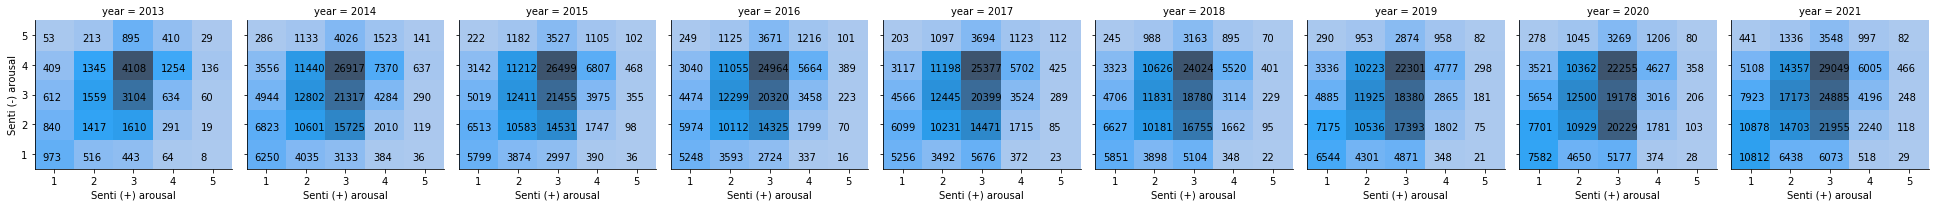

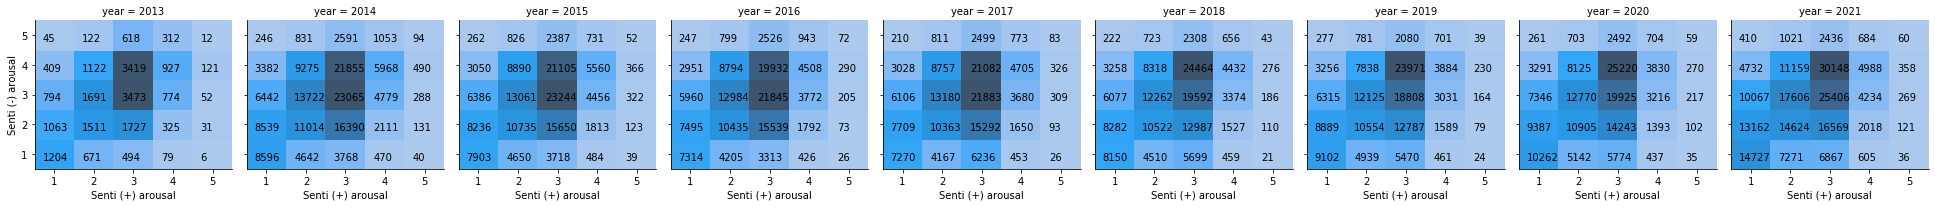

In [79]:
# SentiStrength

# # Wrangle SS categories
# categories=[1,2,3,4,5]
# for i,val in enumerate(['pos','neg']):
#     for senti_model in ['all', 'adxs_only']:
#         to_plot_df[f'senti_{val}_arousal_{senti_model}'] = \
#             pd.Categorical(to_plot_df[f'senti_{val}_arousal_{senti_model}'],
#                            categories=categories,
#                            ordered=True)

# Create heatmap plots
for senti_model in ['all', 'adxs_only']:
    g = sns.FacetGrid(to_plot_df, col='year', aspect=1)
    g.map(sns.histplot, f'senti_pos_arousal_{senti_model}', f'senti_neg_arousal_{senti_model}')#, ci='sd')
    g.fig.axes[0].invert_yaxis()
    sns.despine()
    for i,col in enumerate(g.col_names):
        ax = g.axes.flat[i]
        x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
        for p_i,pos_level in enumerate(categories):
            for n_i,neg_level in enumerate(categories):
                ax.annotate(str(len(to_plot_df.loc[(to_plot_df['year']==col) &
                                                   (to_plot_df[f'senti_pos_arousal_{senti_model}']==pos_level) &
                                                   (to_plot_df[f'senti_neg_arousal_{senti_model}']==neg_level)])),
                            xy=(x_locs[p_i]+0.7,y_locs[n_i]+0.8))
        g.axes[0,i].set_xlabel('Senti (+) arousal')
    g.axes[0,0].set_ylabel('Senti (-) arousal')
    plt.savefig(f'figs/senti_dist_over_time_subtrees_{corp_name}_{senti_model}.png',
                dpi=150,bbox_inches="tight")

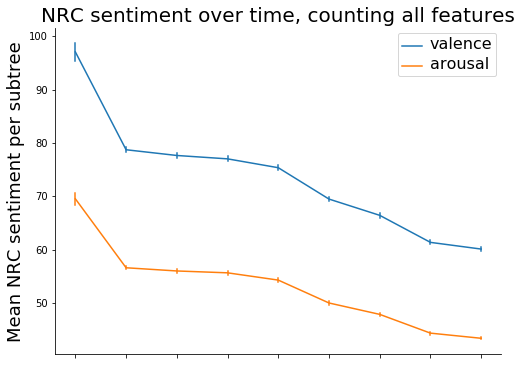

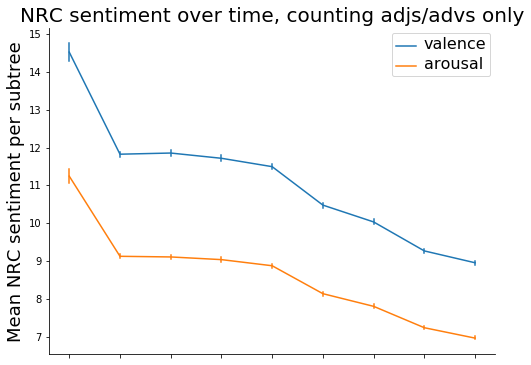

In [82]:
# NRC

for model in ['all','adxs_only']:

    fig, ax = plt.subplots(figsize=(8,6))
    sns.lineplot(data=to_plot_df, x='year', y=f'nrc_val_{model}', ax=ax, label='valence', 
                 estimator='mean', err_style='bars')
    sns.lineplot(data=to_plot_df, x='year', y=f'nrc_arousal_{model}', ax=ax, label='arousal', 
                 estimator='mean', err_style='bars')
    sns.despine()
    plt.setp(ax.get_legend().get_texts(), fontsize='16') 
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=16)
    ax.set_ylabel('Mean NRC sentiment per subtree',fontsize=18)
    ax.set_title(f'NRC sentiment over time, counting {model2title[model]}', fontsize=20)
    #plt.setp(gfg.get_legend().get_title(), fontsize='20')
    plt.savefig(f'figs/nrc_dist_over_time_subtrees_{corp_name}_{model}.png',dpi=150,bbox_inches="tight")

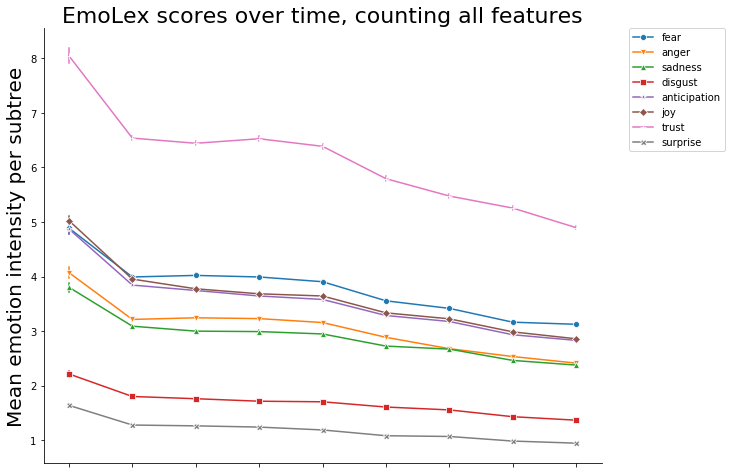

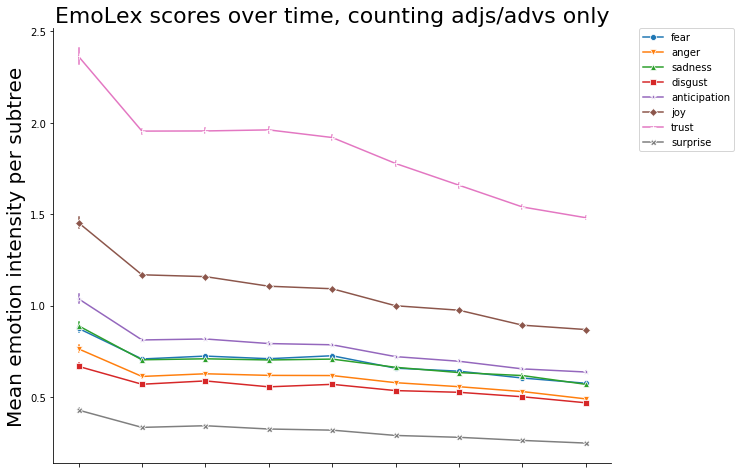

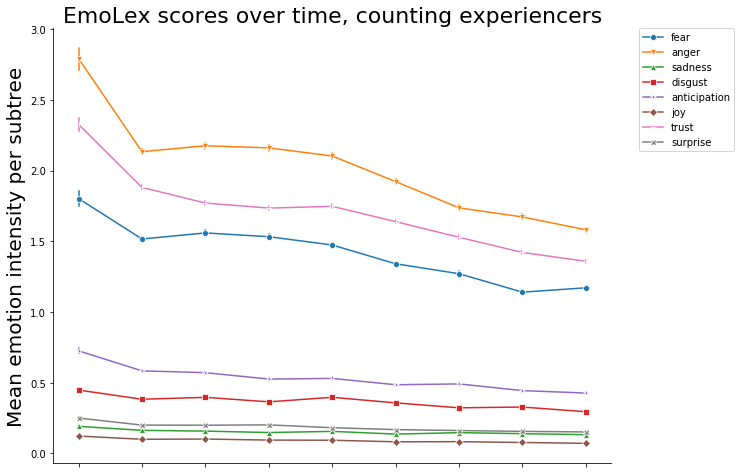

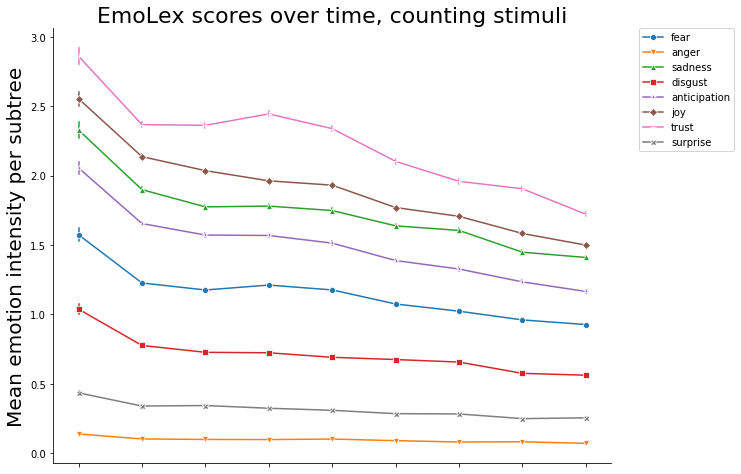

In [84]:
# EmoLex

for model in ['all','adxs_only','exp','stim']:
    
    fig, ax = plt.subplots(figsize=(10,8))
    for i,emo in enumerate(EMOLEX_EMOS):
        sns.lineplot(data=to_plot_df, x='year', y=f'emo_{emo}_{model}', ax=ax, label=emo, 
                     estimator='mean', err_style='bars', marker=emo_markers[i])
    sns.despine()
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax.set_ylabel("Mean emotion intensity per subtree", fontsize=20)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    ax.set_title(f"EmoLex scores over time, counting {model2title[model]}", fontsize=22)
    plt.savefig(f'figs/emolex_dist_over_time_subtrees_{corp_name}_{model}.png',dpi=150,bbox_inches="tight")

In order labels: ['harm_virtue', 'harm_vice', 'loyalty_virtue', 'loyalty_vice', 'purity_virtue', 'fairness_virtue', 'fairness_vice', 'purity_vice', 'authority_vice', 'loyalty_vice']
In order labels: ['fairness_vice', 'fairness_virtue', 'purity_vice', 'harm_virtue', 'purity_virtue', 'authority_virtue', 'harm_vice', 'loyalty_virtue', 'authority_vice', 'loyalty_vice']


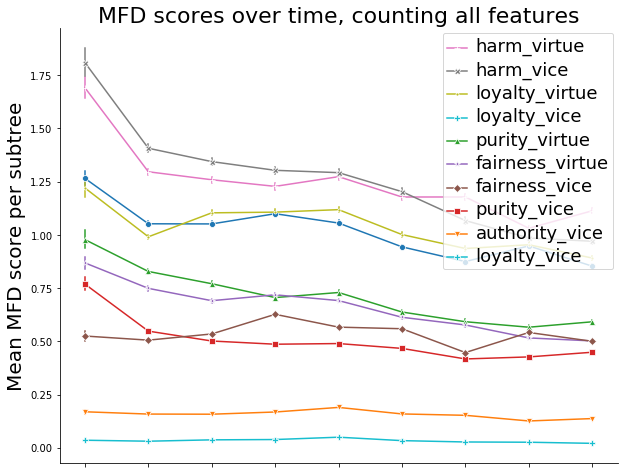

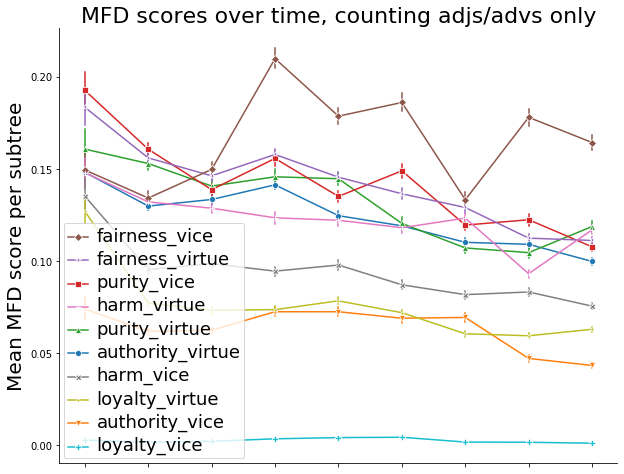

In [73]:
# MFD

model2hue_order = {'all': ['harm_virtue','harm_vice','loyalty_virtue','loyalty_vice',
                           'purity_virtue','fairness_virtue','fairness_vice','purity_vice',
                           'authority_vice','loyalty_vice'],
                   'adxs_only': ['fairness_vice','fairness_virtue','purity_vice','harm_virtue',
                                 'purity_virtue','authority_virtue','harm_vice','loyalty_virtue',
                                 'authority_vice','loyalty_vice']}

for model in ['all','adxs_only']:
    
    fig, ax = plt.subplots(figsize=(10,8))
    for i,found in enumerate(MFD_FOUNDS):
        sns.lineplot(data=to_plot_df, x='year', y=f'mfd_{found}_{model}', ax=ax, label=found, 
                     estimator='mean', err_style='bars', marker=mfd_markers[i])
    sns.despine()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    handles,labels = ax.get_legend_handles_labels()
    label2handle = dict(zip(labels,handles))
    in_order_labels = model2hue_order[model]
    print("In order labels:", in_order_labels)
    in_order_handles = [label2handle[l] for l in in_order_labels]
    ax.legend(handles=in_order_handles, labels=in_order_labels)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    ax.set_ylabel("Mean MFD score per subtree", fontsize=20)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    ax.set_title(f"MFD scores over time, counting {model2title[model]}", fontsize=22)
    plt.savefig(f'figs/mfd_dist_over_time_subtrees_{corp_name}_{model}.png',dpi=150,bbox_inches="tight")

## Synchronic distributions

### OP vs. challenger (comment-level)

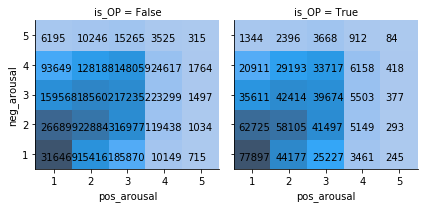

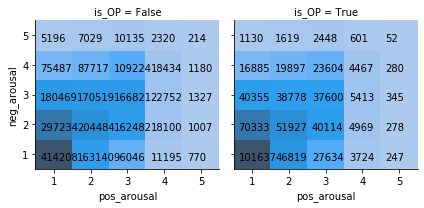

In [15]:
# SentiStrength

for model in ['all','adxs_only']:
    plot_df = plot_dfs[model]

    g = sns.FacetGrid(plot_df, col='is_OP', aspect=1)
    g.map(sns.histplot, 'pos_arousal', 'neg_arousal')#, ci='sd')
    g.fig.axes[0].invert_yaxis()
    sns.despine()
    for i,col in enumerate(g.col_names):
        ax = g.axes.flat[i]
        x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
        for p_i,pos_level in enumerate(categories):
            for n_i,neg_level in enumerate(categories):
                ax.annotate(str(len(to_plot_df.loc[(plot_df['is_OP']==col) &
                                                   (plot_df['pos_arousal']==pos_level) &
                                                   (plot_df['neg_arousal']==neg_level)])),
                            xy=(x_locs[p_i]+0.63,y_locs[n_i]+0.8))

    #
    plt.savefig(f'figs/senti_dist_OP_challenger_{corp_name}_{model}.png',
                dpi=150,bbox_inches="tight")

True     100000
False    100000
Name: is_OP, dtype: int64
True     100000
False    100000
Name: is_OP, dtype: int64


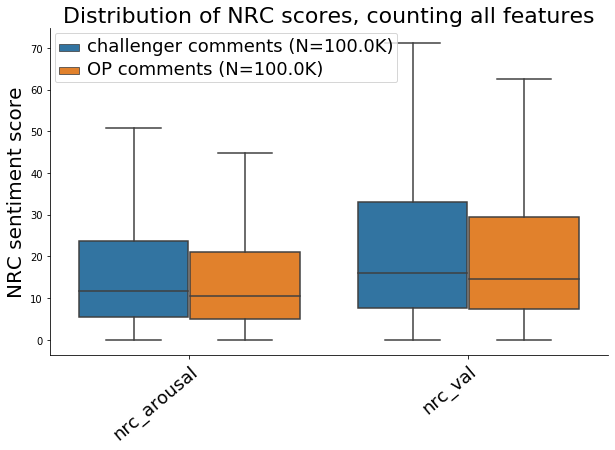

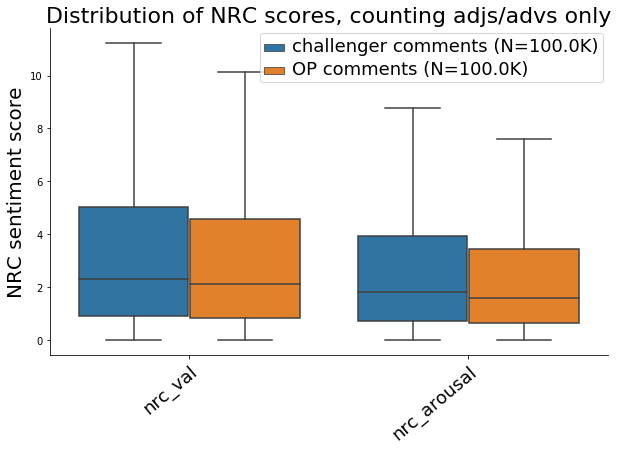

In [70]:
# NRC

for model in ['all','adxs_only']:
    plot_df = plot_dfs[model]#.sample(frac=0.1)
    sub_df = plot_df[['id','nrc_arousal','nrc_val']]
    sub_df = pd.melt(sub_df, id_vars=['id'], value_vars=['nrc_arousal','nrc_val'])
    sub_df['is_OP'] = sub_df['id'].apply(lambda x: is_OP_utt(corp_to_analyze['full_cmv'], get_utt(x)))
    sub_df = pd.concat([sub_df.loc[sub_df['is_OP']].sample(n=100000),
                        sub_df.loc[~sub_df['is_OP']].sample(n=100000)])
    counts_OP_challenger = sub_df['is_OP'].value_counts()
    print(counts_OP_challenger)
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(data=sub_df, x='variable', y='value', hue='is_OP', ax=ax, showfliers=False)
    sns.despine()
    
    label2display_text = {'False':f'challenger comments (N={abbreviate_N(counts_OP_challenger[False])})',
                          'True':f'OP comments (N={abbreviate_N(counts_OP_challenger[True])})'}
    handles,labels = ax.get_legend_handles_labels()
    label2handle = dict(zip(labels,handles))
#     in_order_labels = model2hue_order[model]
#     print("In order labels:", in_order_labels)
#     in_order_handles = [label2handle[l] for l in in_order_labels]
    ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])#,
              #bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    ax.set_ylabel("NRC sentiment score", fontsize=20)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    ax.set_title(f"Distribution of NRC scores, counting {model2title[model]}", fontsize=22)
    plt.savefig(f'figs/nrc_dist_OP_challenger_{corp_name}_{model}.png',dpi=150,bbox_inches="tight")

True     100000
False    100000
Name: is_OP, dtype: int64
True     100000
False    100000
Name: is_OP, dtype: int64
True     100000
False    100000
Name: is_OP, dtype: int64
True     100000
False    100000
Name: is_OP, dtype: int64


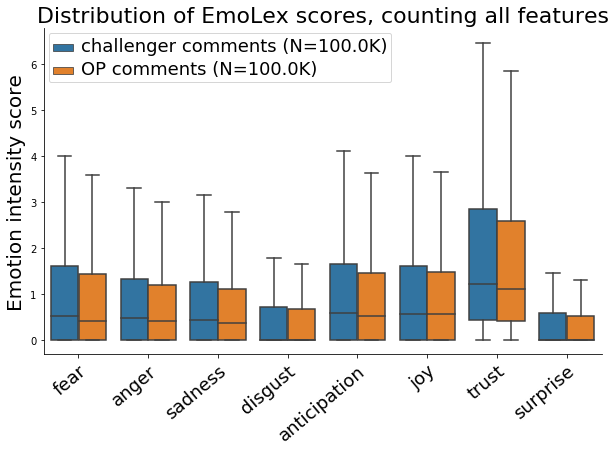

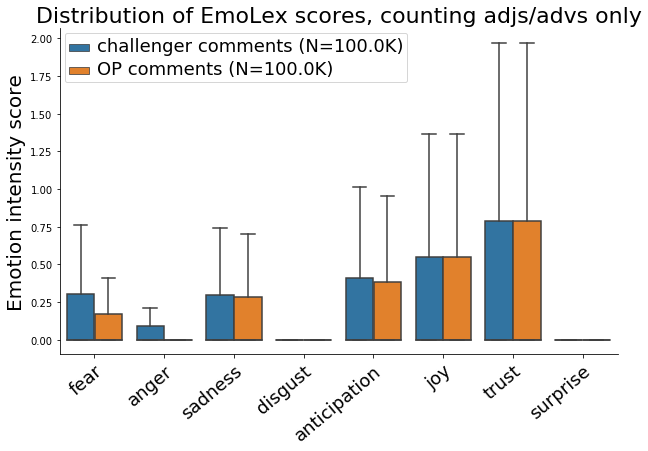

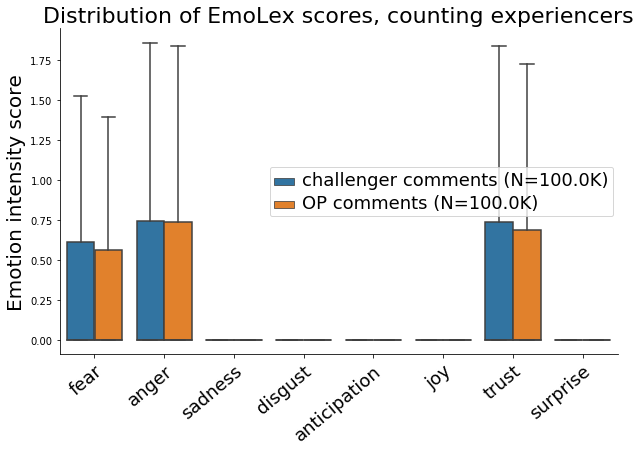

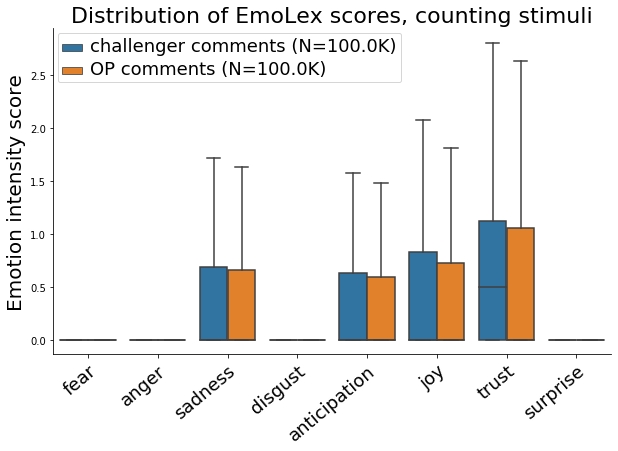

In [79]:
# EmoLex

for model in ['all','adxs_only','exp','stim']:
    plot_df = plot_dfs[model]#.sample(frac=0.1)
    sub_df = plot_df[['id']+EMOLEX_EMOS]
    sub_df = pd.melt(sub_df, id_vars=['id'], value_vars=EMOLEX_EMOS)
    sub_df['is_OP'] = sub_df['id'].apply(lambda x: is_OP_utt(corp_to_analyze['full_cmv'], get_utt(x)))
    sub_df = pd.concat([sub_df.loc[sub_df['is_OP']].sample(n=100000),
                        sub_df.loc[~sub_df['is_OP']].sample(n=100000)])
    counts_OP_challenger = sub_df['is_OP'].value_counts()
    print(counts_OP_challenger)
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(data=sub_df, x='variable', y='value', hue='is_OP', ax=ax, showfliers=False,
                order=EMOLEX_EMOS)
    sns.despine()
    
    label2display_text = {'False':f'challenger comments (N={abbreviate_N(counts_OP_challenger[False])})',
                          'True':f'OP comments (N={abbreviate_N(counts_OP_challenger[True])})'}
    handles,labels = ax.get_legend_handles_labels()
    label2handle = dict(zip(labels,handles))
#     in_order_labels = model2hue_order[model]
#     print("In order labels:", in_order_labels)
#     in_order_handles = [label2handle[l] for l in in_order_labels]
    ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])#,
              #bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    ax.set_ylabel("Emotion intensity score", fontsize=20)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, 
                       rotation=40, ha="right",rotation_mode='anchor')
    ax.set_title(f"Distribution of EmoLex scores, counting {model2title[model]}", fontsize=22)
    plt.savefig(f'figs/emolex_dist_OP_challenger_{corp_name}_{model}.png',dpi=150,bbox_inches="tight")

True     100000
False    100000
Name: is_OP, dtype: int64
True     100000
False    100000
Name: is_OP, dtype: int64


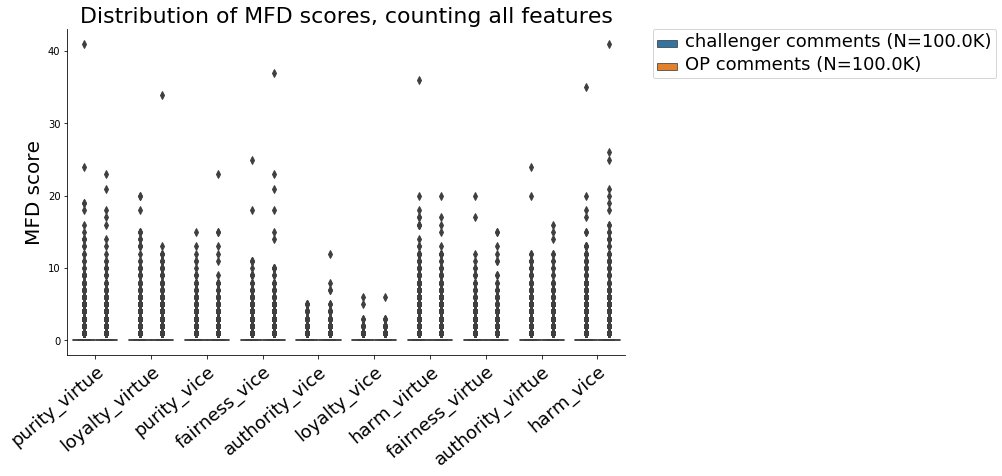

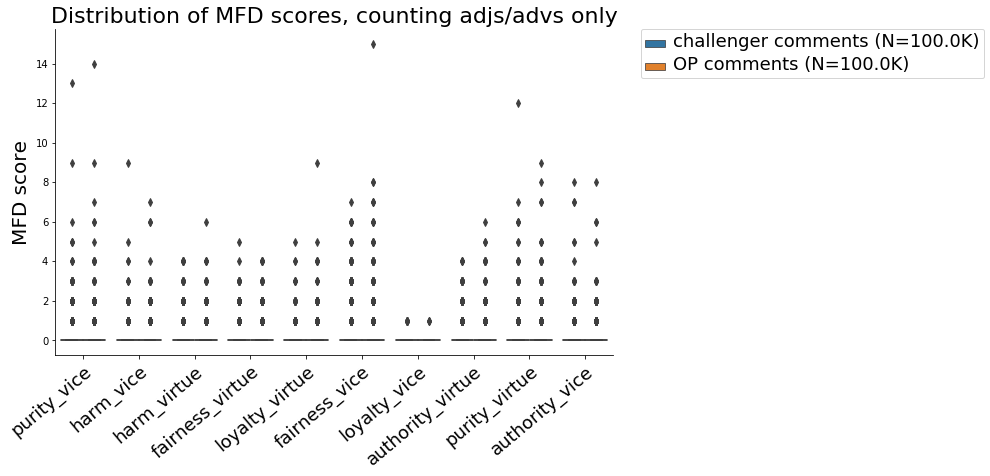

In [56]:
# MFD

for model in ['all','adxs_only']:
    plot_df = plot_dfs[model]#.sample(frac=0.1)
    sub_df = plot_df[['id']+MFD_FOUNDS]
    sub_df = pd.melt(sub_df, id_vars=['id'], value_vars=MFD_FOUNDS)
    sub_df['is_OP'] = sub_df['id'].apply(lambda x: is_OP_utt(corp_to_analyze['full_cmv'], get_utt(x)))
    sub_df = pd.concat([sub_df.loc[sub_df['is_OP']].sample(n=100000),
                        sub_df.loc[~sub_df['is_OP']].sample(n=100000)])
    counts_OP_challenger = sub_df['is_OP'].value_counts()
    print(counts_OP_challenger)
    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(data=sub_df, x='variable', y='value', hue='is_OP', ax=ax, showfliers=True)
    sns.despine()
    
    label2display_text = {'False':f'challenger comments (N={abbreviate_N(counts_OP_challenger[False])})',
                          'True':f'OP comments (N={abbreviate_N(counts_OP_challenger[True])})'}
    handles,labels = ax.get_legend_handles_labels()
    label2handle = dict(zip(labels,handles))
#     in_order_labels = model2hue_order[model]
#     print("In order labels:", in_order_labels)
#     in_order_handles = [label2handle[l] for l in in_order_labels]
    ax.legend(handles=handles, labels=[label2display_text[l] for l in labels],
              bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    ax.set_ylabel("MFD score", fontsize=20)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, 
                       rotation=40, ha="right",rotation_mode='anchor')
    ax.set_title(f"Distribution of MFD scores, counting {model2title[model]}", fontsize=22)
    plt.savefig(f'figs/mfd_dist_OP_challenger_{corp_name}_{model}.png',dpi=150,bbox_inches="tight")

### +Delta vs. -Delta subtrees (comment-level)

In [59]:
# Create dict to map a comment's ID onto whether or not it belongs to a +delta subtree

subtree_outcome_id2utt_ids = {'with_OP': defaultdict(set), 'no_OP': defaultdict(set)}
for utt in tqdm(subtree_outcome_utts):
    outcome = utt.meta['outcome']
    utts_to_outcome = utt.meta['path_to_outcome']
    utts_to_outcome_OP_removed = utt.meta['path_to_outcome_OP_removed']
    subtree_outcome_id2utt_ids['with_OP'][outcome] |= set(utts_to_outcome)
    subtree_outcome_id2utt_ids['no_OP'][outcome] |= set(utts_to_outcome_OP_removed)

100%|██████████| 1203509/1203509 [00:12<00:00, 94312.31it/s]


=========================all=========================
=========================with_OP=========================
=========================all=========================
=========================no_OP=========================
=========================adxs_only=========================
=========================with_OP=========================
=========================adxs_only=========================
=========================no_OP=========================


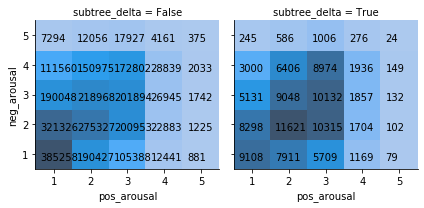

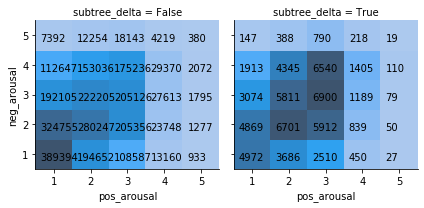

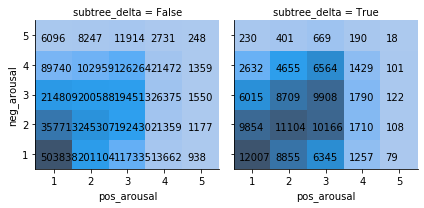

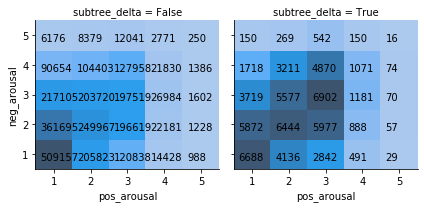

In [77]:
# SentiStrength

for model in ['all','adxs_only']:
    plot_df = plot_dfs[model]
    
    for with_OP in [True, False]:
        OP_key = 'with_OP' if with_OP else 'no_OP'
        plot_df['subtree_delta'] = plot_df['id'].apply(
            lambda x: x in subtree_outcome_id2utt_ids[OP_key]['+delta'])

        g = sns.FacetGrid(plot_df, col='subtree_delta', aspect=1)
        g.map(sns.histplot, 'pos_arousal', 'neg_arousal')#, ci='sd')
        g.fig.axes[0].invert_yaxis()
        sns.despine()
        for i,col in enumerate(g.col_names):
            ax = g.axes.flat[i]
            x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
            for p_i,pos_level in enumerate(categories):
                for n_i,neg_level in enumerate(categories):
                    ax.annotate(str(len(to_plot_df.loc[(plot_df['subtree_delta']==col) &
                                                       (plot_df['pos_arousal']==pos_level) &
                                                       (plot_df['neg_arousal']==neg_level)])),
                                xy=(x_locs[p_i]+0.63,y_locs[n_i]+0.8))

        print('='*25+model+'='*25)
        print('='*25+OP_key+'='*25)
        plt.savefig(f'figs/senti_dist_+_vs_-_delta_subtree_comments_{OP_key}_{corp_name}_{model}.png',
                    dpi=150,bbox_inches="tight")

True     209836
False    209836
Name: subtree_delta, dtype: int64
True     125888
False    125888
Name: subtree_delta, dtype: int64
True     209836
False    209836
Name: subtree_delta, dtype: int64
True     125888
False    125888
Name: subtree_delta, dtype: int64


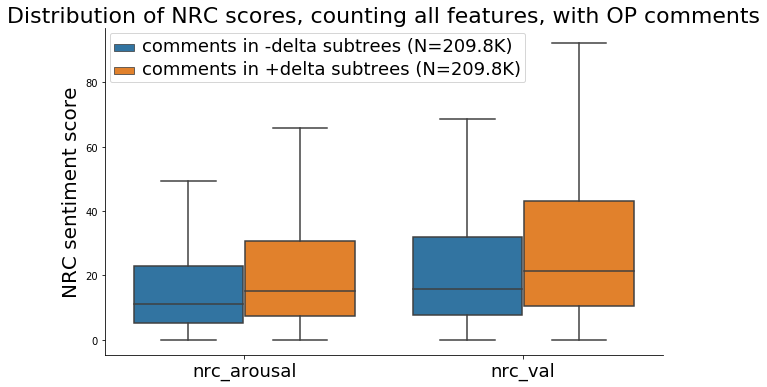

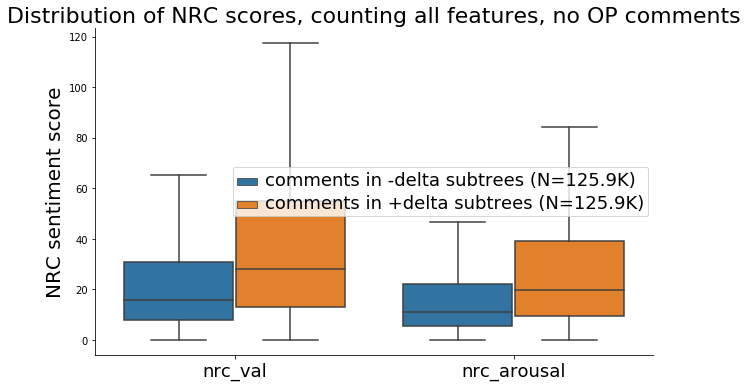

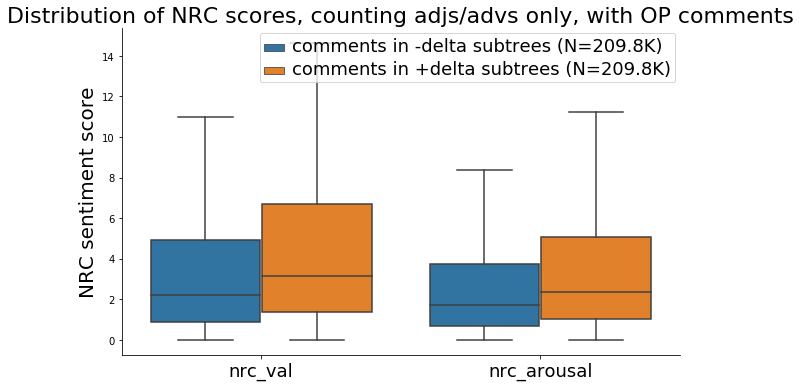

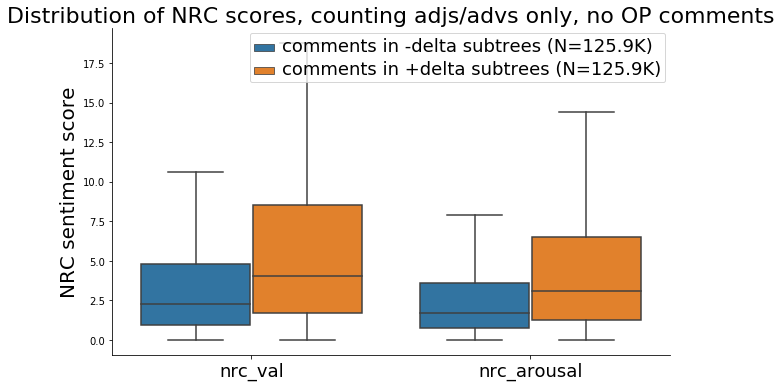

In [87]:
# NRC

for model in ['all','adxs_only']:
    plot_df = plot_dfs[model]#.sample(frac=0.1)
    sub_df = plot_df[['id','nrc_arousal','nrc_val']]
    sub_df = pd.melt(sub_df, id_vars=['id'], value_vars=['nrc_arousal','nrc_val'])
    
    for with_OP in [True, False]:
        OP_key = 'with_OP' if with_OP else 'no_OP'
        sub_df['subtree_delta'] = sub_df['id'].apply(
            lambda x: x in subtree_outcome_id2utt_ids[OP_key]['+delta'])
        counts_subtree_delta = sub_df['subtree_delta'].value_counts()
        min_ = min(counts_subtree_delta.values)
        sub_df = pd.concat([sub_df.loc[sub_df['subtree_delta']].sample(n=min_),
                            sub_df.loc[~sub_df['subtree_delta']].sample(n=min_)])
        counts_subtree_delta = sub_df['subtree_delta'].value_counts()
        print(counts_subtree_delta)
    
        fig, ax = plt.subplots(figsize=(10,6))
        sns.boxplot(data=sub_df, x='variable', y='value', hue='subtree_delta', ax=ax, showfliers=False)
        sns.despine()

        label2display_text = {'True':f'comments in +delta subtrees (N={abbreviate_N(counts_subtree_delta[True])})',
                              'False':f'comments in -delta subtrees (N={abbreviate_N(counts_subtree_delta[False])})'}
        handles,labels = ax.get_legend_handles_labels()
        label2handle = dict(zip(labels,handles))
    #     in_order_labels = model2hue_order[model]
    #     print("In order labels:", in_order_labels)
    #     in_order_handles = [label2handle[l] for l in in_order_labels]
        ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])#,
                  #bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.setp(ax.get_legend().get_texts(), fontsize='18')
        #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

        ax.set_ylabel("NRC sentiment score", fontsize=20)
        ax.set_xlabel("")
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
        ax.set_title(f"Distribution of NRC scores, counting {model2title[model]},\
        {OP_key.replace('_',' ')} comments", fontsize=22)
        plt.savefig(f'figs/nrc_dist_+vs-delta_subtree_comments_{OP_key}_{corp_name}_{model}.png',
                    dpi=150,bbox_inches="tight")

True     839344
False    839344
Name: subtree_delta, dtype: int64
True     503552
False    503552
Name: subtree_delta, dtype: int64
True     839344
False    839344
Name: subtree_delta, dtype: int64
True     503552
False    503552
Name: subtree_delta, dtype: int64
True     839344
False    839344
Name: subtree_delta, dtype: int64
True     503552
False    503552
Name: subtree_delta, dtype: int64
True     839344
False    839344
Name: subtree_delta, dtype: int64
True     503552
False    503552
Name: subtree_delta, dtype: int64


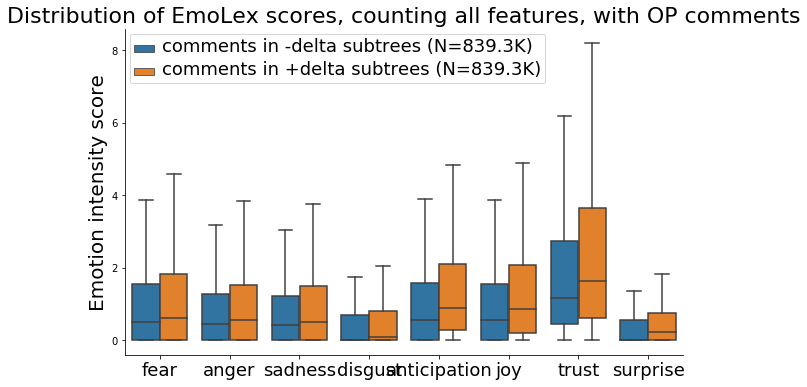

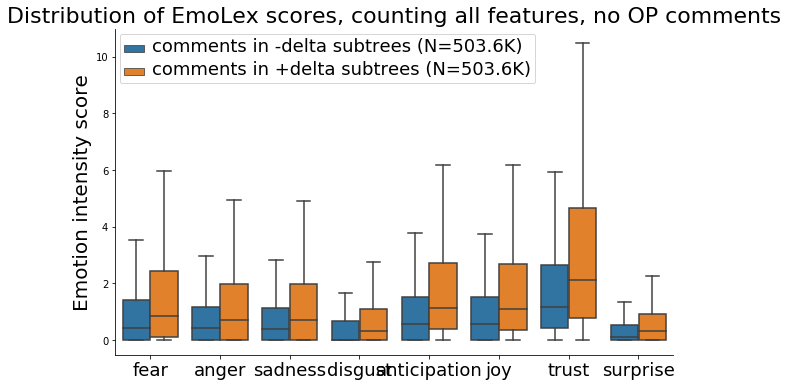

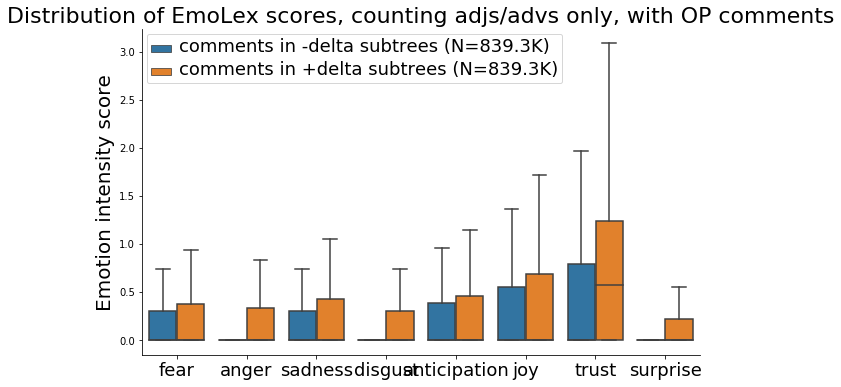

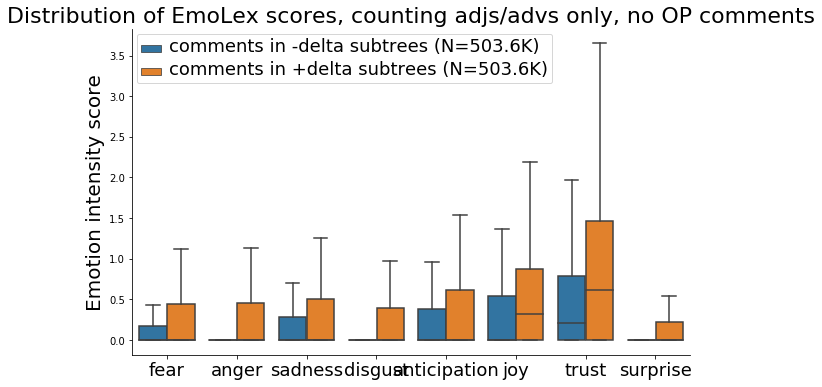

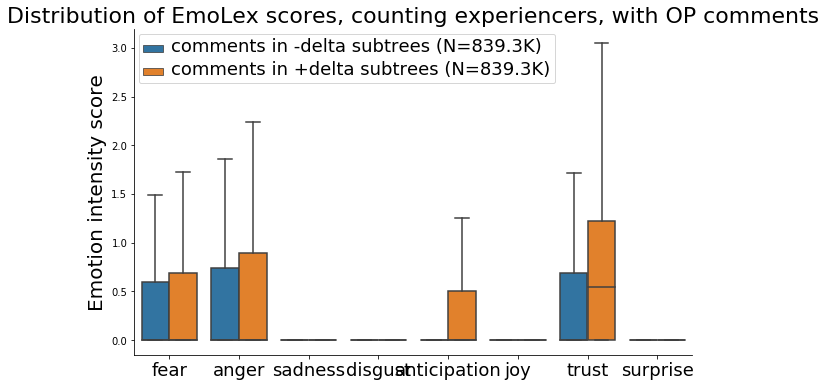

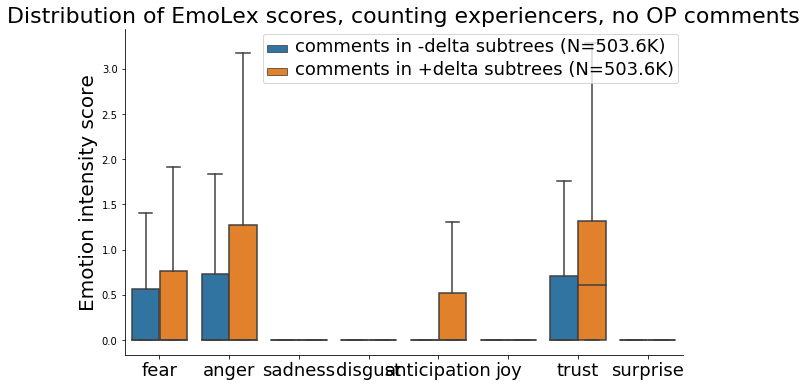

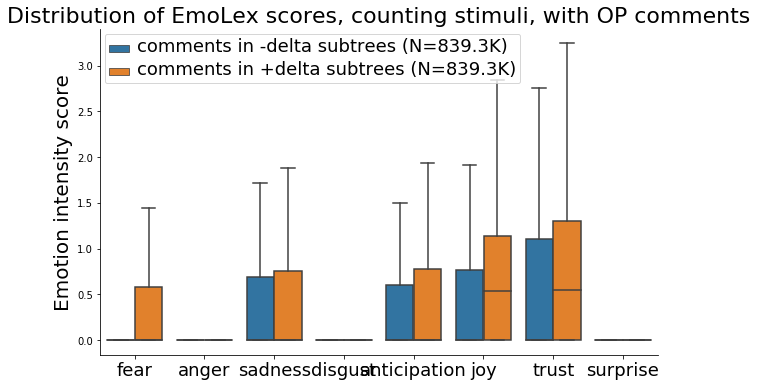

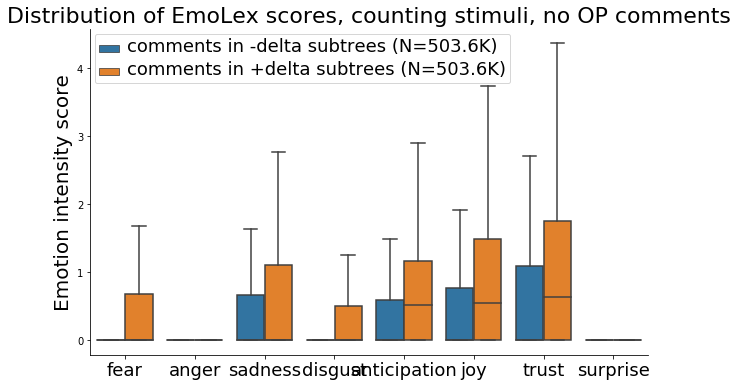

In [89]:
# EmoLex

for model in ['all','adxs_only','exp','stim']:
    plot_df = plot_dfs[model]#.sample(frac=0.1)
    sub_df = plot_df[['id']+EMOLEX_EMOS]
    sub_df = pd.melt(sub_df, id_vars=['id'], value_vars=EMOLEX_EMOS)
    
    for with_OP in [True, False]:
        OP_key = 'with_OP' if with_OP else 'no_OP'
        sub_df['subtree_delta'] = sub_df['id'].apply(
            lambda x: x in subtree_outcome_id2utt_ids[OP_key]['+delta'])
        counts_subtree_delta = sub_df['subtree_delta'].value_counts()
        min_ = min(counts_subtree_delta.values)
        sub_df = pd.concat([sub_df.loc[sub_df['subtree_delta']].sample(n=min_),
                            sub_df.loc[~sub_df['subtree_delta']].sample(n=min_)])
        counts_subtree_delta = sub_df['subtree_delta'].value_counts()
        print(counts_subtree_delta)
    
        fig, ax = plt.subplots(figsize=(10,6))
        sns.boxplot(data=sub_df, x='variable', y='value', hue='subtree_delta', ax=ax, showfliers=False,
                    order=EMOLEX_EMOS)
        sns.despine()

        label2display_text = {'False':f'comments in -delta subtrees (N={abbreviate_N(counts_subtree_delta[False])})',
                              'True':f'comments in +delta subtrees (N={abbreviate_N(counts_subtree_delta[True])})'}
        handles,labels = ax.get_legend_handles_labels()
        label2handle = dict(zip(labels,handles))
    #     in_order_labels = model2hue_order[model]
    #     print("In order labels:", in_order_labels)
    #     in_order_handles = [label2handle[l] for l in in_order_labels]
        ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])#,
                  #bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.setp(ax.get_legend().get_texts(), fontsize='18')
        #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

        ax.set_ylabel("Emotion intensity score", fontsize=20)
        ax.set_xlabel("")
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
        ax.set_title(f"Distribution of EmoLex scores, counting {model2title[model]}, {OP_key.replace('_',' ')} comments", fontsize=22)
        plt.savefig(f'figs/emolex_dist_+vs-delta_subtree_comments_{OP_key}_{corp_name}_{model}.png',
                    dpi=150,bbox_inches="tight")

True     1048700
False    1048700
Name: subtree_delta, dtype: int64
True     629070
False    629070
Name: subtree_delta, dtype: int64
True     1048700
False    1048700
Name: subtree_delta, dtype: int64
True     629070
False    629070
Name: subtree_delta, dtype: int64


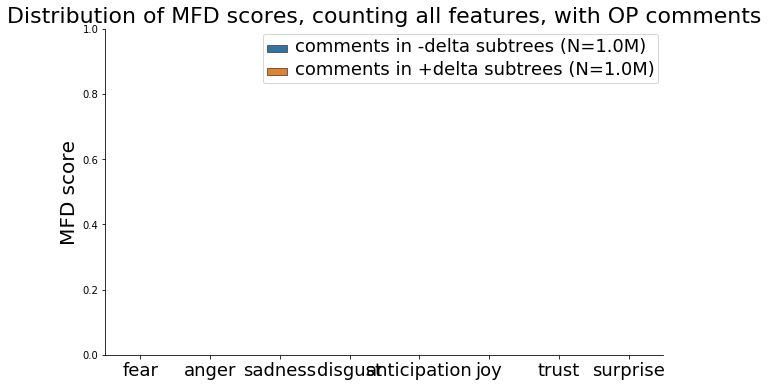

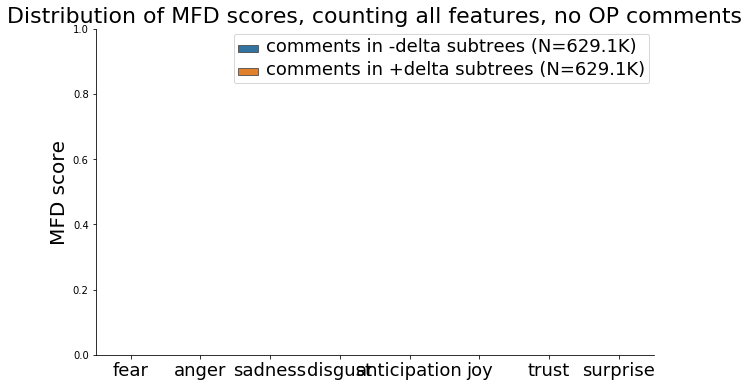

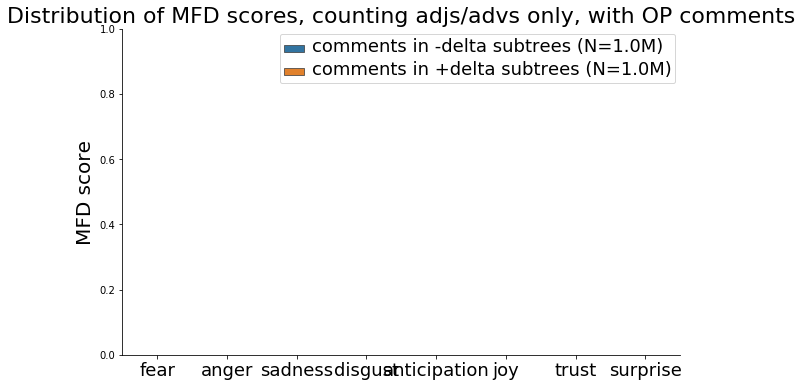

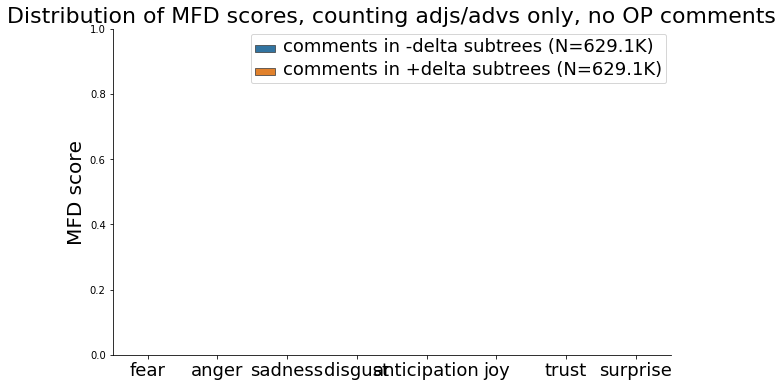

In [60]:
# MFD

for model in ['all','adxs_only']:
    plot_df = plot_dfs[model]#.sample(frac=0.1)
    sub_df = plot_df[['id']+MFD_FOUNDS]
    sub_df = pd.melt(sub_df, id_vars=['id'], value_vars=MFD_FOUNDS)
    
    for with_OP in [True, False]:
        OP_key = 'with_OP' if with_OP else 'no_OP'
        sub_df['subtree_delta'] = sub_df['id'].apply(
            lambda x: x in subtree_outcome_id2utt_ids[OP_key]['+delta'])
        counts_subtree_delta = sub_df['subtree_delta'].value_counts()
        min_ = min(counts_subtree_delta.values)
        sub_df = pd.concat([sub_df.loc[sub_df['subtree_delta']].sample(n=min_),
                            sub_df.loc[~sub_df['subtree_delta']].sample(n=min_)])
        counts_subtree_delta = sub_df['subtree_delta'].value_counts()
        print(counts_subtree_delta)
    
        fig, ax = plt.subplots(figsize=(10,6))
        sns.boxplot(data=sub_df, x='variable', y='value', hue='subtree_delta', ax=ax, showfliers=True,
                    order=EMOLEX_EMOS)
        sns.despine()

        label2display_text = {'False':f'comments in -delta subtrees (N={abbreviate_N(counts_subtree_delta[False])})',
                              'True':f'comments in +delta subtrees (N={abbreviate_N(counts_subtree_delta[True])})'}
        handles,labels = ax.get_legend_handles_labels()
        label2handle = dict(zip(labels,handles))
    #     in_order_labels = model2hue_order[model]
    #     print("In order labels:", in_order_labels)
    #     in_order_handles = [label2handle[l] for l in in_order_labels]
        ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])#,
                  #bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.setp(ax.get_legend().get_texts(), fontsize='18')
        #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

        ax.set_ylabel("MFD score", fontsize=20)
        ax.set_xlabel("")
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
        ax.set_title(f"Distribution of MFD scores, counting {model2title[model]}, {OP_key.replace('_',' ')} comments", fontsize=22)
        plt.savefig(f'figs/mfd_dist_+vs-delta_subtree_comments_{OP_key}_{corp_name}_{model}.png',
                    dpi=150,bbox_inches="tight")

### +Delta vs. -Delta subtrees (subtree-level)

In [69]:
corp_name = 'full_cmv'
outcome_counts = to_plot_df['outcome'].value_counts()
subtree_id2outcome = dict(zip(to_plot_df['subtree_outcome_utt_id'],to_plot_df['outcome']))

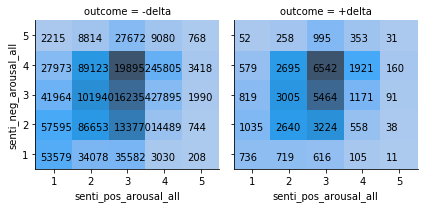

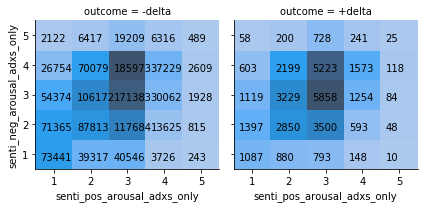

In [9]:
# SentiStrength

for model in ['all','adxs_only']:

    g = sns.FacetGrid(to_plot_df, col='outcome', aspect=1)
    g.map(sns.histplot, f'senti_pos_arousal_{model}', f'senti_neg_arousal_{model}')#, ci='sd')
    g.fig.axes[0].invert_yaxis()
    sns.despine()
    for i,col in enumerate(g.col_names):
        ax = g.axes.flat[i]
        x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
        for p_i,pos_level in enumerate(categories):
            for n_i,neg_level in enumerate(categories):
                ax.annotate(str(len(to_plot_df.loc[(to_plot_df['outcome']==col) &
                                                   (to_plot_df[f'senti_pos_arousal_{model}']==pos_level) &
                                                   (to_plot_df[f'senti_neg_arousal_{model}']==neg_level)])),
                            xy=(x_locs[p_i]+0.63,y_locs[n_i]+0.8))

    plt.savefig(f'figs/senti_dist_+_vs_-_delta_subtrees_{corp_name}_{model}.png',
                dpi=150,bbox_inches="tight")

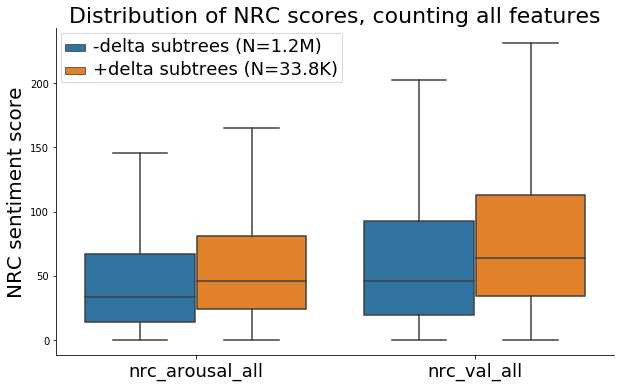

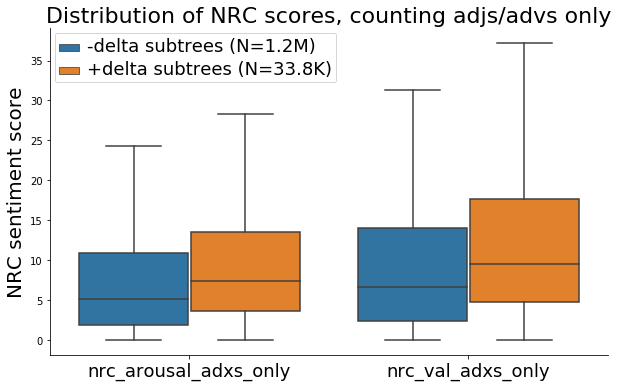

In [27]:
# NRC

for model in ['all','adxs_only']:
    sub_df = to_plot_df[['subtree_outcome_utt_id',f'nrc_arousal_{model}',f'nrc_val_{model}']]
    sub_df = pd.melt(sub_df, id_vars=['subtree_outcome_utt_id'], value_vars=[f'nrc_arousal_{model}',f'nrc_val_{model}'])
    sub_df['outcome'] = sub_df['subtree_outcome_utt_id'].apply(lambda x: subtree_id2outcome[x])
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(data=sub_df, x='variable', y='value', hue='outcome', ax=ax, showfliers=False)
    sns.despine()

    label2display_text = {'+delta':f"+delta subtrees (N={abbreviate_N(outcome_counts['+delta'])})",
                          '-delta':f"-delta subtrees (N={abbreviate_N(outcome_counts['-delta'])})"}
    handles,labels = ax.get_legend_handles_labels()
    label2handle = dict(zip(labels,handles))
#     in_order_labels = model2hue_order[model]
#     print("In order labels:", in_order_labels)
#     in_order_handles = [label2handle[l] for l in in_order_labels]
    ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])#,
              #bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    ax.set_ylabel("NRC sentiment score", fontsize=20)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    ax.set_title(f"Distribution of NRC scores, counting {model2title[model]}", fontsize=22)
    plt.savefig(f'figs/nrc_dist_+vs-delta_subtrees_{corp_name}_{model}.png',
                dpi=150,bbox_inches="tight")

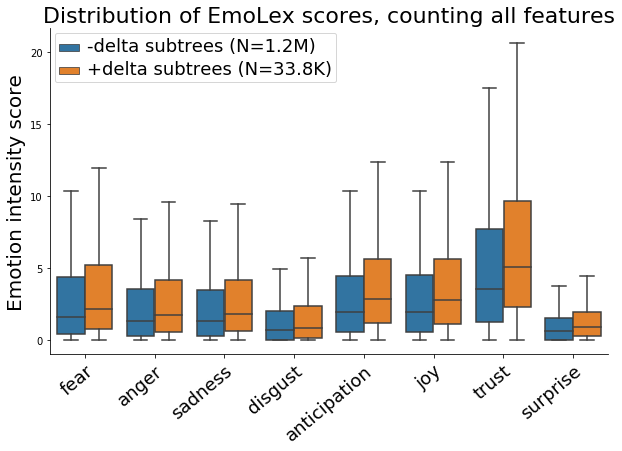

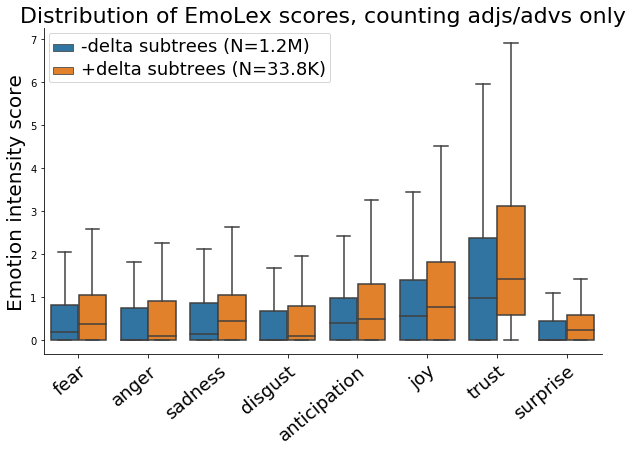

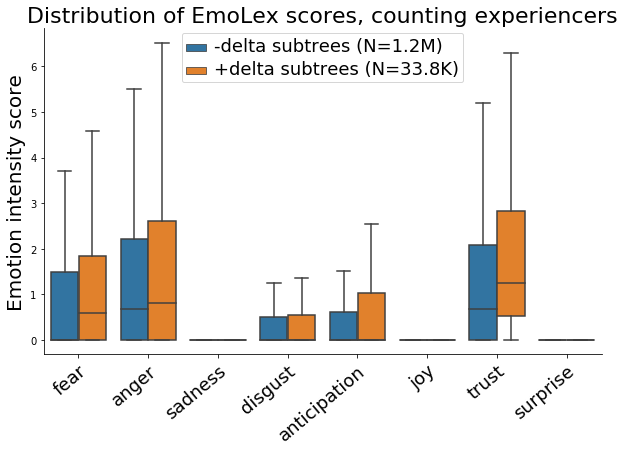

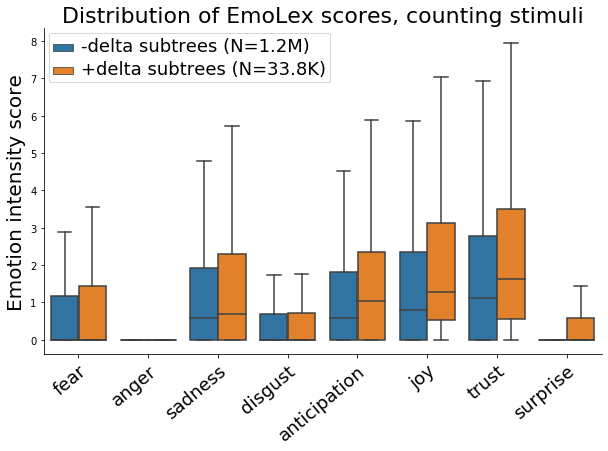

In [32]:
# EmoLex

for model in ['all','adxs_only','exp','stim']:
    sub_df = to_plot_df[['subtree_outcome_utt_id']+[f'emo_{emo}_{model}' for emo in EMOLEX_EMOS]]
    sub_df.columns = ['subtree_outcome_utt_id']+EMOLEX_EMOS
    sub_df = pd.melt(sub_df, id_vars=['subtree_outcome_utt_id'], value_vars=EMOLEX_EMOS)
    sub_df['outcome'] = sub_df['subtree_outcome_utt_id'].apply(lambda x: subtree_id2outcome[x])
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(data=sub_df, x='variable', y='value', hue='outcome', ax=ax, showfliers=False,
                order=EMOLEX_EMOS)
    sns.despine()

    label2display_text = {'+delta':f"+delta subtrees (N={abbreviate_N(outcome_counts['+delta'])})",
                          '-delta':f"-delta subtrees (N={abbreviate_N(outcome_counts['-delta'])})"}
    handles,labels = ax.get_legend_handles_labels()
    label2handle = dict(zip(labels,handles))
#     in_order_labels = model2hue_order[model]
#     print("In order labels:", in_order_labels)
#     in_order_handles = [label2handle[l] for l in in_order_labels]
    ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])#,
              #bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    ax.set_ylabel("Emotion intensity score", fontsize=20)
    ax.set_xlabel("")
    ax.set_xticklabels(EMOLEX_EMOS, fontsize=18, rotation=40, ha="right",rotation_mode='anchor')
    ax.set_title(f"Distribution of EmoLex scores, counting {model2title[model]}", fontsize=22)
    plt.savefig(f'figs/emolex_dist_+vs-delta_subtrees_{corp_name}_{model}.png',
                dpi=150,bbox_inches="tight")

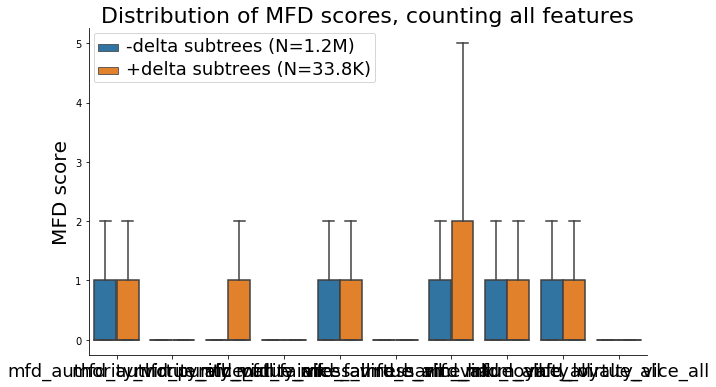

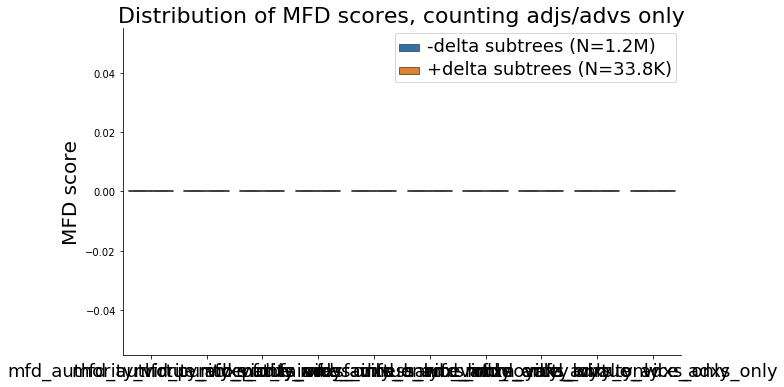

In [70]:
# MFD

for model in ['all','adxs_only']:
    sub_df = to_plot_df[['subtree_outcome_utt_id']+[f'mfd_{found}_{model}' for found in MFD_FOUNDS]]
    sub_df = pd.melt(sub_df, id_vars=['subtree_outcome_utt_id'], value_vars=[f'mfd_{found}_{model}' 
                                                                             for found in MFD_FOUNDS])
    sub_df['outcome'] = sub_df['subtree_outcome_utt_id'].apply(lambda x: subtree_id2outcome[x])
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(data=sub_df, x='variable', y='value', hue='outcome', ax=ax, showfliers=False)
    sns.despine()

    label2display_text = {'+delta':f"+delta subtrees (N={abbreviate_N(outcome_counts['+delta'])})",
                          '-delta':f"-delta subtrees (N={abbreviate_N(outcome_counts['-delta'])})"}
    handles,labels = ax.get_legend_handles_labels()
    label2handle = dict(zip(labels,handles))
#     in_order_labels = model2hue_order[model]
#     print("In order labels:", in_order_labels)
#     in_order_handles = [label2handle[l] for l in in_order_labels]
    ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])#,
              #bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    ax.set_ylabel("MFD score", fontsize=20)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    ax.set_title(f"Distribution of MFD scores, counting {model2title[model]}", fontsize=22)
    plt.savefig(f'figs/mfd_dist_+vs-delta_subtrees_{corp_name}_{model}.png',
                dpi=150,bbox_inches="tight")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
No handles with labels found to put in legend.


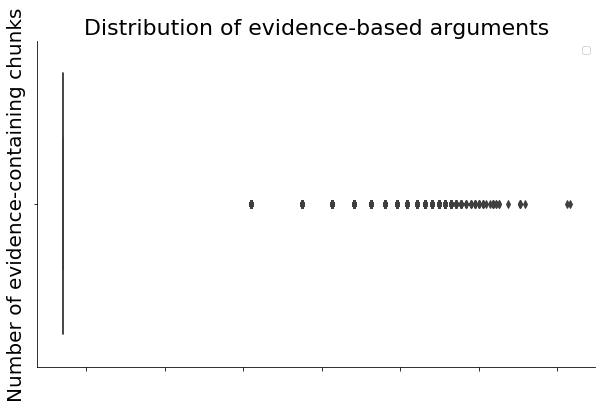

In [70]:
# Evidence

sub_df = to_plot_df[['outcome','subtree_outcome_utt_id','num_evidence_chunks']].copy()
sub_df['log_num_evidence_chunks'] = sub_df['num_evidence_chunks'].apply(lambda x: np.log(x+.1))
#sub_df = pd.melt(sub_df, id_vars=['subtree_outcome_utt_id'], value_vars=[f'emo_{emo}_{model}' for emo in EMOLEX_EMOS])
#sub_df['outcome'] = sub_df['subtree_outcome_utt_id'].apply(lambda x: subtree_id2outcome[x])

fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=sub_df, x='log_num_evidence_chunks', hue='outcome', ax=ax)#, showfliers=False)
sns.despine()

label2display_text = {'+delta':f"+delta subtrees (N={abbreviate_N(outcome_counts['+delta'])})",
                      '-delta':f"-delta subtrees (N={abbreviate_N(outcome_counts['-delta'])})"}
handles,labels = ax.get_legend_handles_labels()
label2handle = dict(zip(labels,handles))
#     in_order_labels = model2hue_order[model]
#     print("In order labels:", in_order_labels)
#     in_order_handles = [label2handle[l] for l in in_order_labels]
ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])#,
          #bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.setp(ax.get_legend().get_texts(), fontsize='18')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

ax.set_ylabel("Number of evidence-containing chunks", fontsize=20)
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_title(f"Distribution of evidence-based arguments", fontsize=22)
plt.savefig(f'figs/num_evidence_chunks_dist_+vs-delta_subtrees_{corp_name}.png',
            dpi=150,bbox_inches="tight")

### Across different topics (subtree-level)

# Examine correlations

In [ ]:
reg_df = pd.read_pickle('full_cmv_subtrees_reg_df.pkl') # excludes OP comments
print(reg_df.shape) # the # of (outcome) subtrees
display(reg_df.head(10))

In [90]:
del reg_df

NameError: name 'reg_df' is not defined

In [56]:
# Obtain overall measure of emotion intensity by taking the sum over all emotions

for model in ['all','adxs_only']:
    to_plot_df[f'emo_total_{model}'] = to_plot_df[f'emo_fear_{model}'] + to_plot_df[f'emo_anger_{model}'] + \
                                    to_plot_df[f'emo_sadness_{model}'] + to_plot_df[f'emo_disgust_{model}'] + \
                                    to_plot_df[f'emo_joy_{model}'] + to_plot_df[f'emo_anticipation_{model}'] + \
                                    to_plot_df[f'emo_trust_{model}'] + to_plot_df[f'emo_surprise_{model}']

In [59]:
# for model in ['all','adxs_only']:
#     reg_feats = ['outcome'] + \
#                 [f'senti_pos_arousal_{model}',f'senti_neg_arousal_{model}',
#                  f'nrc_val_{model}',f'nrc_arousal_{model}',
#                  f'emo_total_{model}'] + \
#                 ['num_evidence_chunks'] + \
#                 ['depth','total_num_words','mean_num_words','order','rel_timestamp','abs_timestamp']
#     print(model)
#     print(reg_feats)
#     print()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


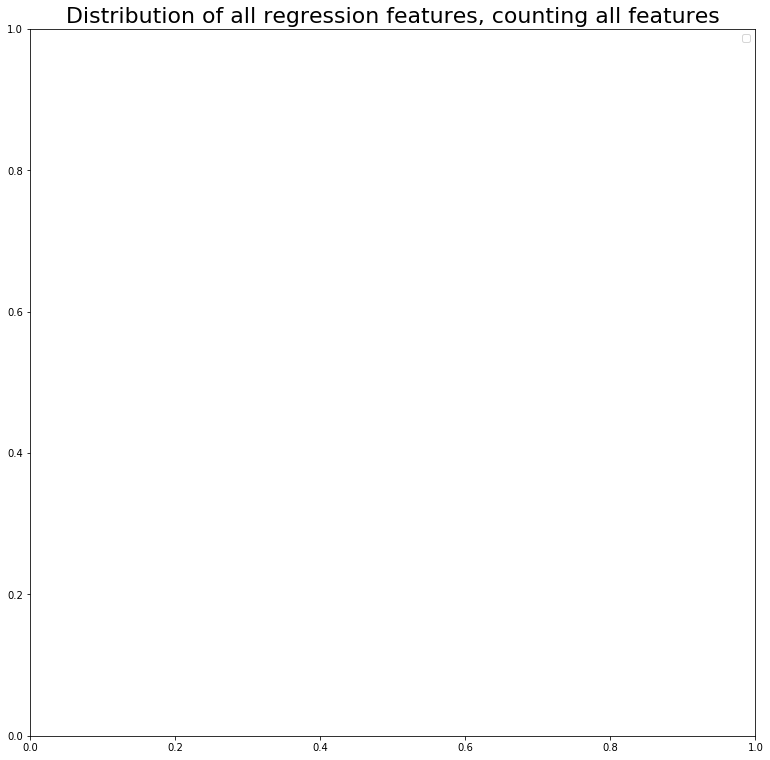

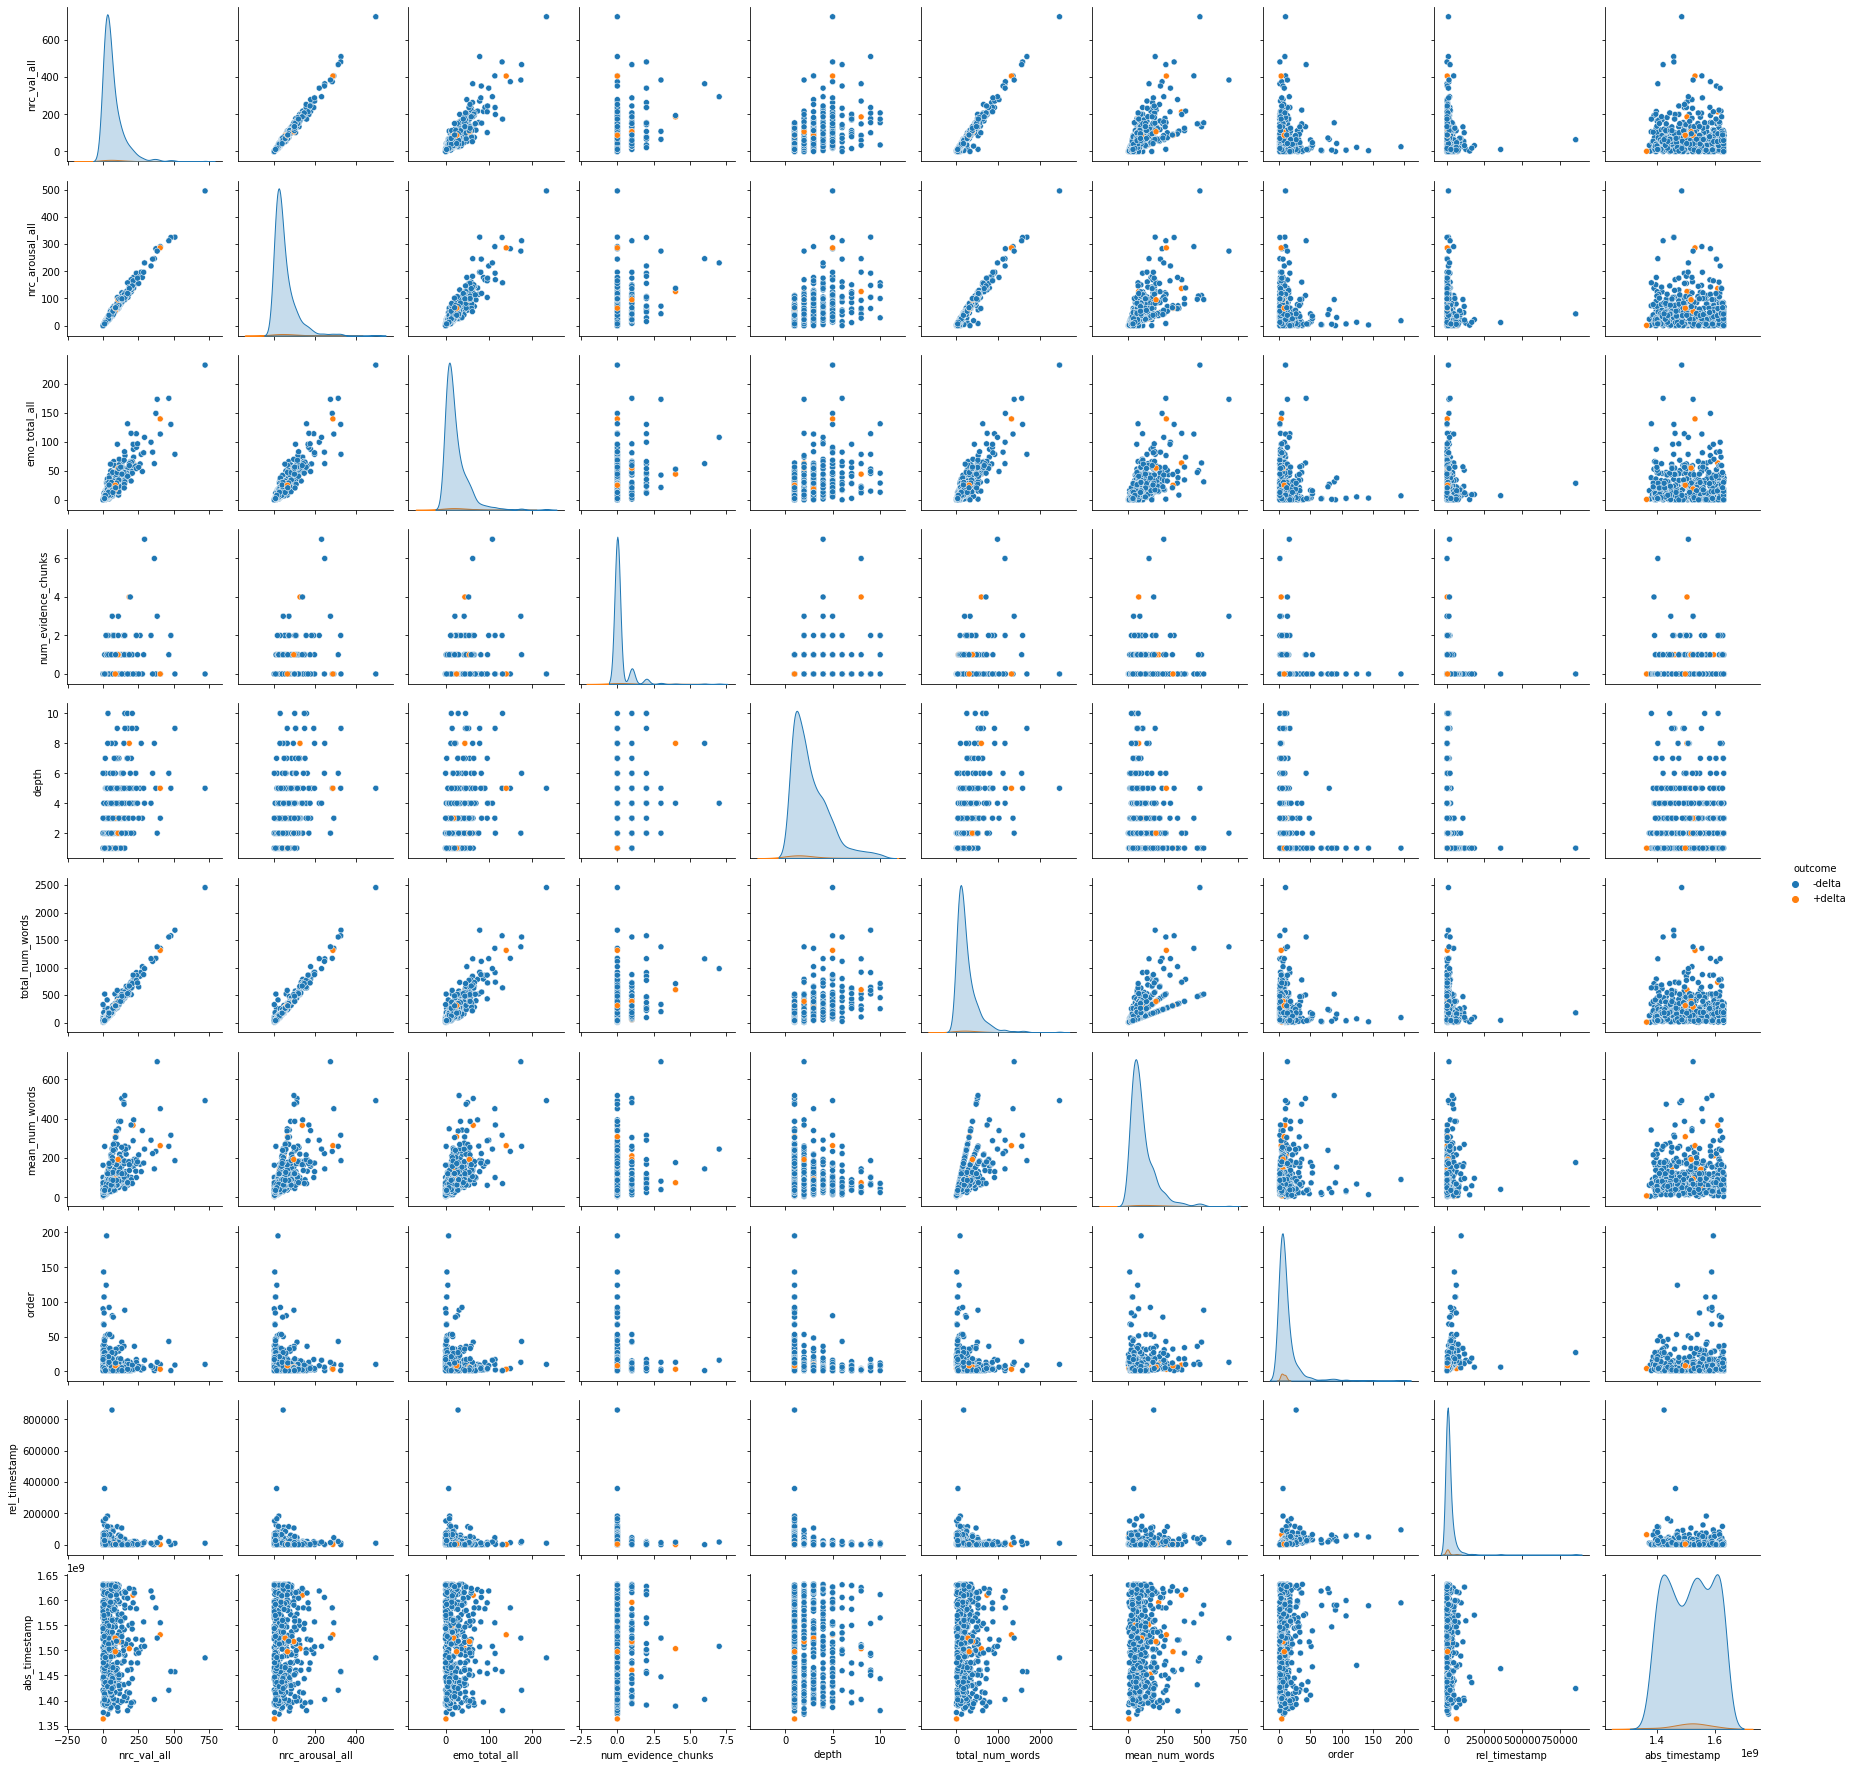

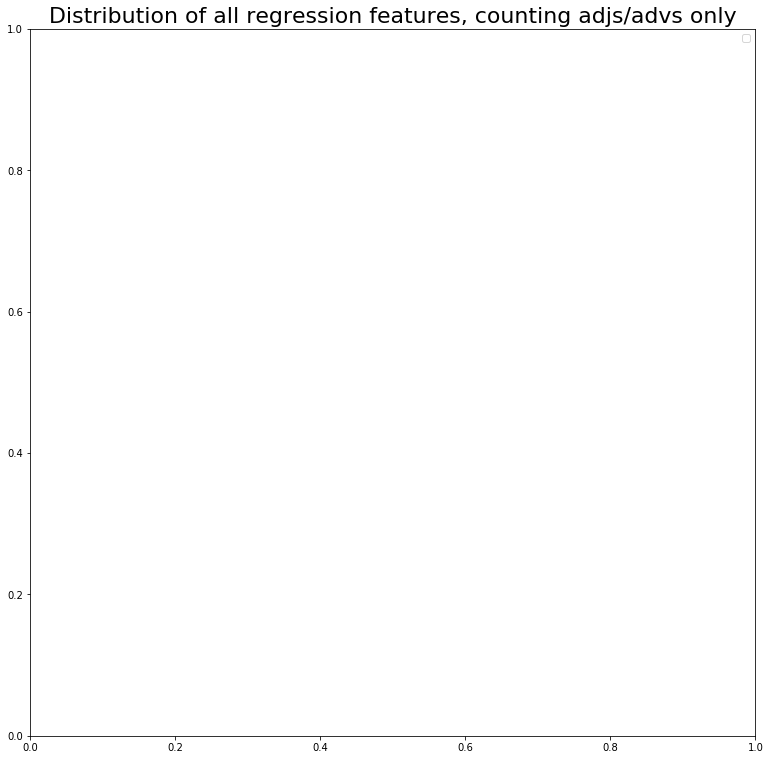

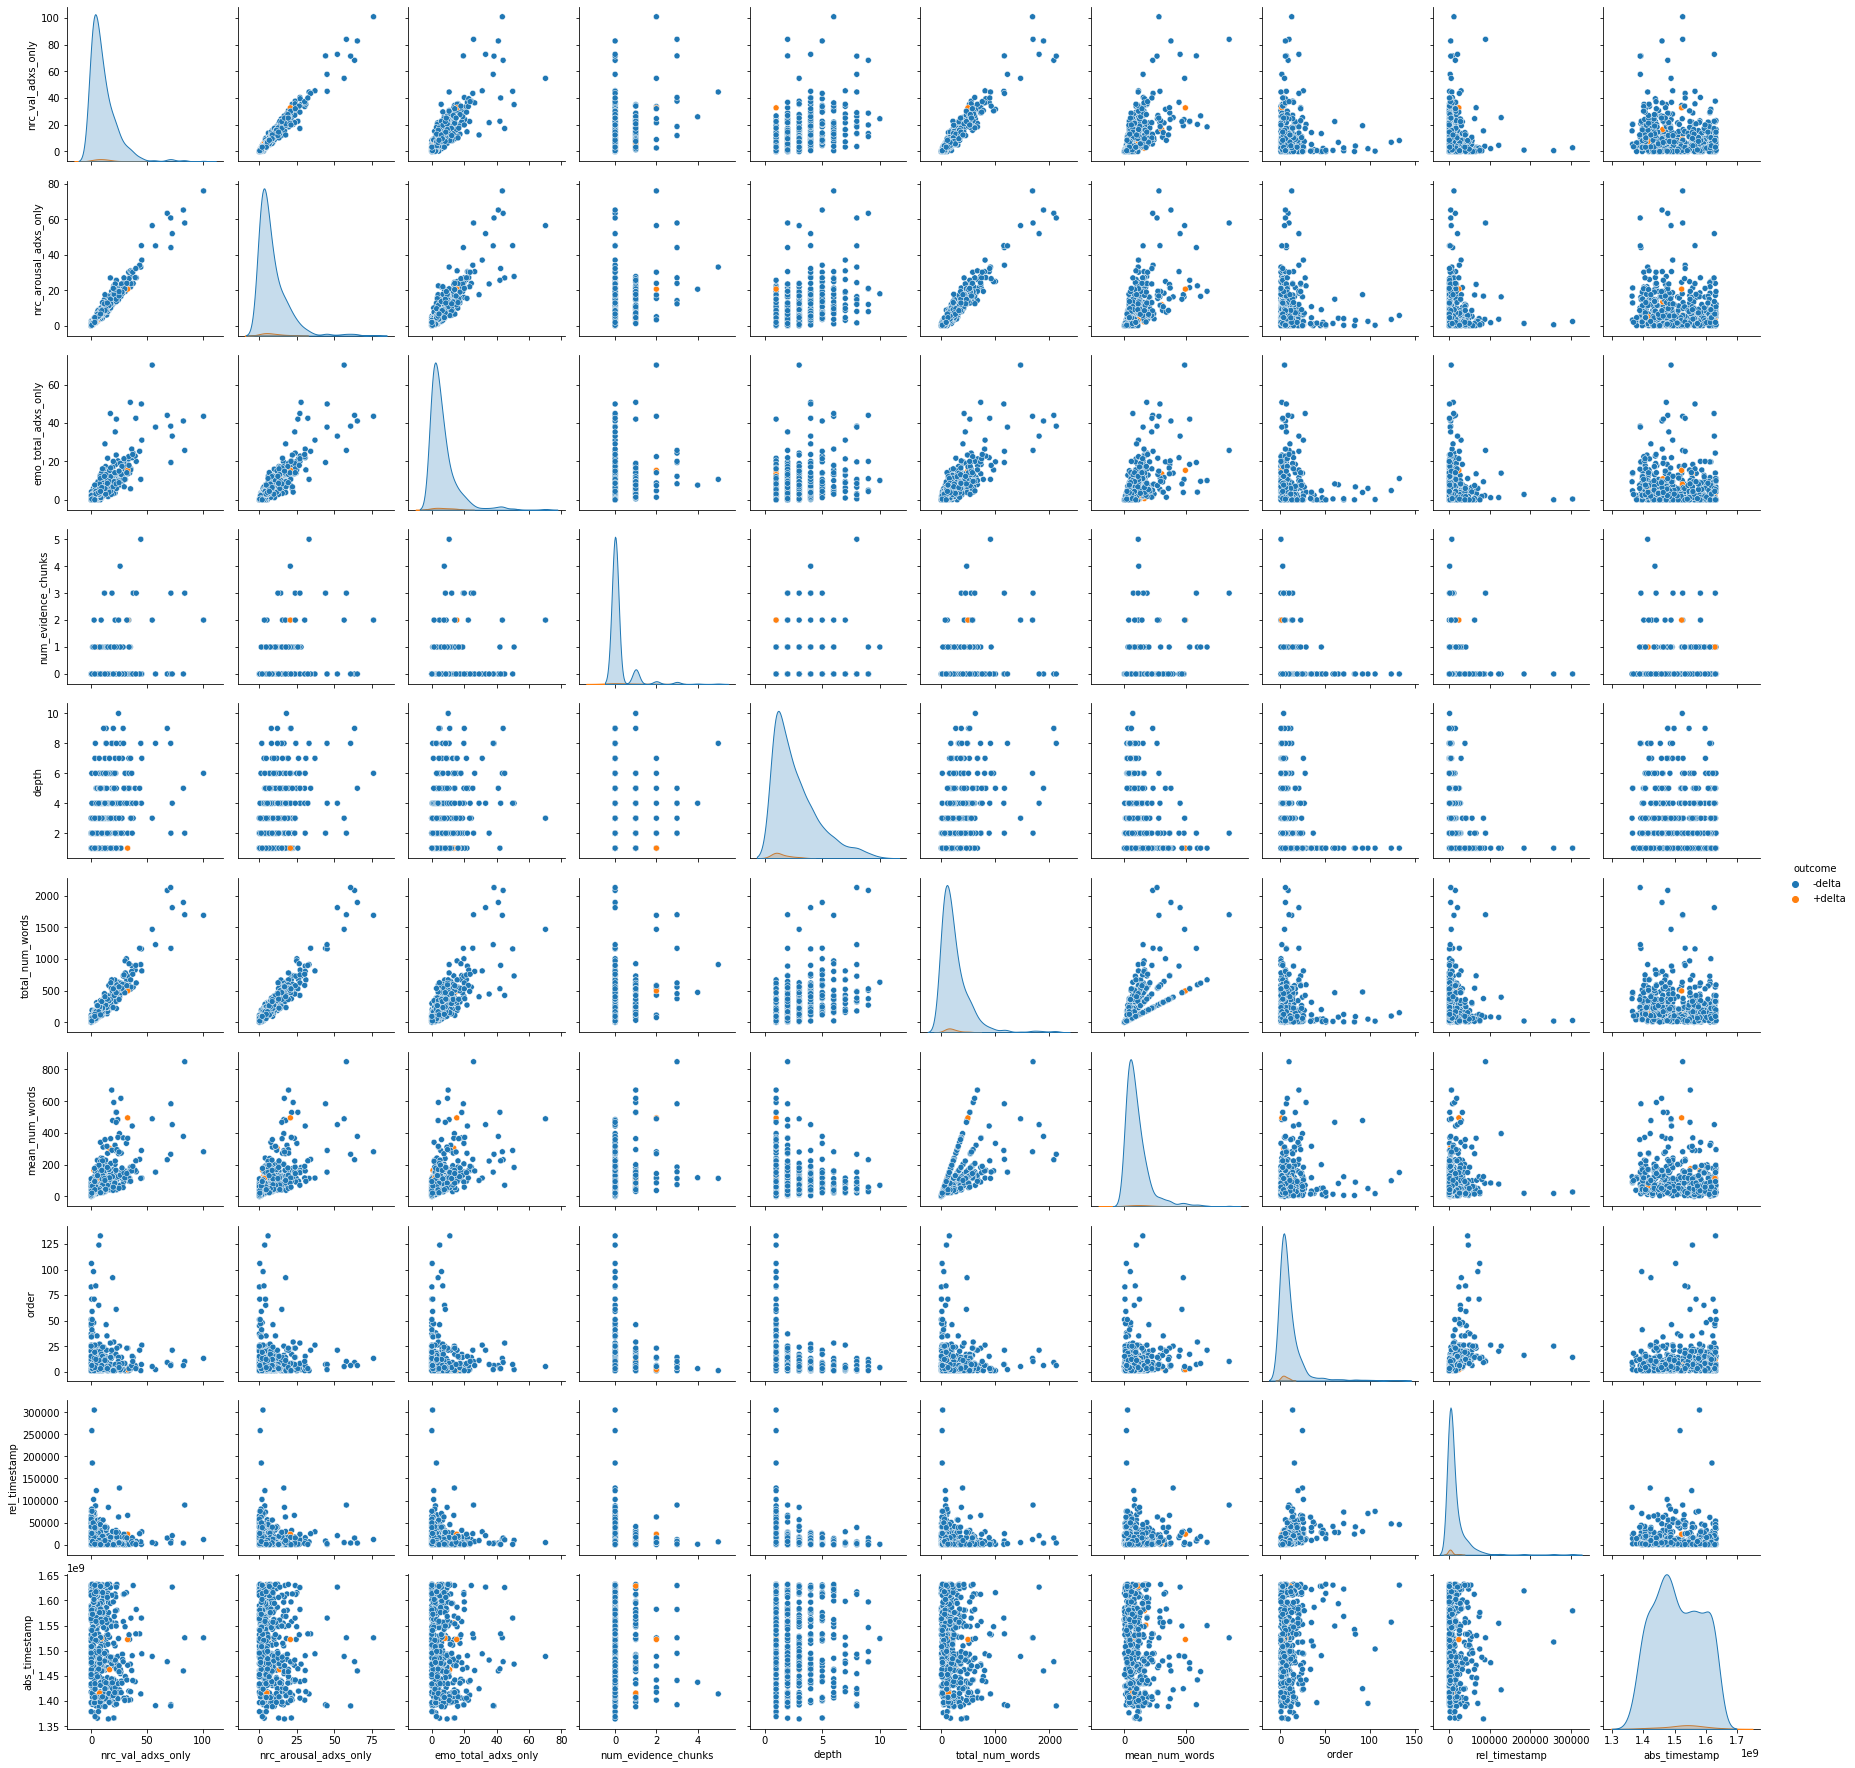

In [58]:
# gigantic pairplot

for model in ['all','adxs_only']:
    
    reg_feats = ['outcome'] + \
                [f'senti_pos_arousal_{model}',f'senti_neg_arousal_{model}',
                 f'nrc_val_{model}',f'nrc_arousal_{model}',
                 f'emo_total_{model}'] + \
                ['num_evidence_chunks'] + \
                ['depth','total_num_words','mean_num_words','order','rel_timestamp','abs_timestamp']
    
    sub_df = to_plot_df[reg_feats].sample(n=500)
    sub_outcome_counts = sub_df['outcome'].value_counts()

    fig,ax = plt.subplots(figsize=(13,13))
    sns.pairplot(sub_df, hue="outcome")#, ax=ax)
    sns.despine()
    
    label2display_text = {'+delta':f"+delta subtrees (N={abbreviate_N(sub_outcome_counts['+delta'])})",
                          '-delta':f"-delta subtrees (N={abbreviate_N(sub_outcome_counts['-delta'])})"}
    handles,labels = ax.get_legend_handles_labels()
    label2handle = dict(zip(labels,handles))
    ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])
    plt.setp(ax.get_legend().get_texts(), fontsize='20')
    
    ax.set_title(f"Distribution of all regression features, counting {model2title[model]}", fontsize=22)

    plt.savefig(f'figs/pairplot_+vs-delta_subtrees_{corp_name}_{model}.png',
                    dpi=150,bbox_inches="tight")

In [60]:
import time
start = time.time()
zscored_senti_pos_all = stats.zscore(to_plot_df['senti_pos_arousal_all'].values)
print(time.time()-start)

0.05923032760620117


In [61]:
len(to_plot_df['senti_pos_arousal_all'].values)

1203509

# Examine pairwise feature log odds

In [6]:
from convokit import FightingWords

save_dir = 'pairwise_feature_log_odds'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [7]:
# Get sum of EmoLex and MFD feats
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if utt.meta['meets_datapoint_crit_excl_OP'] == True:
        for model in ['all','adxs_only']:
            utt.meta['reg_feats'][f'emo_total_{model}'] = sum([utt.meta['reg_feats'][f'emo_{emo}_{model}']
                                                               for emo in EMOLEX_EMOS])
            utt.meta['reg_feats'][f'mfd_total_{model}'] = sum([utt.meta['reg_feats'][f'mfd_{found}_{model}']
                                                               for found in MFD_FOUNDS])

3243830it [02:09, 25137.40it/s]


* high 'senti_pos_arousal_adxs_only' vs. low 'senti_pos_arousal_adxs_only'
    * `senti_pos_arousal_adxs_only` > 3 vs. `senti_pos_arousal_adxs_only` < 3
* high 'senti_neg_arousal_adxs_only' vs. low 'senti_neg_arousal_adxs_only'
    * `senti_neg_arousal_adxs_only` > 3 vs. `senti_neg_arousal_adxs_only` < 3
* high 'senti_pos_arousal_adxs_only' vs. high 'senti_neg_arousal_adxs_only'
    * `senti_pos_arousal_adxs_only` > 3 vs. `senti_neg_arousal_adxs_only` > 3
* high 'nrc_val_adxs_only' vs. low 'nrc_val_adxs_only'
    * `nrc_val_adxs_only` > .934+1.123 (1 STD above log mean of non-zero values) vs. `nrc_val_adxs_only` < .934-1.123
* high 'emo_total_adxs_only' vs. low 'emo_total_adxs_only'
    * same deal; 1 STD above vs. below mean of logged non-zero values
* high 'med_total_adxs_only' vs. low 'mfd_total_adxs_only'
    * 1 STD above vs. below mean

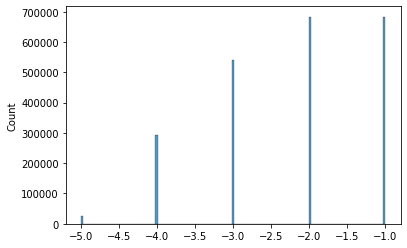

In [9]:
x = [utt.meta['reg_feats']['senti_neg_arousal_adxs_only'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
         if utt.meta['meets_datapoint_crit_excl_OP'] == True]
sns.histplot(x)

In [25]:
fw_df = pd.read_pickle(os.path.join(save_dir,'high_vs_low_emo_total_adxs_only.pkl'))

In [27]:
fw_df.head(30)

z-score                 class
ngram                                           
url            -213.108815  low EmoLex intensity
do you         -152.788177  low EmoLex intensity
op             -134.966493  low EmoLex intensity
please         -130.391002  low EmoLex intensity
sorry          -127.763559  low EmoLex intensity
url url        -127.724738  low EmoLex intensity
link           -126.063884  low EmoLex intensity
removed        -118.956406  low EmoLex intensity
appeal         -118.644676  low EmoLex intensity
what           -114.810259  low EmoLex intensity
are you        -113.339416  low EmoLex intensity
your           -110.177052  low EmoLex intensity
delta          -108.293931  low EmoLex intensity
would like     -108.030528  low EmoLex intensity
would like to  -107.632520  low EmoLex intensity
message        -104.737059  low EmoLex intensity
why             -97.453041  low EmoLex intensity
your view       -96.348044  low EmoLex intensity
comment         -95.042577  low EmoLex intensity
post            -94.302239  low EmoLex intensity
you would       -93.590814  low EmoLex intensity
to appeal       -91.621307  low EmoLex intensity
rule            -89.747732  low EmoLex intensity
view            -89.321761  low EmoLex intensity
if you would    -88.526035  low EmoLex intensity
like to         -88.092676  low EmoLex intensity
changed         -86.138753  low EmoLex intensity
note that       -85.316210  low EmoLex intensity
you would like  -85.082346  low EmoLex intensity
read            -84.464936  low EmoLex intensity

Mean, STD of log of non-zero values of `nrc_val_adxs_only`: 0.9340323978551428 1.1225270882403207


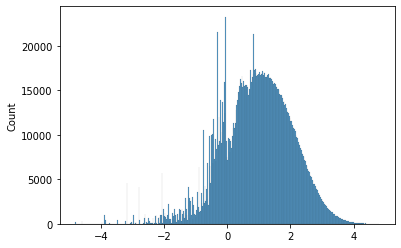

Saving to: pairwise_feature_log_odds/high_vs_low_nrc_val_adxs_only.pkl
Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 343290 valid corpus components. class2_func returned 293554 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


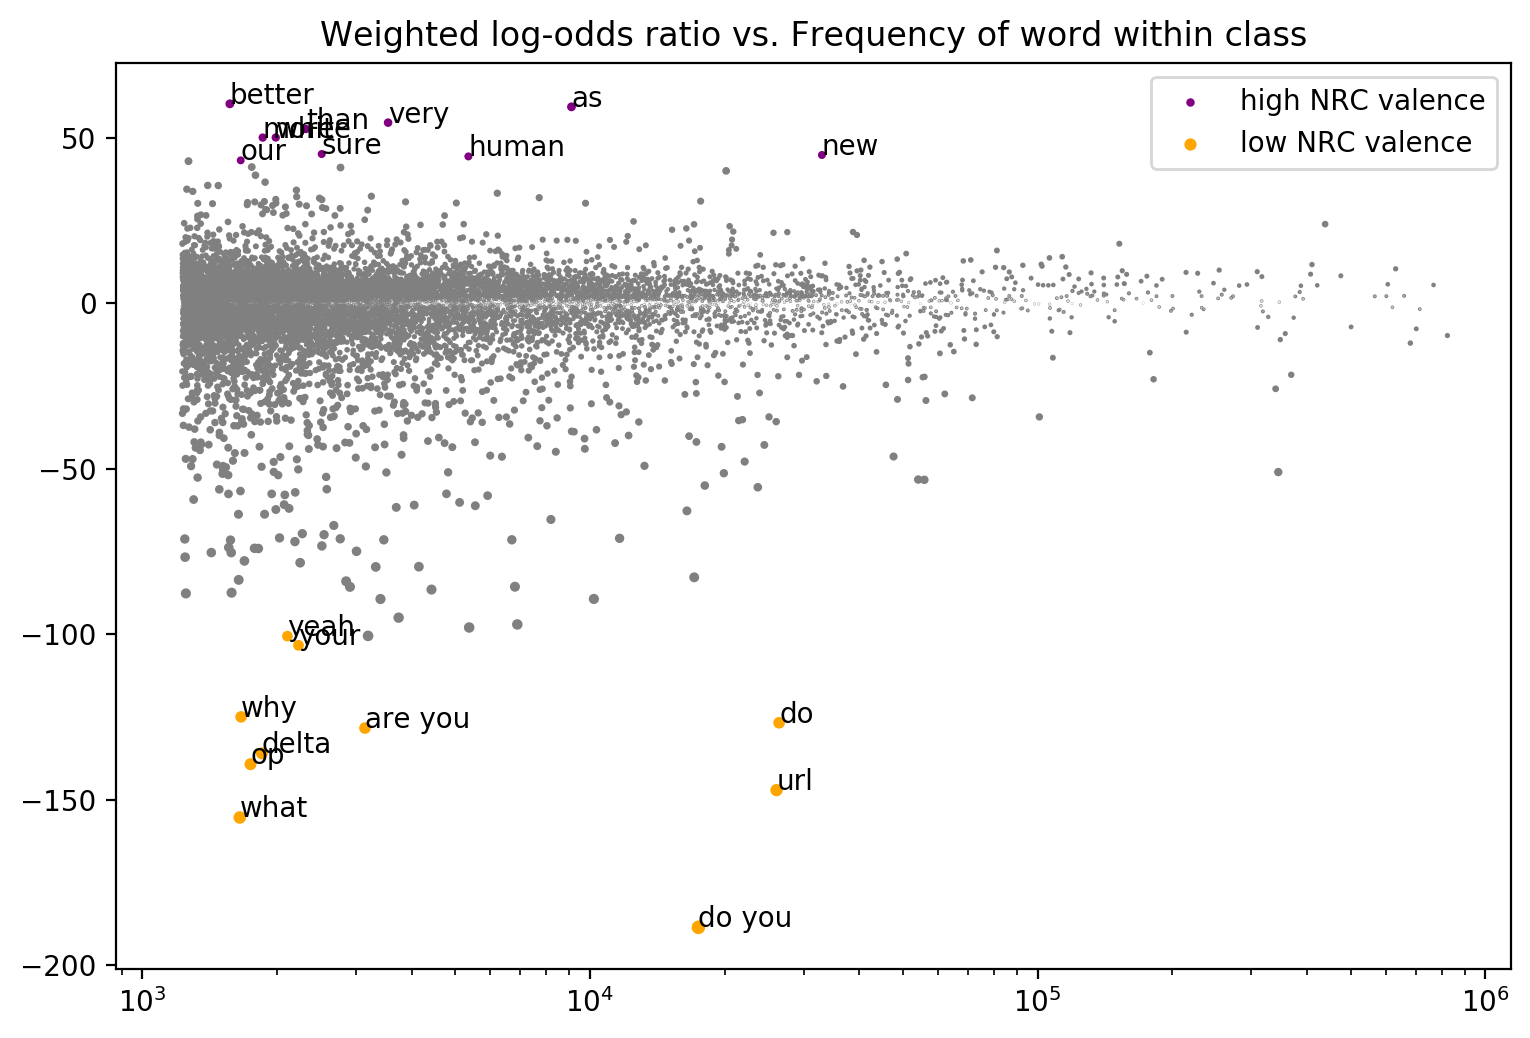

Mean, STD of log of non-zero values of `emo_total_adxs_only`: 0.6941533396634251 1.0604648178236404


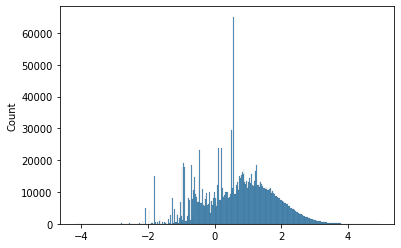

Saving to: pairwise_feature_log_odds/high_vs_low_emo_total_adxs_only.pkl
Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 286178 valid corpus components. class2_func returned 719067 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


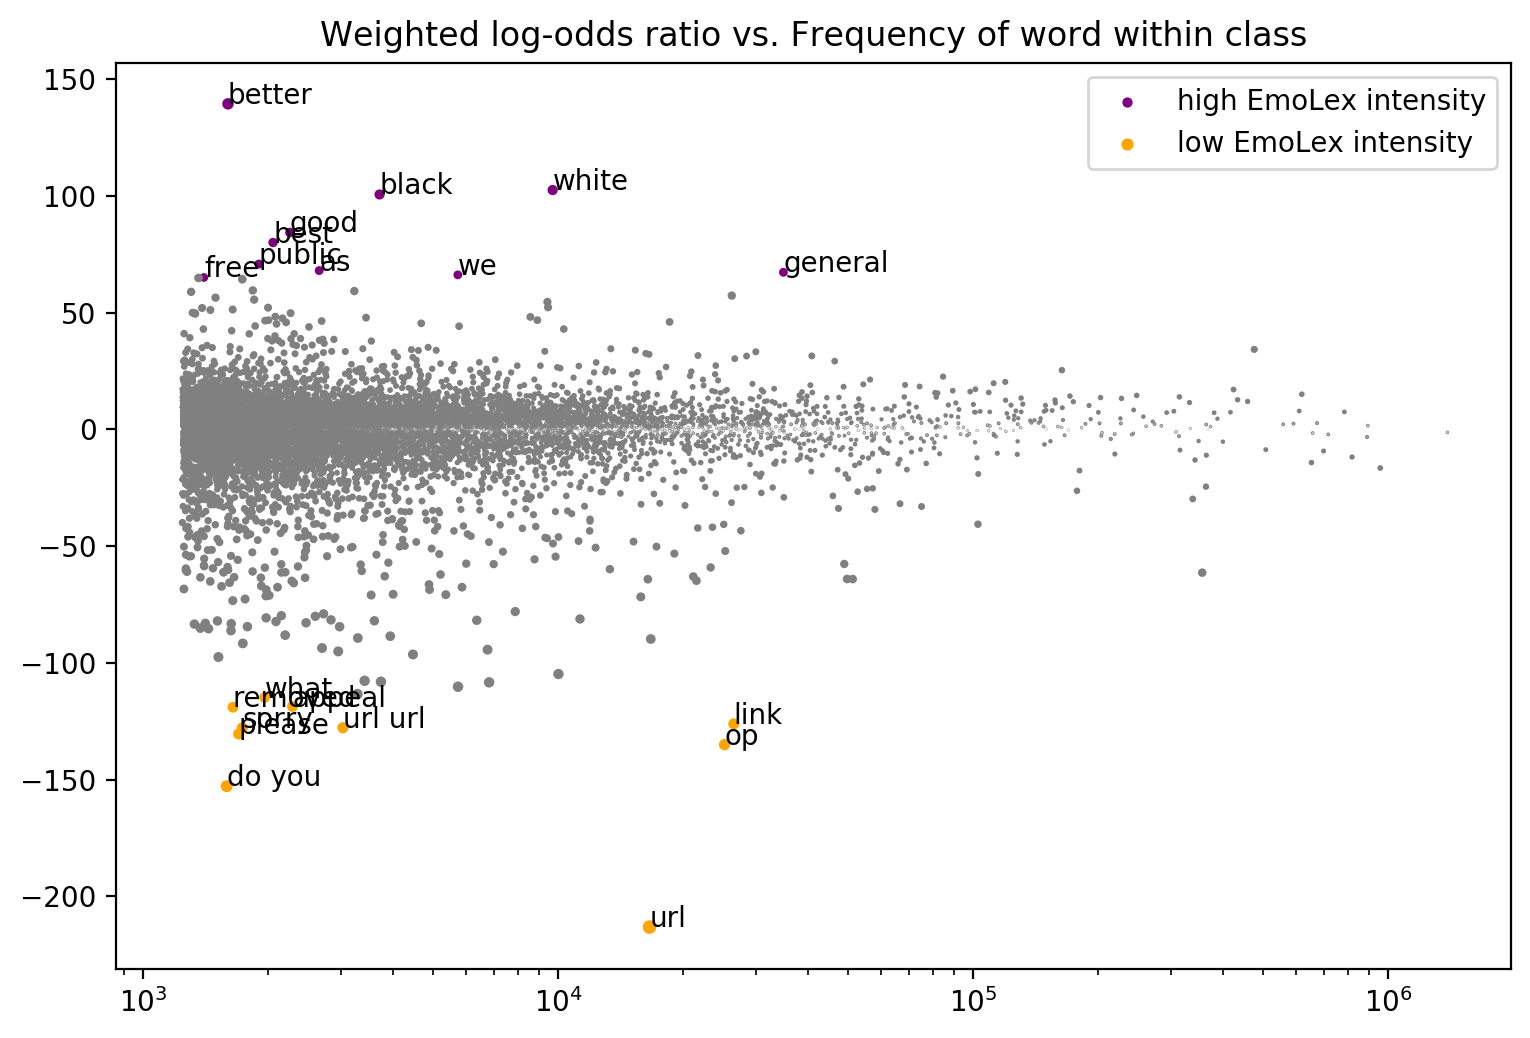

Mean, STD of log of non-zero values of `mfd_total_adxs_only`: 0.34434766102450376 0.5242102642457624


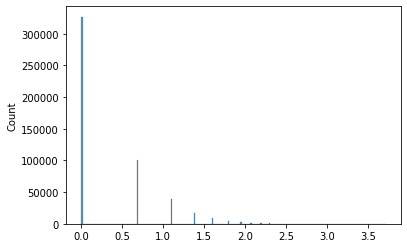

Saving to: pairwise_feature_log_odds/high_vs_low_mfd_total_adxs_only.pkl
Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 177240 valid corpus components. class2_func returned 1721322 valid corpus components.


MemoryError: Unable to allocate 212. GiB for an array with shape (1898562, 15000) and data type int64

In [11]:
from convokit import FightingWords

save_dir = 'pairwise_feature_log_odds'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# fw = FightingWords(ngram_range=(1,3))
# fw.fit(corp_to_analyze['full_cmv'], 
#        class1_func=lambda utt: meets_datapoint_criteria(utt) and \
#                                (utt.meta['reg_feats']['senti_pos_arousal_adxs_only']>4), 
#        class2_func=lambda utt: meets_datapoint_criteria(utt) and \
#                                (utt.meta['reg_feats']['senti_pos_arousal_adxs_only']<2),)
# fw_df = fw.summarize(corp_to_analyze['full_cmv'], plot=True, 
#                   class1_name='high (+) arousal', 
#                   class2_name='low (+) arousal')
# fw_df.to_pickle(os.path.join(save_dir,'high_vs_low_senti_pos_arousal_adxs_only.pkl'))

# fw = FightingWords(ngram_range=(1,3))
# fw.fit(corp_to_analyze['full_cmv'], 
#        class1_func=lambda utt: meets_datapoint_criteria(utt) and \
#                                (abs(utt.meta['reg_feats']['senti_neg_arousal_adxs_only'])>4), 
#        class2_func=lambda utt: meets_datapoint_criteria(utt) and \
#                                (abs(utt.meta['reg_feats']['senti_neg_arousal_adxs_only'])<2),)
# fw_df = fw.summarize(corp_to_analyze['full_cmv'], plot=True, 
#                   class1_name='high (-) arousal', 
#                   class2_name='low (-) arousal')
# fw_df.to_pickle(os.path.join(save_dir,'high_vs_low_senti_neg_arousal_adxs_only.pkl'))

# fw = FightingWords(ngram_range=(1,3))
# fw.fit(corp_to_analyze['full_cmv'], 
#        class1_func=lambda utt: meets_datapoint_criteria(utt) and \
#                                (utt.meta['reg_feats']['senti_pos_arousal_adxs_only']>4), 
#        class2_func=lambda utt: meets_datapoint_criteria(utt) and \
#                                (abs(utt.meta['reg_feats']['senti_neg_arousal_adxs_only'])>4),)
# fw_df = fw.summarize(corp_to_analyze['full_cmv'], plot=True, 
#                   class1_name='high (+) arousal', 
#                   class2_name='high (-) arousal')
# fw_df.to_pickle(os.path.join(save_dir,'high_pos_vs_high_neg_senti_arousal_adxs_only.pkl'))

feat2pretty_name = {'nrc_val_adxs_only': 'NRC valence', 'emo_total_adxs_only': 'EmoLex intensity', 
                    'mfd_total_adxs_only': 'MFD score'}
for feat in ['nrc_val_adxs_only','emo_total_adxs_only','mfd_total_adxs_only']:
    x = [utt.meta['reg_feats'][feat] for utt in corp_to_analyze['full_cmv'].iter_utterances()
         if utt.meta['meets_datapoint_crit_excl_OP'] == True]
    log_x = np.log([item for item in x if item > 0])
    mean, std = np.mean(log_x), np.std(log_x)
    print(f"Mean, STD of log of non-zero values of `{feat}`:", mean, std)
    sns.histplot(log_x)
    plt.show()
    save_name = os.path.join(save_dir,f'high_vs_low_{feat}.pkl')
    print("Saving to:", save_name)
    fw = FightingWords(ngram_range=(1,3))
    fw.fit(corp_to_analyze['full_cmv'], 
           class1_func=lambda utt: meets_datapoint_criteria(utt) and \
                                   (np.log(utt.meta['reg_feats'][feat]+.5) > mean + std), 
           class2_func=lambda utt: meets_datapoint_criteria(utt) and \
                                   (np.log(utt.meta['reg_feats'][feat]+.5) < mean - std),)
    fw_df = fw.summarize(corp_to_analyze['full_cmv'], plot=True, 
                      class1_name=f'high {feat2pretty_name[feat]}', 
                      class2_name=f'low {feat2pretty_name[feat]}')
    fw_df.to_pickle(os.path.join(save_dir,f'high_vs_low_{feat}.pkl'))

## Examine dists. of LOR for + vs. -delta subtrees, color-coded by lexicon

In [7]:
subtree_ids = set(subtree_ids)

In [8]:
# First replace utt.text for subtree outcome utts w/ entire text of subtree to enable direct usage of FightingWords

for utt in tqdm(subtree_outcome_utts):
    path_to = utt.meta['path_to_outcome_OP_removed']
    full_path_text = [get_utt(u_id).text for u_id in path_to]
    utt.text = ' '.join(full_path_text)

100%|██████████| 1203509/1203509 [00:20<00:00, 59126.01it/s]


Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 33818 valid corpus components. class2_func returned 1169691 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


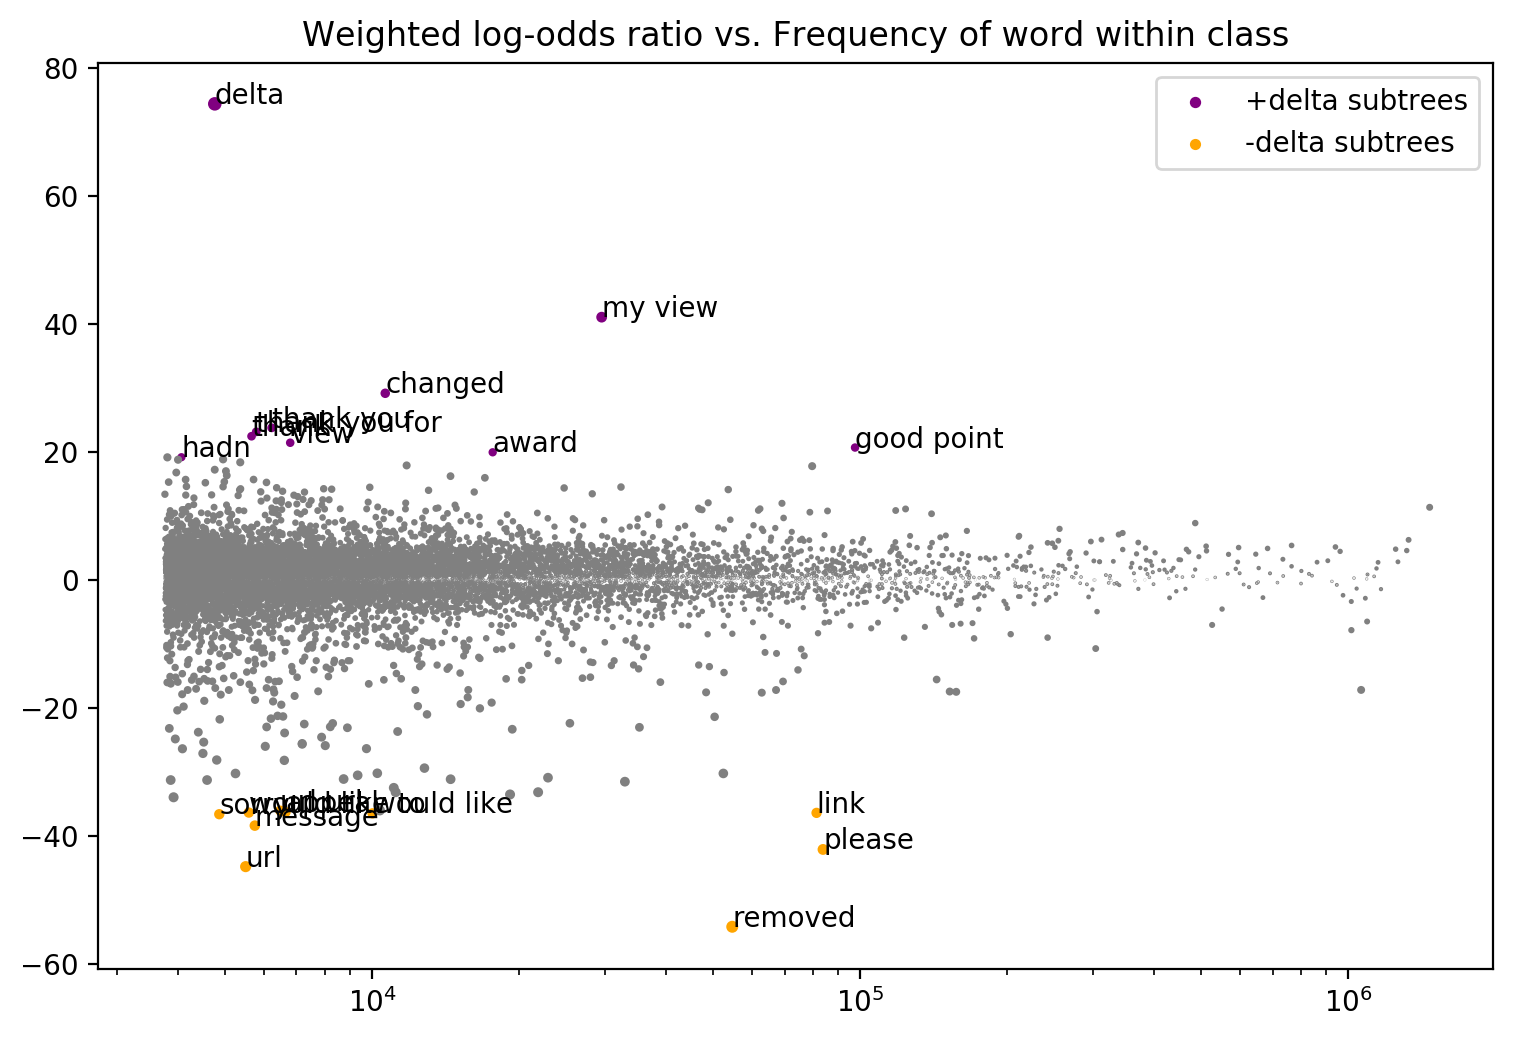

In [9]:
fw = FightingWords(ngram_range=(1,3))
fw.fit(corp_to_analyze['full_cmv'], 
       class1_func=lambda utt: (utt.id in subtree_ids) and \
                               (utt.meta['outcome']=='+delta'), 
       class2_func=lambda utt: (utt.id in subtree_ids) and \
                               (utt.meta['outcome']=='-delta'),)
fw_df = fw.summarize(corp_to_analyze['full_cmv'], plot=True, 
                      class1_name='+delta subtrees', 
                      class2_name='-delta subtrees')
fw_df.to_pickle(os.path.join(save_dir,'+_vs_-_delta_subtrees.pkl'))

In [137]:
sig_lor = fw_df.loc[fw_df['z-score'].apply(lambda x: abs(x) >= 1.96)]
print(f"Found {len(sig_lor)} significant LOR values (>=1.96)")
ngram2lor = dict(zip(sig_lor.index.values, sig_lor['z-score'].values))
len(ngram2lor)

Found 6966 significant LOR values (>=1.96)


6966

In [15]:
ngram2lor['think about']

12.372156007751716

In [169]:
BLACKLIST_WORDS = {'shit','shitty','fuck','crap','crappy','gore','trump','tree','sun','soil','shanghai','john',
                  'desert','turn','earthquake','lightning','hurricane','cyclone','tornado','storm','wildfire',
                  'fire','cool','warm','hot','human','earth','planet','global','climate','change','cold',
                  'kind','love','like','hell',
                   'delta','changed','thank','view','award','thanks',
                   'moderation','review','submission','confirmed','don',
                   'remove','removed','sorry','appeal','moderator','violate','violated','violation',
                   'rule','delete','deleted','break','breaking','ban','banned'}

NRC = pd.read_csv('/u/scr/yiweil/datasets/NRC-VAD-Lexicon.txt',sep='\t',header=0)
NRC = NRC.loc[~NRC['Word'].isin(BLACKLIST_WORDS)]
word2nrc_arousal = dict(zip(NRC['Word'],NRC['Arousal']))
word2nrc_valence = dict(zip(NRC['Word'],NRC['Valence']))
NRC_vocab = set(NRC['Word'].values)
print(f"Size of NRC vocab: {len(NRC_vocab)}.")
display(NRC.head())
print(NRC.loc[NRC['Word'].apply(lambda x: type(x) == float)])

PATH_TO_EMOLEX = "/u/scr/yiweil/datasets/NRC-Emotion-Intensity-Lexicon-v1.txt"
EMOLEX = pd.read_csv(PATH_TO_EMOLEX,sep='\t')
EMOLEX = EMOLEX.loc[~EMOLEX['word'].isin(BLACKLIST_WORDS)]
EMOLEX_EMOS = EMOLEX['emotion'].value_counts().index
display(EMOLEX.head())
EMOLEX_vocab = set(EMOLEX['word'].values)
print(f"Size of EmoLex vocab: {len(EMOLEX_vocab)}")
print(EMOLEX[
    'emotion'
].value_counts())

# Create look-up dicts and function for computing Emolex scores

word2emolex_score = defaultdict(dict)
for _,row in EMOLEX.iterrows():
    word, emotion, score = row['word'], row['emotion'], row['emotion-intensity-score']
    word2emolex_score[word][emotion] = score
    
path_to_MFD = '/u/scr/yiweil/datasets/MFD2.0.tsv'
mfd_df = pd.read_csv(path_to_MFD, sep='\t')
mfd_df = mfd_df.loc[~mfd_df['word'].isin(BLACKLIST_WORDS)].copy()
print(mfd_df.shape)
display(mfd_df.head())

MFD_vocab = set(mfd_df['word'].values)
MFD_foundations = set(mfd_df['foundation'].values)
MFD_valences = set(mfd_df['valence'].values)
print(f'Size of MFD vocab: {len(MFD_vocab)}')
print('All foundations:',MFD_foundations)
print('All valences:',MFD_valences)

word2foundation_dict = defaultdict(dict)
for _,row in mfd_df.iterrows():
    word, valence, foundation = row['word'], row['valence'], row['foundation']
    word2foundation_dict[word][foundation] = valence

Size of NRC vocab: 19950.


Word  Valence  Arousal  Dominance
0  aaaaaaah    0.479    0.606      0.291
1     aaaah    0.520    0.636      0.282
2  aardvark    0.427    0.490      0.437
3     aback    0.385    0.407      0.288
4    abacus    0.510    0.276      0.485

      Word  Valence  Arousal  Dominance
11940  NaN    0.253    0.147      0.152


word emotion  emotion-intensity-score
0   outraged   anger                    0.964
1  brutality   anger                    0.959
2     hatred   anger                    0.953
3    hateful   anger                    0.940
4  terrorize   anger                    0.939

Size of EmoLex vocab: 5937
fear            1749
trust           1554
anger           1472
sadness         1289
joy             1261
disgust         1084
anticipation     860
surprise         575
Name: emotion, dtype: int64
(2097, 3)


word valence foundation
0  compassion  virtue       harm
1     empathy  virtue       harm
2    kindness  virtue       harm
3      caring  virtue       harm
4  generosity  virtue       harm

Size of MFD vocab: 2034
All foundations: {'authority', 'harm', 'purity', 'loyalty', 'fairness'}
All valences: {'virtue', 'vice'}


LOR values computed for 1739 features from NRC lexicon.


lor  NRC_val          word
790   18.768131    0.827     important
167   17.873218    0.938          good
1081  17.761128    0.812           art
611   16.982911    0.704           may
559   15.938158    0.604          time
555   15.215912    0.780       thought
65    14.351618    0.688   perspective
277   14.226984    0.833         music
1394  14.157894    0.917           new
49    14.098439    0.800         space
1691  13.836576    0.735          game
1115  13.719668    0.945      superman
733   13.702035    0.519        things
191   13.270125    0.542       example
1627  13.167601    0.698      audience
1232  12.778485    0.867  relationship
501   12.511090    0.750     convinced
95    12.510894    0.480           way
1547  12.293635    0.827    experience
804   12.140654    0.634        turkey

Mean, STD of NRC Valence scores: 0.5000023557716405 0.21550968517790015
Pos., neg. valence thresholds: 0.5000023557716405 0.5000023557716405
(+)    1197
(-)     542
Name: val_cat, dtype: int64


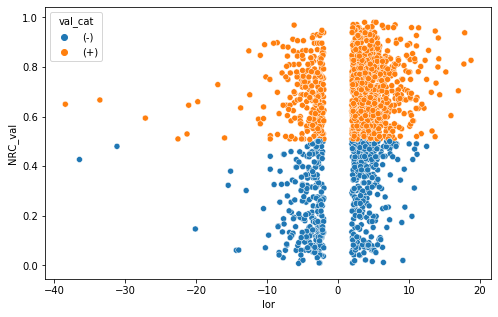

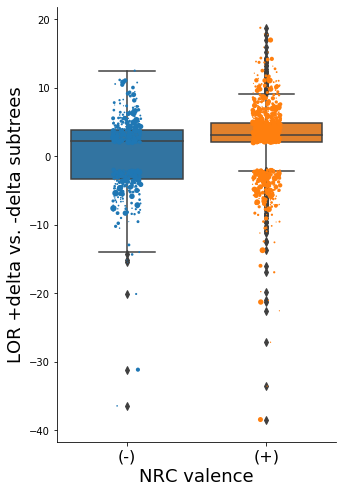

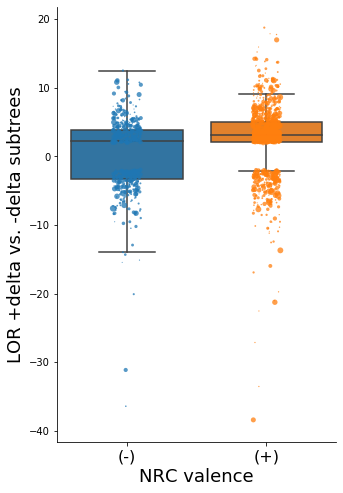

8.58069881351104 2.0560698948120434e-17


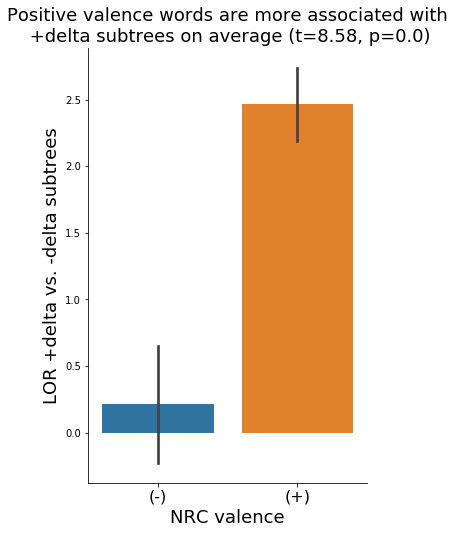

In [154]:
# Want to show that pos. valence words more associated w/ +delta subtrees than -delta subtrees

words = list(NRC_vocab.intersection(set(ngram2lor.keys())))
print(f"LOR values computed for {len(words)} features from NRC lexicon.")
to_plot_df = pd.DataFrame({
    'lor': [ngram2lor[x] for x in words],
    'NRC_val': [word2nrc_valence[x] for x in words],
    'word': words})
display(to_plot_df.sort_values('lor',ascending=False).head(20))

# Decide on threshold for (+) and (-) valence categories
mean_val, std_val = NRC['Valence'].mean(), NRC['Valence'].std()
print("Mean, STD of NRC Valence scores:", mean_val, std_val)
pos_thresh, neg_thresh = mean_val+0*std_val, mean_val-0*std_val
print("Pos., neg. valence thresholds:", pos_thresh, neg_thresh)
to_plot_df['val_cat'] = to_plot_df['NRC_val'].apply(lambda x: '(+)' if x >= pos_thresh else False)
to_plot_df['val_cat'] = to_plot_df.apply(lambda x: '(-)' if x['NRC_val'] <= neg_thresh else x['val_cat'], axis=1)
print(to_plot_df['val_cat'].value_counts())
to_plot_df = to_plot_df.loc[to_plot_df['val_cat'].isin({'(+)','(-)'})]

# Scatterplot
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x='lor', y='NRC_val', hue='val_cat', data=to_plot_df, ax=ax)
plt.show()

# Boxplot
fig, ax = plt.subplots(figsize=(5,8))
sizes = to_plot_df['NRC_val'].apply(lambda x: 3**(7*abs(x-0.5))).values
sns.boxplot(x='val_cat', y='lor', data=to_plot_df, ax=ax, order=['(-)','(+)'])
sns.stripplot(x='val_cat', y='lor', data=to_plot_df, ax=ax, sizes=sizes, order=['(-)','(+)'])
ax.set_xlabel("NRC valence",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
sns.despine()
plt.show()

# Without outliers
fig, ax = plt.subplots(figsize=(5,8))
sizes = to_plot_df['NRC_val'].apply(lambda x: 3**(7*abs(x-0.5))).values
sns.boxplot(x='val_cat', y='lor', data=to_plot_df, ax=ax, order=['(-)','(+)'],showfliers=False)
sns.stripplot(x='val_cat', y='lor', data=to_plot_df, ax=ax, sizes=sizes, alpha=0.75, order=['(-)','(+)'])
ax.set_xlabel("NRC valence",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
sns.despine()
plt.show()

# Barplot
t, pval = stats.ttest_ind(to_plot_df.loc[to_plot_df['val_cat']=='(+)']['lor'],
                          to_plot_df.loc[to_plot_df['val_cat']=='(-)']['lor'])
print(t,pval)

fig, ax = plt.subplots(figsize=(5,8))
sns.barplot(x='val_cat', y='lor', data=to_plot_df, ax=ax, order=['(-)','(+)'])
ax.set_xlabel("NRC valence",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
comp = 'more' if t > 0 else 'less'
ax.set_title(f"Positive valence words are {comp} associated with\n +delta subtrees \
on average (t={round(t,2)}, p={round(pval,3)})", fontsize=18)
sns.despine()
plt.show()

In [155]:
to_plot_df.sort_values('lor',ascending=True).head(40)

lor  NRC_val          word val_cat
1182 -38.426163    0.650       message     (+)
1203 -36.433358    0.427          link     (-)
1600 -33.555226    0.667       comment     (+)
919  -31.144423    0.480            op     (-)
1322 -27.142267    0.594          note     (+)
813  -22.548606    0.510          week     (+)
635  -21.269830    0.530          wiki     (+)
643  -21.037610    0.646        notice     (+)
415  -20.096569    0.147           gun     (-)
1167 -19.753975    0.660      multiple     (+)
669  -16.925756    0.729         white     (+)
90   -15.977797    0.514           pay     (+)
1108 -15.463781    0.323          lead     (-)
291  -15.129984    0.380      reversal     (-)
605  -14.325597    0.061        racist     (-)
1557 -13.981638    0.062          rape     (-)
1636 -13.707190    0.635          wage     (+)
1715 -12.933597    0.302         ended     (-)
1337 -12.555592    0.865         woman     (+)
1264 -12.424173    0.688           man     (+)
944  -11.197312    0.590   substantial     (+)
489  -10.941537    0.847     privilege     (+)
1425 -10.937059    0.571     literally     (+)
1102 -10.487021    0.229       fucking     (-)
1220 -10.486056    0.592          race     (+)
97   -10.482955    0.639       compose     (+)
710  -10.331680    0.890         humor     (+)
223  -10.222034    0.071         crime     (-)
137  -10.154688    0.760     agreement     (+)
870   -9.770913    0.122        racism     (-)
399   -9.588562    0.750  conversation     (+)
1711  -9.538390    0.388           gay     (-)
712   -9.536993    0.440          mean     (-)
1326  -9.534867    0.510       process     (+)
639   -9.525129    0.523         check     (+)
1595  -9.062562    0.896          free     (+)
884   -8.996654    0.326         black     (-)
161   -8.549628    0.898      equality     (+)
953   -8.529429    0.698       country     (+)
1283  -8.503248    0.528          list     (+)

LOR values computed for 622 features from EmoLex lexicon.


lor        word  emo_val           emo
585 -20.096569         gun    0.734          fear
363 -16.925756       white    0.344         trust
135 -15.977797         pay    0.461  anticipation
387 -15.129984    reversal    0.469      surprise
381 -13.981638        rape    0.906       disgust
334 -13.593577      earned    0.570         trust
63  -10.941537   privilege    0.414         trust
435 -10.331680       humor    0.656           joy
305 -10.222034       crime    0.719          fear
198 -10.154688   agreement    0.727         trust
577  -9.538390         gay    0.391         trust
419  -9.062562        free    0.544           joy
66   -8.996654       black    0.281       sadness
229  -8.549628    equality    0.727         trust
382  -8.398207  ridiculous    0.352       disgust
108  -8.294986        kill    0.962          fear
51   -7.946128         cop    0.430         trust
113  -7.873548       wages    0.169           joy
82   -7.819413       theft    0.621         anger
432  -7.716364        hate    0.828         anger
354  -7.661705    offended    0.652         anger
90   -7.652943   socialist    0.422       disgust
447  -7.586464     assault    0.891          fear
364  -7.408285     illegal    0.500          fear
10   -7.340371         top    0.469         trust
149  -7.274273    religion    0.469         trust
398  -7.227079         sex    0.695  anticipation
478  -7.224608    stealing    0.578          fear
313  -7.189637    abortion    0.766       sadness
429  -7.152629       rifle    0.453          fear
493  -7.122820        date    0.344           joy
495  -7.115664       money    0.586  anticipation
328  -7.060053      income    0.500  anticipation
92   -7.030969        live    0.406           joy
297  -6.879963    firearms    0.600          fear
326  -6.779265   socialism    0.414       disgust
533  -6.734012      prison    0.625          fear
245  -6.572230    nonsense    0.250         anger
399  -6.354358       child    0.523  anticipation
548  -6.284779      friday    0.455           joy

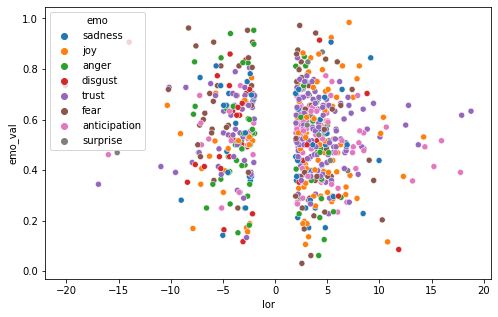

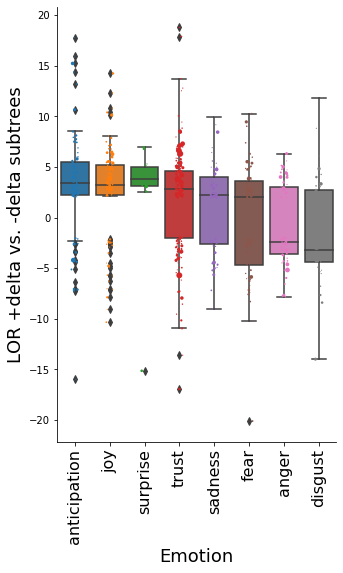

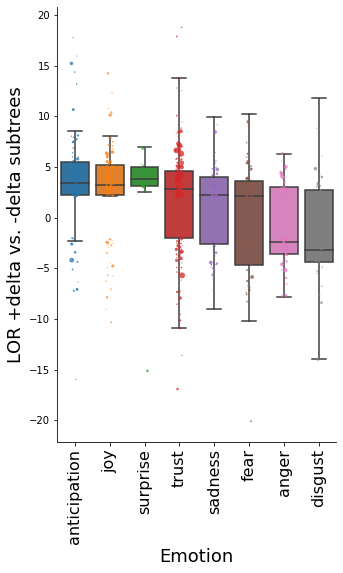

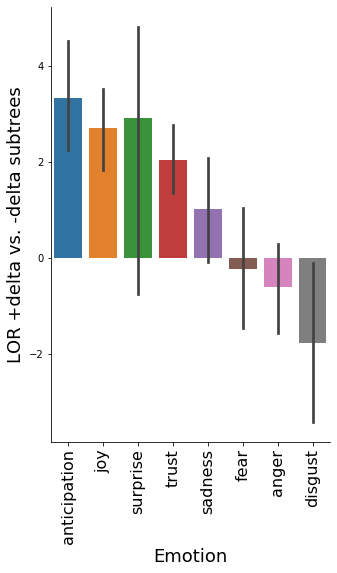

In [174]:
# EmoLex

words = list(EMOLEX_vocab.intersection(set(ngram2lor.keys())))
print(f"LOR values computed for {len(words)} features from EmoLex lexicon.")
x = [ngram2lor[x] for x in words]
# account for how some words have multiple emotion associations by taking score of *most* associated emotion
# (~most salient emotion)
emos_vals = [max([(emo, word2emolex_score[x][emo]) for emo in word2emolex_score[x]], key=lambda item: item[1]) 
             for x in words] 
to_plot_df = pd.DataFrame({
    'lor': x,
    'word': words,
    'emo_val': [x[1] for x in emos_vals],
    'emo': [x[0] for x in emos_vals]})
display(to_plot_df.sort_values('lor').head(40))

# # Decide on threshold for (+) and (-) valence categories
# mean_val, std_val = EMOLEX['emotion-intensity-score'].mean(), EMOLEX['emotion-intensity-score'].std()
# print("Mean, STD of EmoLex intensity scores:", mean_val, std_val)
# pos_thresh, neg_thresh = mean_val+0*std_val, mean_val-0*std_val
# print("Pos., neg. valence thresholds:", pos_thresh, neg_thresh)
# to_plot_df['val_cat'] = to_plot_df['NRC_val'].apply(lambda x: '(+)' if x >= pos_thresh else False)
# to_plot_df['val_cat'] = to_plot_df.apply(lambda x: '(-)' if x['NRC_val'] <= neg_thresh else x['val_cat'], axis=1)
# print(to_plot_df['val_cat'].value_counts())
# to_plot_df = to_plot_df.loc[to_plot_df['val_cat'].isin({'(+)','(-)'})]

# Scatterplot
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x='lor', y='emo_val', hue='emo', data=to_plot_df, ax=ax)
plt.show()

# Boxplot
order = ['anticipation','joy','surprise','trust','sadness','fear','anger','disgust']
fig, ax = plt.subplots(figsize=(5,8))
sizes = to_plot_df['emo_val'].apply(lambda x: 3**(7*abs(x-0.5))).values
sns.boxplot(x='emo', y='lor', data=to_plot_df, ax=ax, order=order)
sns.stripplot(x='emo', y='lor', data=to_plot_df, ax=ax, sizes=sizes, order=order)
ax.set_xlabel("Emotion",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
sns.despine()
plt.show()

# Without outliers
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(x='emo', y='lor', data=to_plot_df, ax=ax, order=order,showfliers=False)
sns.stripplot(x='emo', y='lor', data=to_plot_df, ax=ax, sizes=sizes, alpha=0.75, order=order)
ax.set_xlabel("Emotion",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
sns.despine()
plt.show()

# Barplot
# t, pval = stats.ttest_ind(to_plot_df.loc[to_plot_df['val_cat']=='(+)']['lor'],
#                           to_plot_df.loc[to_plot_df['val_cat']=='(-)']['lor'])
# print(t,pval)

fig, ax = plt.subplots(figsize=(5,8))
sns.barplot(x='emo', y='lor', data=to_plot_df, ax=ax, order=order)
ax.set_xlabel("Emotion",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
# comp = 'greater' if t > 0 else 'less'
# ax.set_title(f"Positive valence words are more associated with\n +delta subtrees \
# on average (t={round(t,2)}, p={round(pval,3)})", fontsize=18)
sns.despine()
plt.show()

In [183]:
to_plot_df.loc[to_plot_df['emo']=='disgust'].sort_values('lor').head(40)

lor            word  emo_val      emo
381 -13.981638            rape    0.906  disgust
382  -8.398207      ridiculous    0.352  disgust
90   -7.652943       socialist    0.422  disgust
326  -6.779265       socialism    0.414  disgust
536  -5.535798           toxic    0.773  disgust
104  -5.337852    disingenuous    0.453  disgust
479  -5.200390        ignorant    0.406  disgust
560  -4.900204       pregnancy    0.164  disgust
3    -4.380956           obese    0.734  disgust
273  -4.355969             cur    0.453  disgust
102  -4.314299           bigot    0.859  disgust
378  -4.181419           lying    0.531  disgust
397  -4.102891      accusation    0.523  disgust
153  -4.077263         bigoted    0.633  disgust
543  -3.673910             fat    0.617  disgust
23   -3.650047         obesity    0.695  disgust
601  -3.556328         immoral    0.648  disgust
99   -3.413514        polygamy    0.617  disgust
480  -3.158251  discrimination    0.664  disgust
65   -3.157673           greed    0.500  disgust
132  -3.077590             boy    0.117  disgust
178  -2.805222         asshole    0.836  disgust
5    -2.771642           nasty    0.703  disgust
332  -2.690096           idiot    0.492  disgust
202  -2.444010           gross    0.719  disgust
250  -2.165555         default    0.227  disgust
446   2.289092          lawyer    0.352  disgust
284   2.693791           alien    0.438  disgust
534   3.058077           taboo    0.500  disgust
212   3.128406           waste    0.695  disgust
274   3.325928         lesbian    0.289  disgust
29    3.995273         remains    0.516  disgust
557   4.254595          incest    0.914  disgust
249   4.823038        bacteria    0.656  disgust
605   6.076508        congress    0.297  disgust
203   8.809547            porn    0.703  disgust
312  11.844282            mind    0.086  disgust

LOR values computed for 175 features from MFD lexicon.


lor           word             found
130 -14.325597         racist     fairness_vice
94  -13.981638           rape         harm_vice
93  -10.487021        fucking       purity_vice
53   -9.770913         racism     fairness_vice
82   -8.549628       equality   fairness_virtue
26   -8.529429        country    loyalty_virtue
127  -8.294986           kill         harm_vice
61   -8.188754         sexist     fairness_vice
102  -7.819413          theft     fairness_vice
172  -7.586464        assault         harm_vice
62   -7.408285        illegal    authority_vice
174  -7.274273       religion     purity_virtue
34   -7.224608       stealing     fairness_vice
65   -6.474286          raped         harm_vice
116  -6.354358          child       harm_virtue
84   -6.144006         sexism     fairness_vice
87   -5.939938         fucked       purity_vice
69   -5.910088           laws   fairness_virtue
77   -5.887257         murder         harm_vice
114  -5.813522     healthcare       harm_virtue
54   -5.746861     patriarchy  authority_virtue
37   -5.706606       marriage     purity_virtue
152  -5.651205     oppression     fairness_vice
50   -5.378196         police  authority_virtue
88   -5.227832           hell       purity_vice
0    -5.224561      countries    loyalty_virtue
141  -5.194660       violence         harm_vice
162  -5.188381        racists     fairness_vice
115  -5.177856        violent         harm_vice
113  -5.001202          bible     purity_virtue
148  -4.927518          steal     fairness_vice
160  -4.803316          virus       purity_vice
45   -4.779110      christian     purity_virtue
108  -4.582239        victims         harm_vice
166  -4.572436           lied     fairness_vice
161  -4.434923         victim         harm_vice
56   -4.351647          fraud     fairness_vice
46   -4.341579  discriminated     fairness_vice
120  -4.314299          bigot     fairness_vice
123  -4.229918            god     purity_virtue

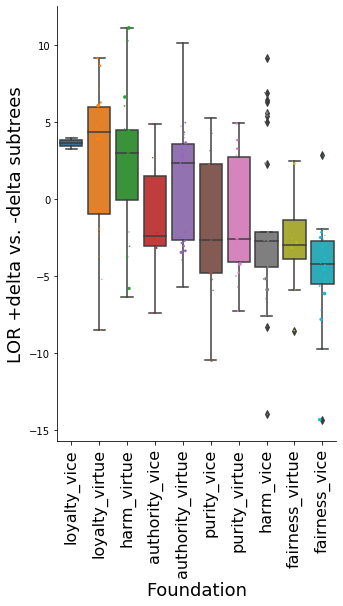

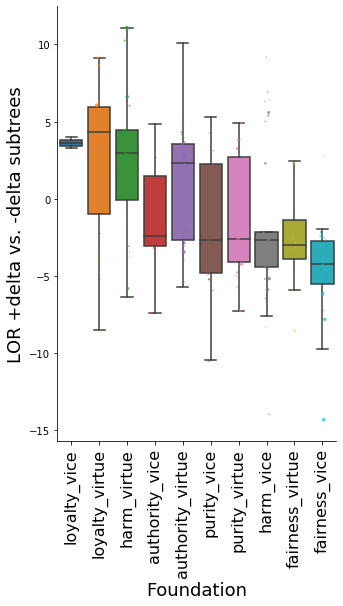

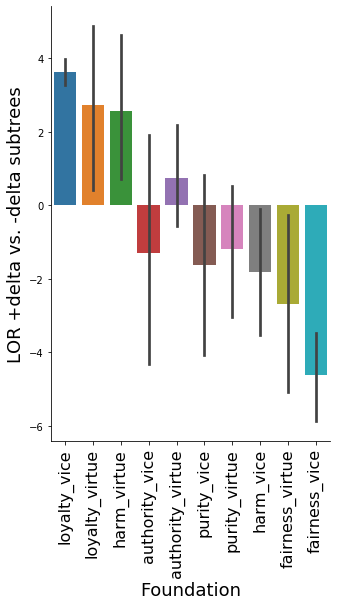

In [159]:
# MFD

words = list(MFD_vocab.intersection(set(ngram2lor.keys())))
print(f"LOR values computed for {len(words)} features from MFD lexicon.")
df_lors, df_founds, df_words = [], [], []
for w in words:
    lor = ngram2lor[w]
    for found in word2foundation_dict[w]:
        val = word2foundation_dict[w][found]
        df_founds.append('_'.join([found,val]))
        df_lors.append(lor)
        df_words.append(w)
to_plot_df = pd.DataFrame({
    'lor': df_lors,
    'word': df_words,
    'found': df_founds})
display(to_plot_df.sort_values('lor').head(40))


# Boxplot
order = ['loyalty_vice','loyalty_virtue','harm_virtue','authority_vice',
        'authority_virtue','purity_vice','purity_virtue','harm_vice','fairness_virtue','fairness_vice']
fig, ax = plt.subplots(figsize=(5,8))
#sizes = to_plot_df['emo_val'].apply(lambda x: 3**(7*abs(x-0.5))).values
sns.boxplot(x='found', y='lor', data=to_plot_df, ax=ax, order=order)
sns.stripplot(x='found', y='lor', data=to_plot_df, ax=ax, sizes=sizes, order=order)
ax.set_xlabel("Foundation",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
sns.despine()
plt.show()

# Without outliers
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(x='found', y='lor', data=to_plot_df, ax=ax, order=order,showfliers=False)
sns.stripplot(x='found', y='lor', data=to_plot_df, ax=ax, sizes=sizes, alpha=0.75, order=order)
ax.set_xlabel("Foundation",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
sns.despine()
plt.show()

# Barplot
# t, pval = stats.ttest_ind(to_plot_df.loc[to_plot_df['val_cat']=='(+)']['lor'],
#                           to_plot_df.loc[to_plot_df['val_cat']=='(-)']['lor'])
# print(t,pval)

fig, ax = plt.subplots(figsize=(5,8))
sns.barplot(x='found', y='lor', data=to_plot_df, ax=ax, order=order)
ax.set_xlabel("Foundation",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
# comp = 'greater' if t > 0 else 'less'
# ax.set_title(f"Positive valence words are more associated with\n +delta subtrees \
# on average (t={round(t,2)}, p={round(pval,3)})", fontsize=18)
sns.despine()
plt.show()

In [173]:
to_plot_df.loc[to_plot_df['found']=='fairness_virtue'].sort_values('lor').head(40)

lor          word            found
82  -8.549628      equality  fairness_virtue
69  -5.910088          laws  fairness_virtue
27  -3.211425  compensation  fairness_virtue
72  -3.179007         equal  fairness_virtue
68  -2.833559        rights  fairness_virtue
16  -2.560258        honest  fairness_virtue
170  2.289092        lawyer  fairness_virtue
15   2.437849       lawyers  fairness_virtue

LOR values computed for 20 features from evidential entities lexicon.
LOR values computed for 622 features from EmoLex lexicon.
emotion       622
evidential     20
Name: cat, dtype: int64


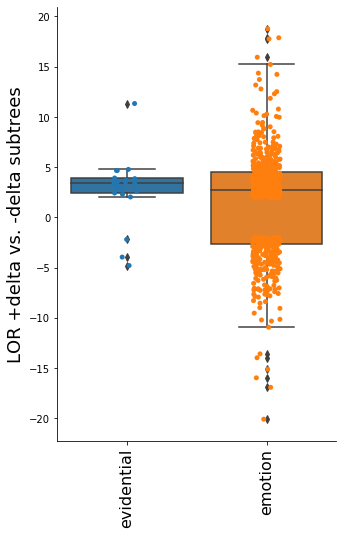

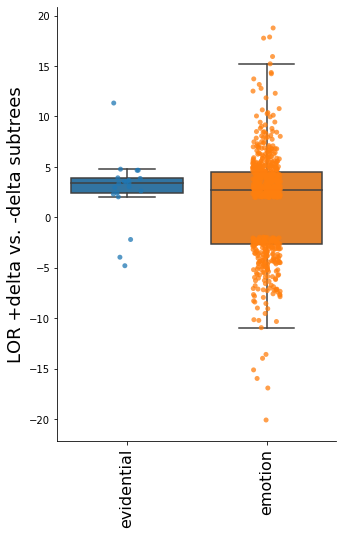

1.1347954091412942 0.2568858786602346


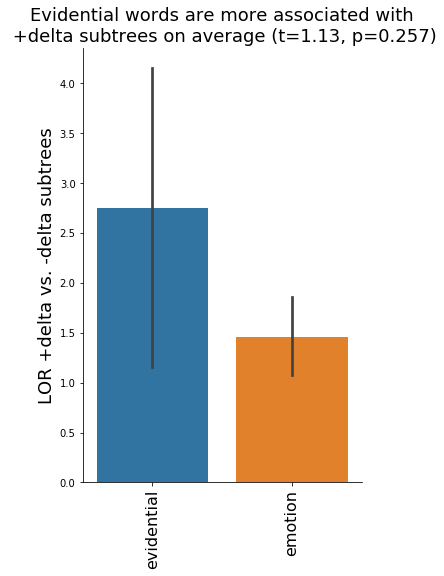

In [184]:
# Evidential keywords vs. emotions

ev_words = list(set(KWS).intersection(set(ngram2lor.keys())))
print(f"LOR values computed for {len(ev_words)} features from evidential entities lexicon.")

emo_words = list(EMOLEX_vocab.intersection(set(ngram2lor.keys())))
print(f"LOR values computed for {len(emo_words)} features from EmoLex lexicon.")

to_plot_df = pd.DataFrame({
    'lor': [ngram2lor[w] for w in ev_words]+[ngram2lor[x] for x in emo_words],
    'word': ev_words+emo_words,
    'cat': ['evidential']*len(ev_words) + ['emotion']*len(emo_words)})
print(to_plot_df['cat'].value_counts())
order = ['evidential','emotion']

# Boxplot
fig, ax = plt.subplots(figsize=(5,8))
#sizes = to_plot_df['emo_val'].apply(lambda x: 3**(7*abs(x-0.5))).values
sns.boxplot(x='cat', y='lor', data=to_plot_df, ax=ax, order=order)
sns.stripplot(x='cat', y='lor', data=to_plot_df, ax=ax, order=order)
ax.set_xlabel("",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
sns.despine()
plt.show()

# Without outliers
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(x='cat', y='lor', data=to_plot_df, ax=ax, order=order, showfliers=False)
sns.stripplot(x='cat', y='lor', data=to_plot_df, ax=ax, alpha=0.75, order=order)
ax.set_xlabel("",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
sns.despine()
plt.show()

# Barplot
t, pval = stats.ttest_ind(to_plot_df.loc[to_plot_df['cat']=='evidential']['lor'],
                          to_plot_df.loc[to_plot_df['cat']=='emotion']['lor'])
print(t,pval)

fig, ax = plt.subplots(figsize=(5,8))
sns.barplot(x='cat', y='lor', data=to_plot_df, ax=ax, order=order)
ax.set_xlabel("",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
comp = 'more' if t > 0 else 'less'
ax.set_title(f"Evidential words are {comp} associated with\n +delta subtrees \
on average (t={round(t,2)}, p={round(pval,3)})", fontsize=18)
sns.despine()
plt.show()

In [186]:
to_plot_df.loc[to_plot_df['cat']=='evidential'].sort_values('lor',ascending=False)

lor        word         cat
2   11.327771    research  evidential
15   4.771069  simulation  evidential
16   4.665532     article  evidential
3    4.655283       model  evidential
10   3.911742        test  evidential
18   3.849874      expert  evidential
8    3.677919       paper  evidential
4    3.550600       study  evidential
14   3.510294      survey  evidential
5    3.416605      method  evidential
6    3.353900  psychology  evidential
12   3.035235   scientist  evidential
11   2.953679     finding  evidential
7    2.605889    analysis  evidential
13   2.418561    abstract  evidential
17   2.294599  experiment  evidential
1    2.025706        data  evidential
9   -2.200917    evidence  evidential
0   -3.959091   statistic  evidential
19  -4.801574  statistics  evidential

LOR values computed for 20 features from evidential entities lexicon.
LOR values computed for 176 features from MFD lexicon.
moral         176
evidential     20
Name: cat, dtype: int64


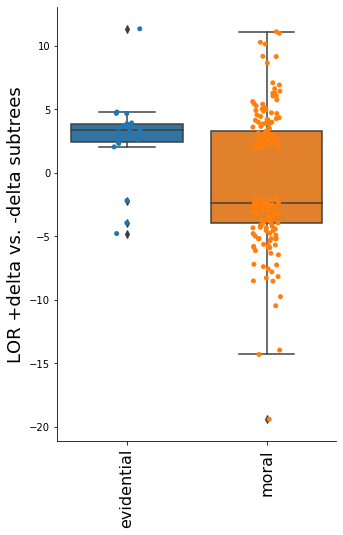

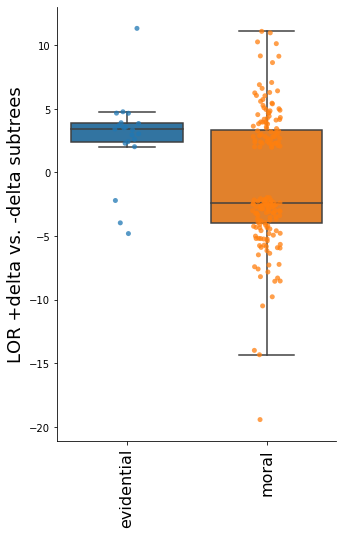

2.9828856271200053 0.003221997788631505


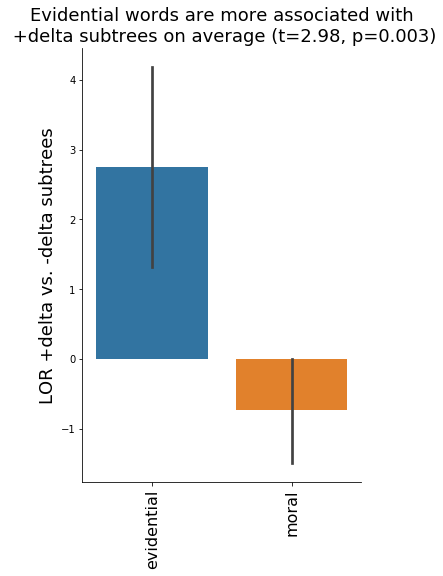

In [144]:
# Evidential keywords vs. MFD

ev_words = list(set(KWS).intersection(set(ngram2lor.keys())))
print(f"LOR values computed for {len(ev_words)} features from evidential entities lexicon.")

emo_words = list(MFD_vocab.intersection(set(ngram2lor.keys())))
print(f"LOR values computed for {len(emo_words)} features from MFD lexicon.")

to_plot_df = pd.DataFrame({
    'lor': [ngram2lor[w] for w in ev_words]+[ngram2lor[x] for x in emo_words],
    'word': ev_words+emo_words,
    'cat': ['evidential']*len(ev_words) + ['moral']*len(emo_words)})
print(to_plot_df['cat'].value_counts())
order = ['evidential','moral']

# Boxplot
fig, ax = plt.subplots(figsize=(5,8))
#sizes = to_plot_df['emo_val'].apply(lambda x: 3**(7*abs(x-0.5))).values
sns.boxplot(x='cat', y='lor', data=to_plot_df, ax=ax, order=order)
sns.stripplot(x='cat', y='lor', data=to_plot_df, ax=ax, order=order)
ax.set_xlabel("",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
sns.despine()
plt.show()

# Without outliers
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(x='cat', y='lor', data=to_plot_df, ax=ax, order=order, showfliers=False)
sns.stripplot(x='cat', y='lor', data=to_plot_df, ax=ax, alpha=0.75, order=order)
ax.set_xlabel("",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
sns.despine()
plt.show()

# Barplot
t, pval = stats.ttest_ind(to_plot_df.loc[to_plot_df['cat']=='evidential']['lor'],
                          to_plot_df.loc[to_plot_df['cat']=='moral']['lor'])
print(t,pval)

fig, ax = plt.subplots(figsize=(5,8))
sns.barplot(x='cat', y='lor', data=to_plot_df, ax=ax, order=order)
ax.set_xlabel("",fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=90)
ax.set_ylabel("LOR +delta vs. -delta subtrees",fontsize=18)
comp = 'more' if t > 0 else 'less'
ax.set_title(f"Evidential words are {comp} associated with\n +delta subtrees \
on average (t={round(t,2)}, p={round(pval,3)})", fontsize=18)
sns.despine()
plt.show()